In [1]:
from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import save, reset_output, output_notebook
import folium
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col, datediff, round, to_date, lit, desc, date_format, when
import pyspark.sql.functions as F
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark import SparkContext

# create a spark session (which will run spark jobs)
spark = SparkSession.builder.getOrCreate()

sc = SparkContext.getOrCreate(conf=swan_spark_conf) #Start the spark context
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)



In [2]:
from pyspark import SparkContext
# Test Monitor:
sc = SparkContext.getOrCreate(conf=swan_spark_conf) #Start the spark context
rdd = sc.parallelize([1, 2, 4, 8])
rdd.count()

4

In [3]:
## Read Data

sdf_yellow = spark.read.parquet("../preprocessed_data/yellow.parquet/")
sdf_green = spark.read.parquet("../preprocessed_data/green.parquet/")
sdf_hvf = spark.read.parquet("../preprocessed_data/fhv.parquet/")
sdf_hvfhv = spark.read.parquet("../preprocessed_data/hvfhv.parquet/")

# Extreme Weather Data:


### Heavy Rain, Winter Storm, Extreme Snow Event

Record Date:

    "2019-01-30",    
    "2019-01-31",         
    "2019-03-02",     
    "2019-03-03",
    "2019-03-04",

From  https://www.weather.gov/okx/stormevents  Inspect 2019's Data

https://www.ncdc.noaa.gov/stormevents/listevents.jsp?eventType=ALL&beginDate_mm=01&beginDate_dd=01&beginDate_yyyy=2019&endDate_mm=05&endDate_dd=31&endDate_yyyy=2019&county=NEW%2BYORK%3A61&hailfilter=0.00&tornfilter=0&windfilter=000&sort=DT&submitbutton=Search&statefips=36%2CNEW+YORK

School Closing :  
https://ny.curbed.com/2019/3/3/18249440/new-york-weather-winter-storm-2019-snow on 2019-03-04

In [4]:
color = ["skyblue", "salmon", "limegreen"]

In [5]:
from numpy import log, sqrt

# apply a log transformation for all x non-zero x points, else 0
def logify(x):
    return log(x) if x else 0
def rice(x):
    return int(2 * x ** (1/3))

In [6]:
## Extreme Dates
extreme_days = [
    "2019-01-30",    
    "2019-01-31",    
                
    "2019-03-02",     
    "2019-03-03",
    "2019-03-04",
                
]

In [7]:
# Holiday Filter, True for all days not been weekend but holiday
# df.loc[isHoliday(df["date"])       # Select Dataframe if is holiday
def isHoliday(df_column):
    holidays = [
        "2019-01-01",
        "2019-01-21",
        "2019-02-12",
        "2019-02-18",
        "2019-05-12",
        "2019-05-27",
    ]
    return df_column.astype(str).str.contains('|'.join(holidays))

holidays = [
        "2019-01-01",
        "2019-01-21",
        "2019-02-12",
        "2019-02-18",
        "2019-05-12",
        "2019-05-27",
    ]

### HV FHV Extreme Weather Analysis:

In [8]:
## Get Dataframe
sdf_fhv_day_data = spark.read.parquet("../preprocessed_data/hvfhv_daily.parquet/")
sdf_fhv_day_data = sdf_fhv_day_data.orderBy("date")
## Eyeballing and find outlier that pickups are very low after May, Mainly Because Memorial Holiday
sdf_fhv_day_data = sdf_fhv_day_data.filter(sdf_fhv_day_data["date"]<=lit("2019-05-10"))  
sdf_fhv_day_data = sdf_fhv_day_data.filter(sdf_fhv_day_data["date"]>=lit("2019-02-01"))  
fhv_df = sdf_fhv_day_data.toPandas()

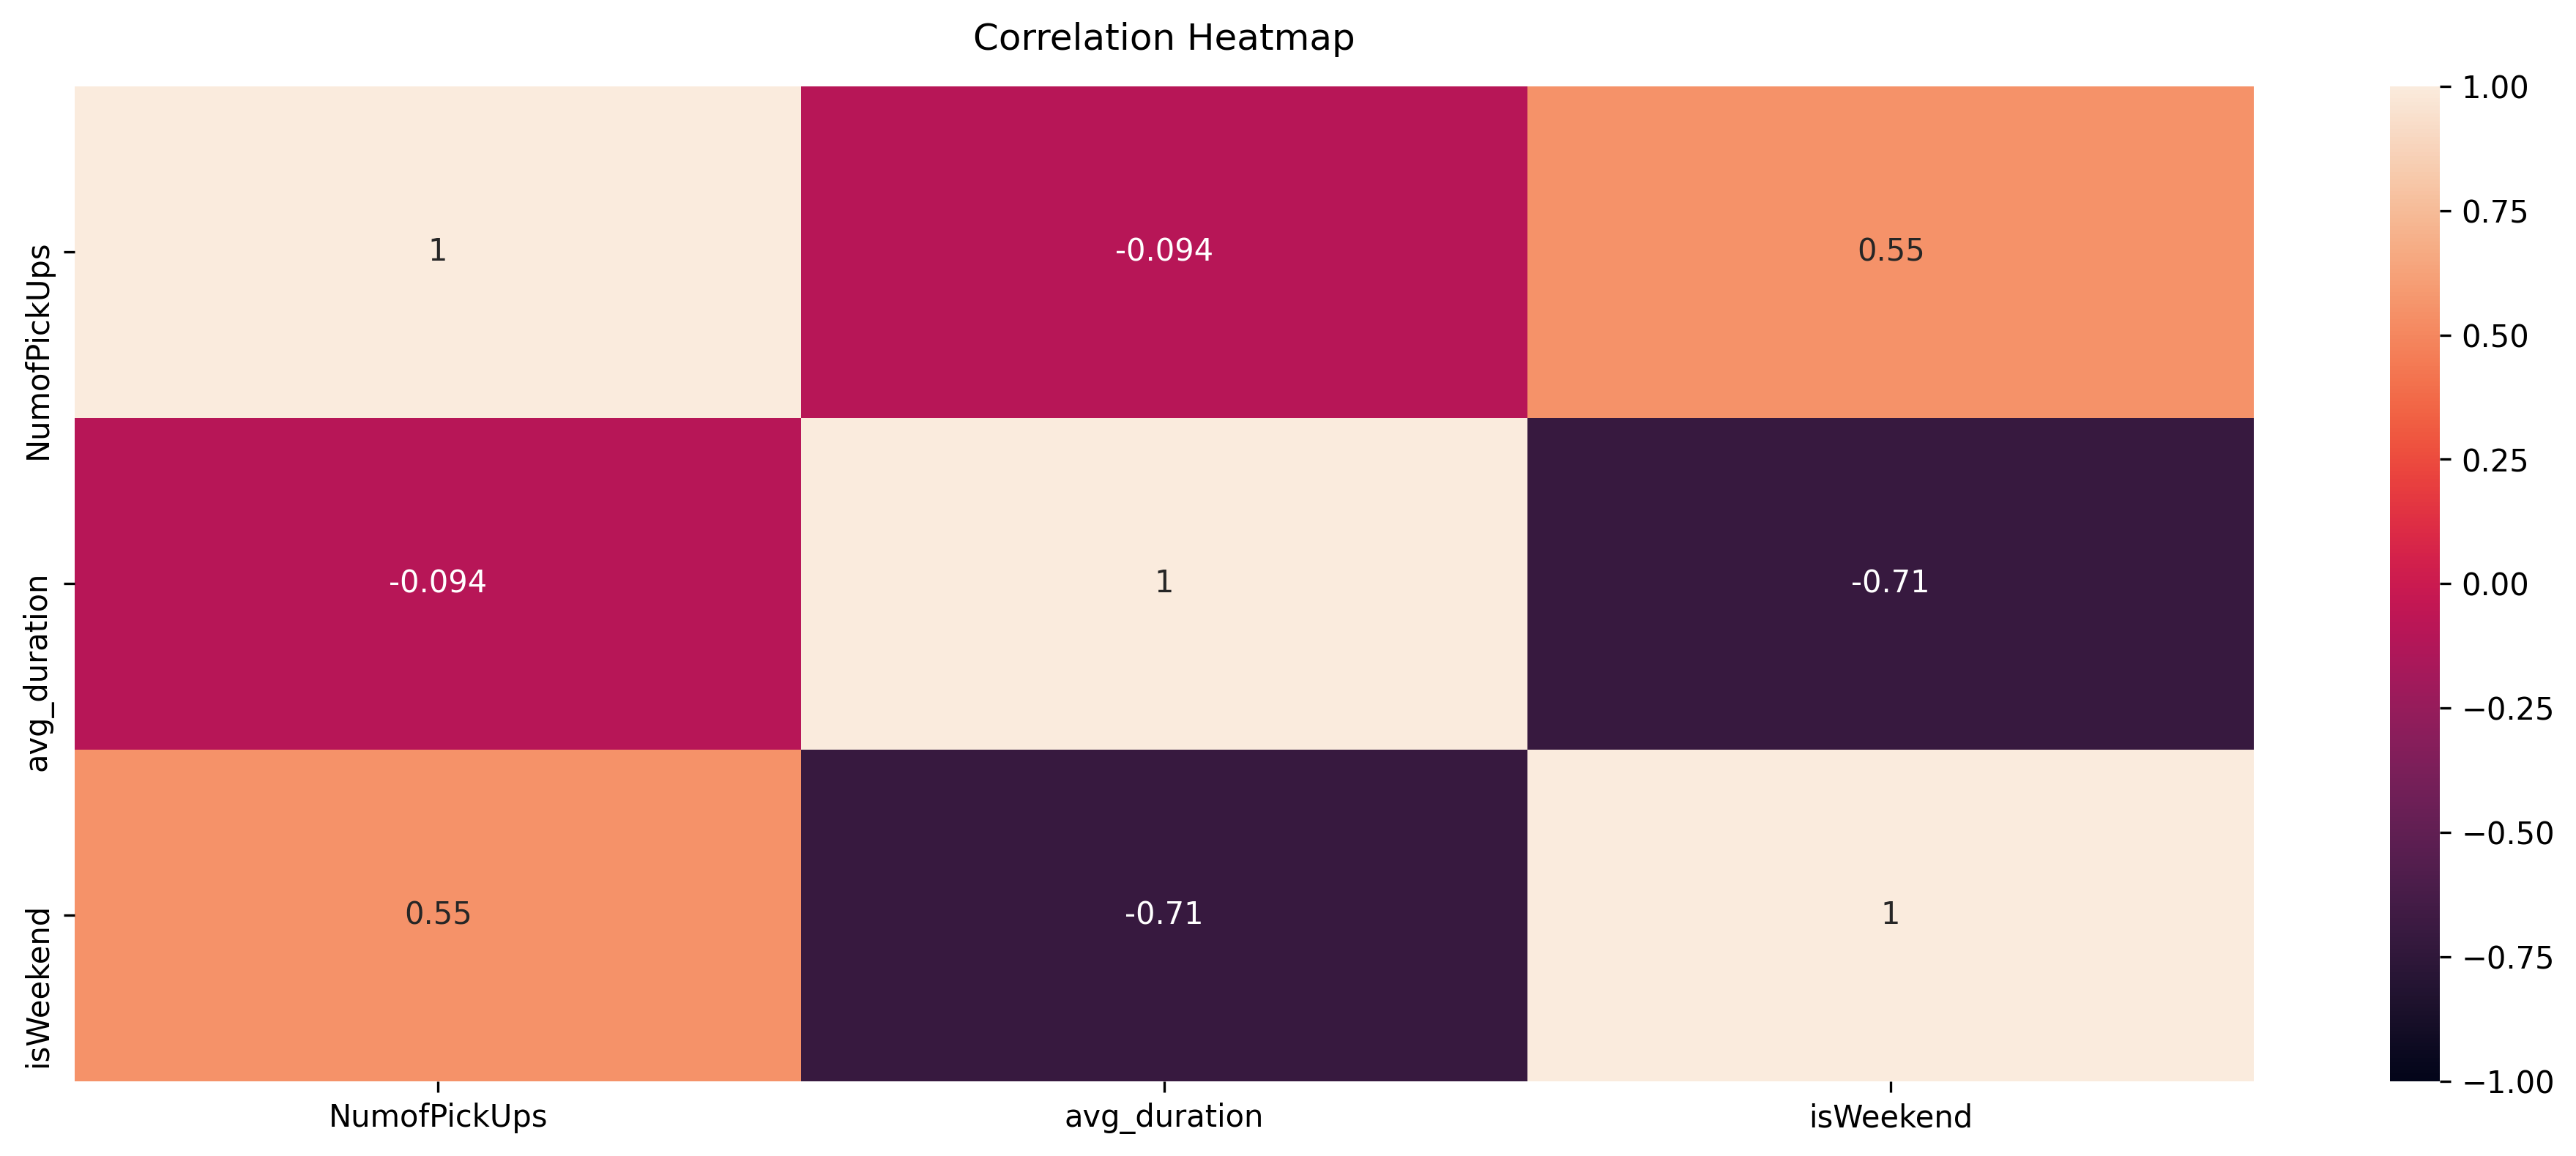

In [9]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(fhv_df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [10]:
fhv_df.head(3)

,date,NumofPickUps,avg_duration,isWeekend,DayOfWeek
0,2019-02-01,858400,18.68,False,Fri
1,2019-02-02,864783,17.74,True,Sat
2,2019-02-03,755193,17.05,True,Sun


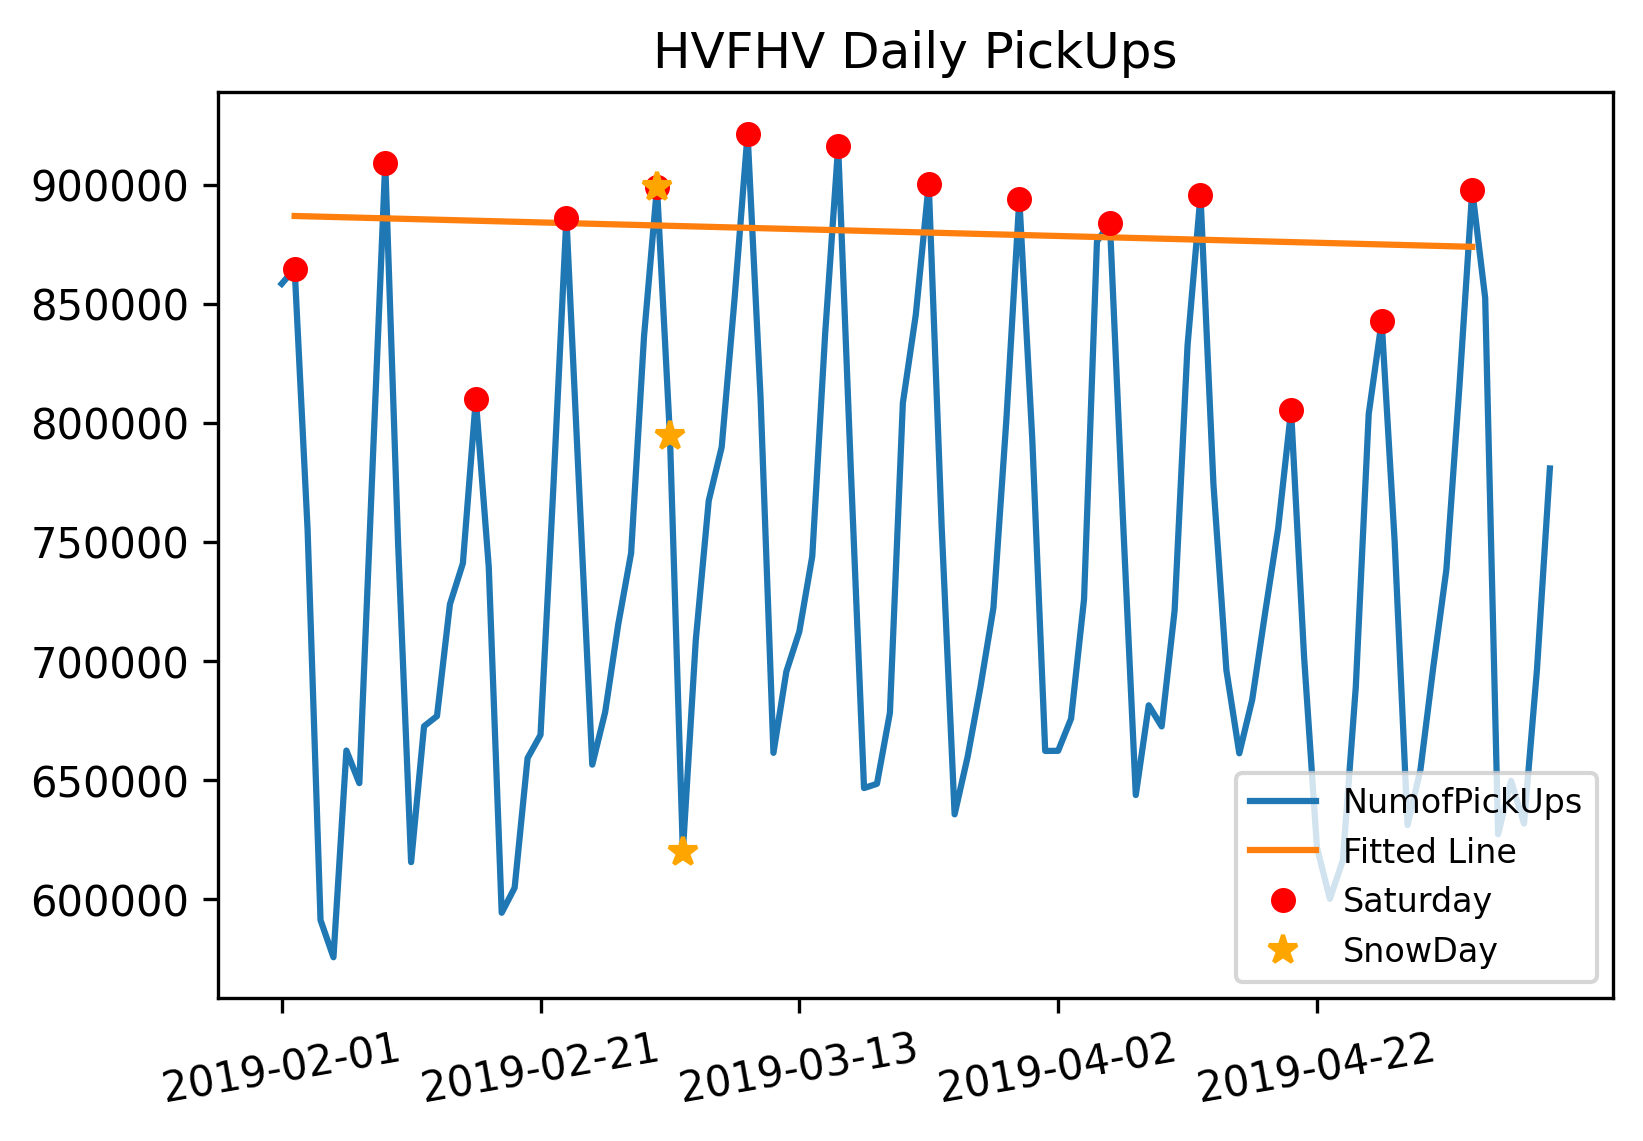

In [11]:


## Get Extreme Day's Data

e_fhv_df = fhv_df.loc[fhv_df["date"].astype(str).isin(extreme_days)]
e_fhv_df.head(2)

# Weekend data on overall

ax = fhv_df["NumofPickUps"].plot.line()

# Plot Linear Regression Line
x = fhv_df.index[fhv_df['DayOfWeek'] == "Sat"].tolist()
y = fhv_df.loc[fhv_df["DayOfWeek"]=="Sat"]["NumofPickUps"]

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(x, poly1d_fn(x), label="Fitted Line")

dow = plt.plot(fhv_df.index[fhv_df['DayOfWeek'] == "Sat"].tolist(),
             fhv_df.loc[fhv_df["DayOfWeek"]=="Sat"]["NumofPickUps"], 
             marker='o', markersize=5, color="red", label='Saturday', linestyle = 'None')


Snow = plt.plot(e_fhv_df.index.tolist(),
             e_fhv_df["NumofPickUps"], 
             marker='*', markersize=7, color="orange", label='SnowDay', linestyle = 'None')


plt.xticks(np.arange(fhv_df.shape[0])[::20], fhv_df.date[::20], rotation=10)

plt.legend(
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=8)

plt.title("HVFHV Daily PickUps")

plt.savefig("../plots/HVFHV_Time_PickUp.png")

plt.show()

In [12]:
### Day of Week Summary (GroupBy DOW)
        
WEEKDAY = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

## Exclude Holiday as it may distort the result
#NormalDay
dow_df_pre_normal = fhv_df.loc[~isHoliday(fhv_df["date"])]
dow_df_normal = fhv_df.groupby("DayOfWeek").median().reindex(WEEKDAY) 

#ExtremeWeather
dow_df_pre_extreme = e_fhv_df.loc[~isHoliday(e_fhv_df["date"])]
dow_df_extreme = e_fhv_df.groupby("DayOfWeek").median().reindex(WEEKDAY) 

#Holiday
dow_df_holiday = fhv_df.loc[isHoliday(fhv_df["date"])].groupby("DayOfWeek").median().reindex(WEEKDAY) 

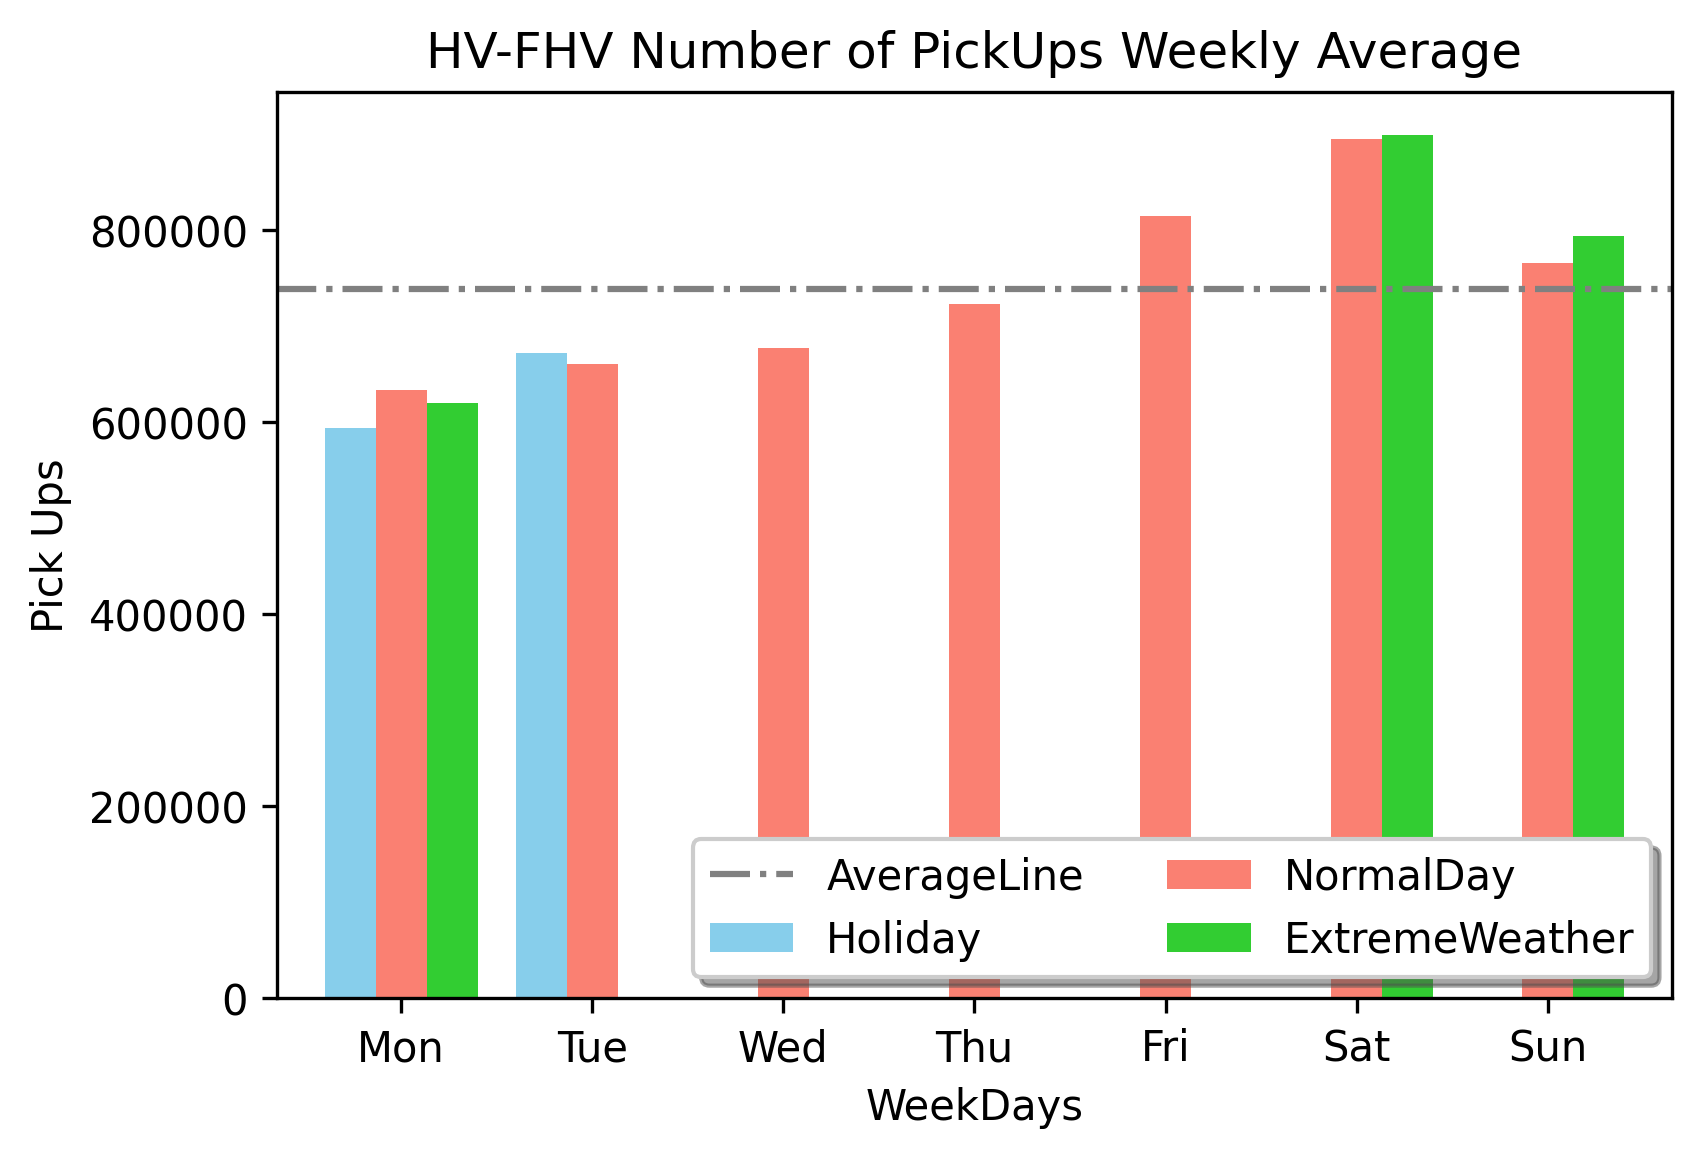

In [13]:
# Week Day Extreme VS Normal Pickups
WEEKDAY = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

x = WEEKDAY

y1 = dow_df_normal["NumofPickUps"]
y2 = dow_df_extreme["NumofPickUps"]
y3 = dow_df_holiday["NumofPickUps"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=['Holiday', "NormalDay", "ExtremeWeather", ],
              kind="bar",
              title="HV-FHV Number of PickUps Weekly Average",
              grid=0,
              width=0.8,
                color = color
             )

line_x = np.linspace(-1, 10,7)

# AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")



fig.set_xlabel("WeekDays")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

fig.figure.savefig('../plots/HVFHV_Weekly.png')

Weekend Travels have -14.69% Drop compared with WeekDay Travels


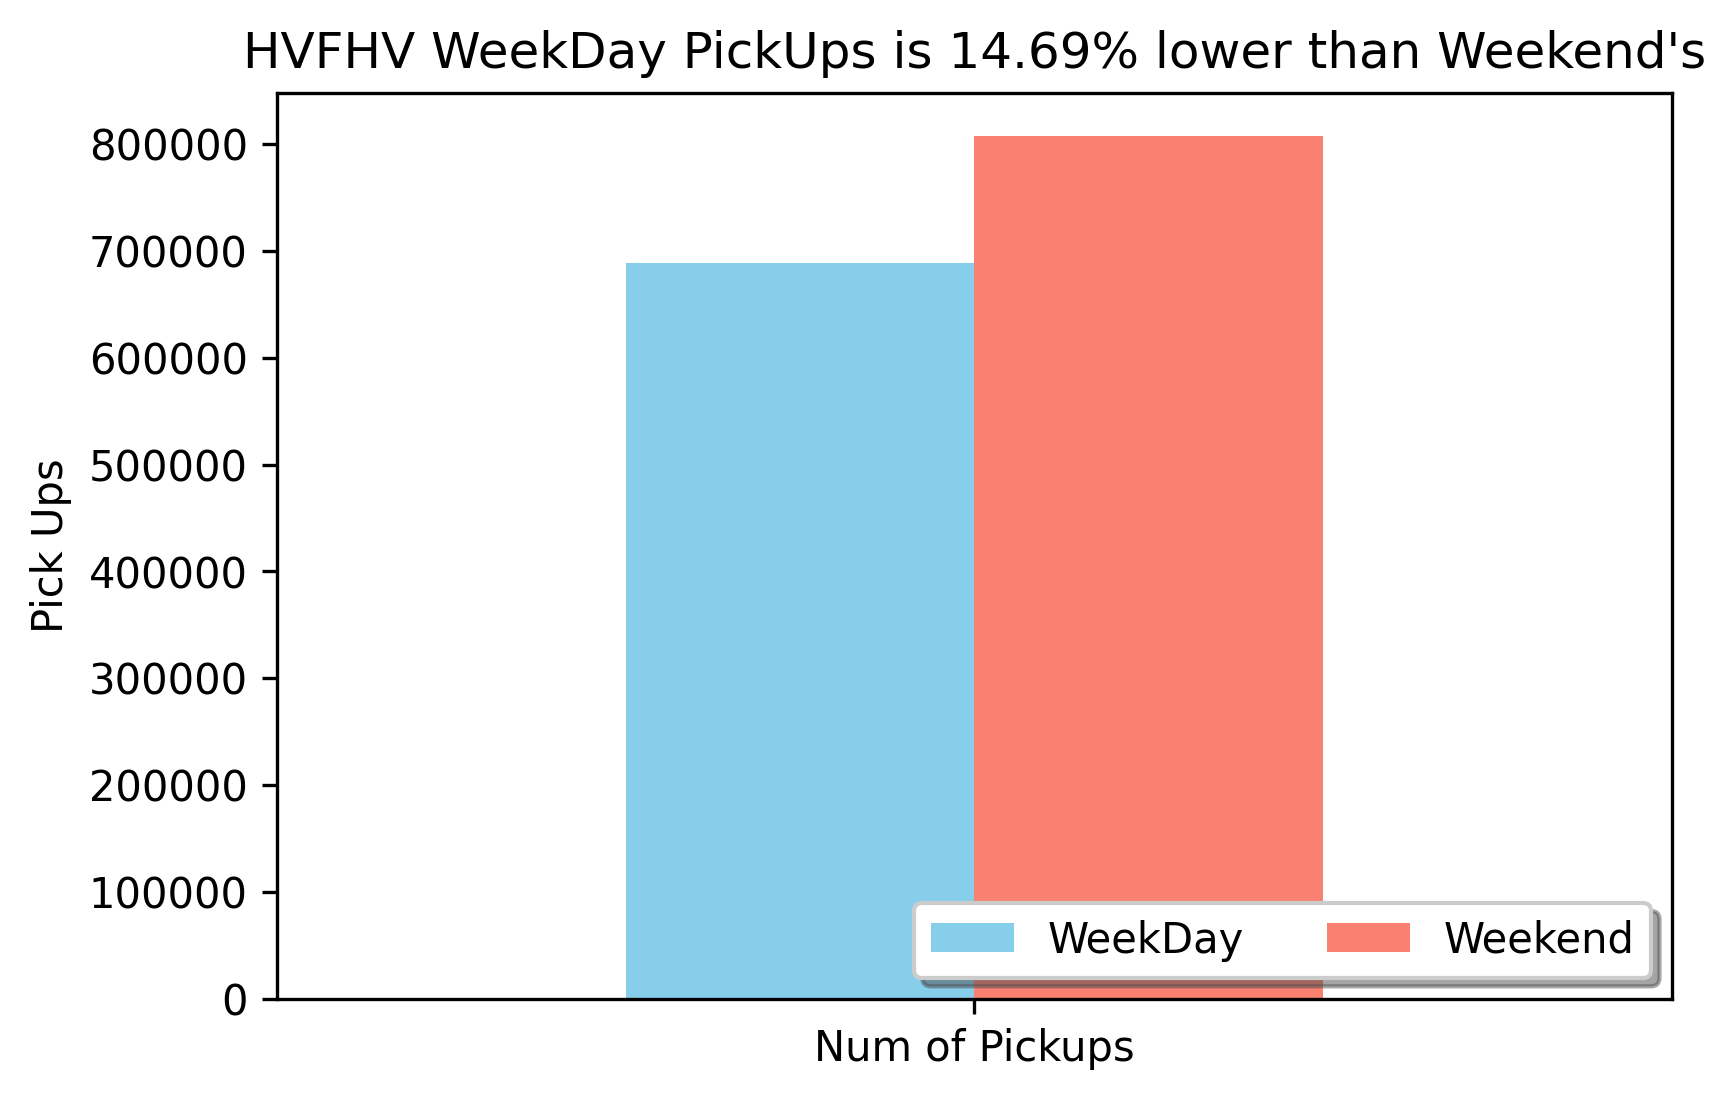

In [14]:

# WEEKDAY VS WEEKEND

# creating dataframe
df = pd.DataFrame({
    'Statistics': ['Num of Pickups'],
    'WeekDay': [
        fhv_df.loc[fhv_df['isWeekend'] == False,"NumofPickUps"].median()
                 ],
    'Weekend': [
        fhv_df.loc[fhv_df['isWeekend'] == True,"NumofPickUps"].median()
         ]
})
  
# plotting graph

fig = df.plot(
              x="Statistics",
              y=["WeekDay", "Weekend"],
              kind="bar",
              title="HVFHV WeekDay PickUps is 14.69% lower than Weekend's",
              grid=0,
                color = color
             )

fig.set_xlabel("")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

percent = (fhv_df.loc[fhv_df['isWeekend'] == False,"NumofPickUps"].median() / fhv_df.loc[fhv_df['isWeekend'] == True,"NumofPickUps"].median() - 1)*100
print(f"Weekend Travels have {np.round(percent,2)}% Drop compared with WeekDay Travels")

fig.figure.savefig('../plots/HVFHV_Weekday_Vs_Weekend_PickUps_Overall.png')



Weekend Travels have -4.63% Drop compared with WeekDay Travels


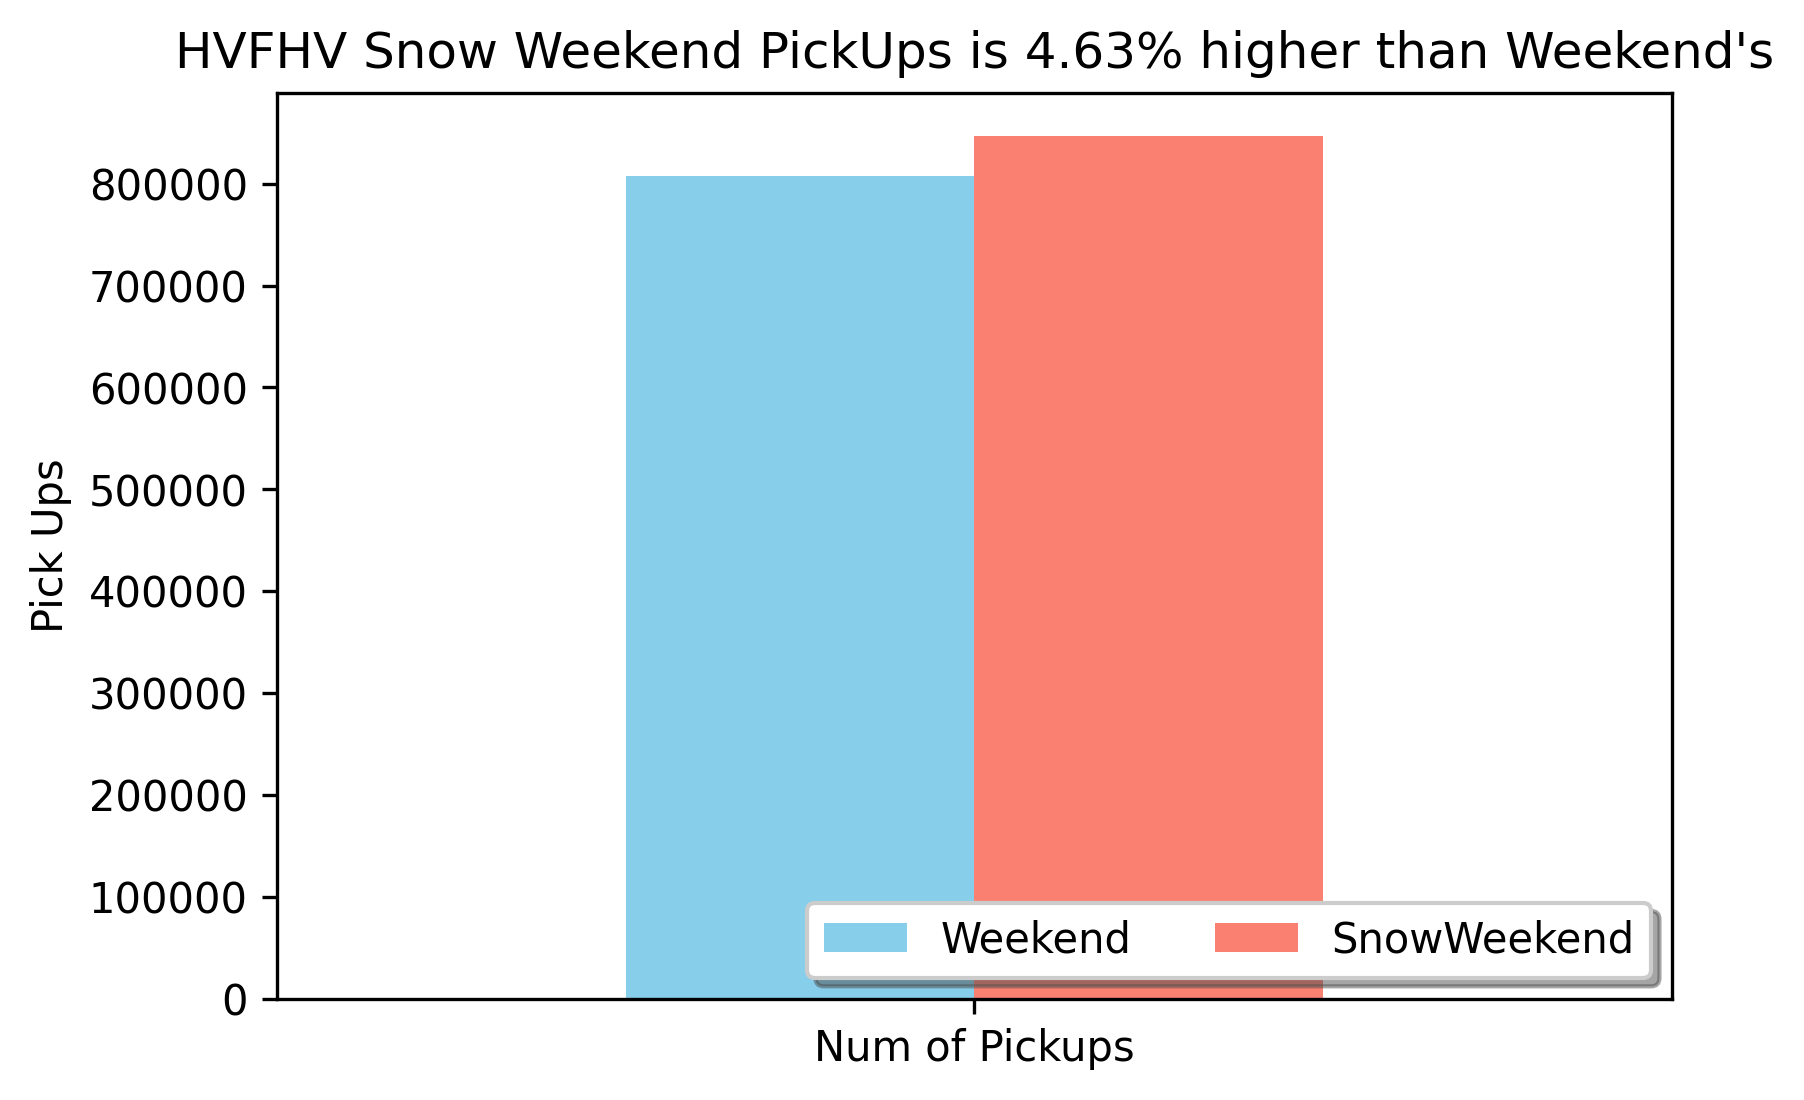

In [15]:

# WEEKDAY VS WEEKEND

# creating dataframe
df = pd.DataFrame({
    'Statistics': ['Num of Pickups'],
    'Weekend': [
        fhv_df.loc[fhv_df['isWeekend'] == True,"NumofPickUps"].median()
                 ],
    'SnowWeekend': [
        e_fhv_df.loc[e_fhv_df['isWeekend'] == True,"NumofPickUps"].median()
         ]
})
  
# plotting graph

fig = df.plot(
              x="Statistics",
              y=["Weekend", "SnowWeekend"],
              kind="bar",
              title="HVFHV Snow Weekend PickUps is 4.63% higher than Weekend's",
              grid=0,
                color = color
             )

fig.set_xlabel("")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

percent = (fhv_df.loc[fhv_df['isWeekend'] == True,"NumofPickUps"].median() / e_fhv_df.loc[e_fhv_df['isWeekend'] == True,"NumofPickUps"].median() - 1)*100
print(f"Weekend Travels have {np.round(percent,2)}% Drop compared with WeekDay Travels")

fig.figure.savefig('../plots/HVFHV_snow_impact.png')



### FHV Extreme Weather Analysis:

In [16]:
## Get Dataframe
sdf_fhv_day_data = spark.read.parquet("../preprocessed_data/fhv_daily.parquet/")
sdf_fhv_day_data = sdf_fhv_day_data.orderBy("date")
## Eyeballing and find outlier that pickups are very low after May, Mainly Because Memorial Holiday
sdf_fhv_day_data = sdf_fhv_day_data.filter(sdf_fhv_day_data["date"]<=lit("2019-05-10"))  
sdf_fhv_day_data = sdf_fhv_day_data.filter(sdf_fhv_day_data["date"]>=lit("2019-02-01"))  
fhv_df = sdf_fhv_day_data.toPandas()

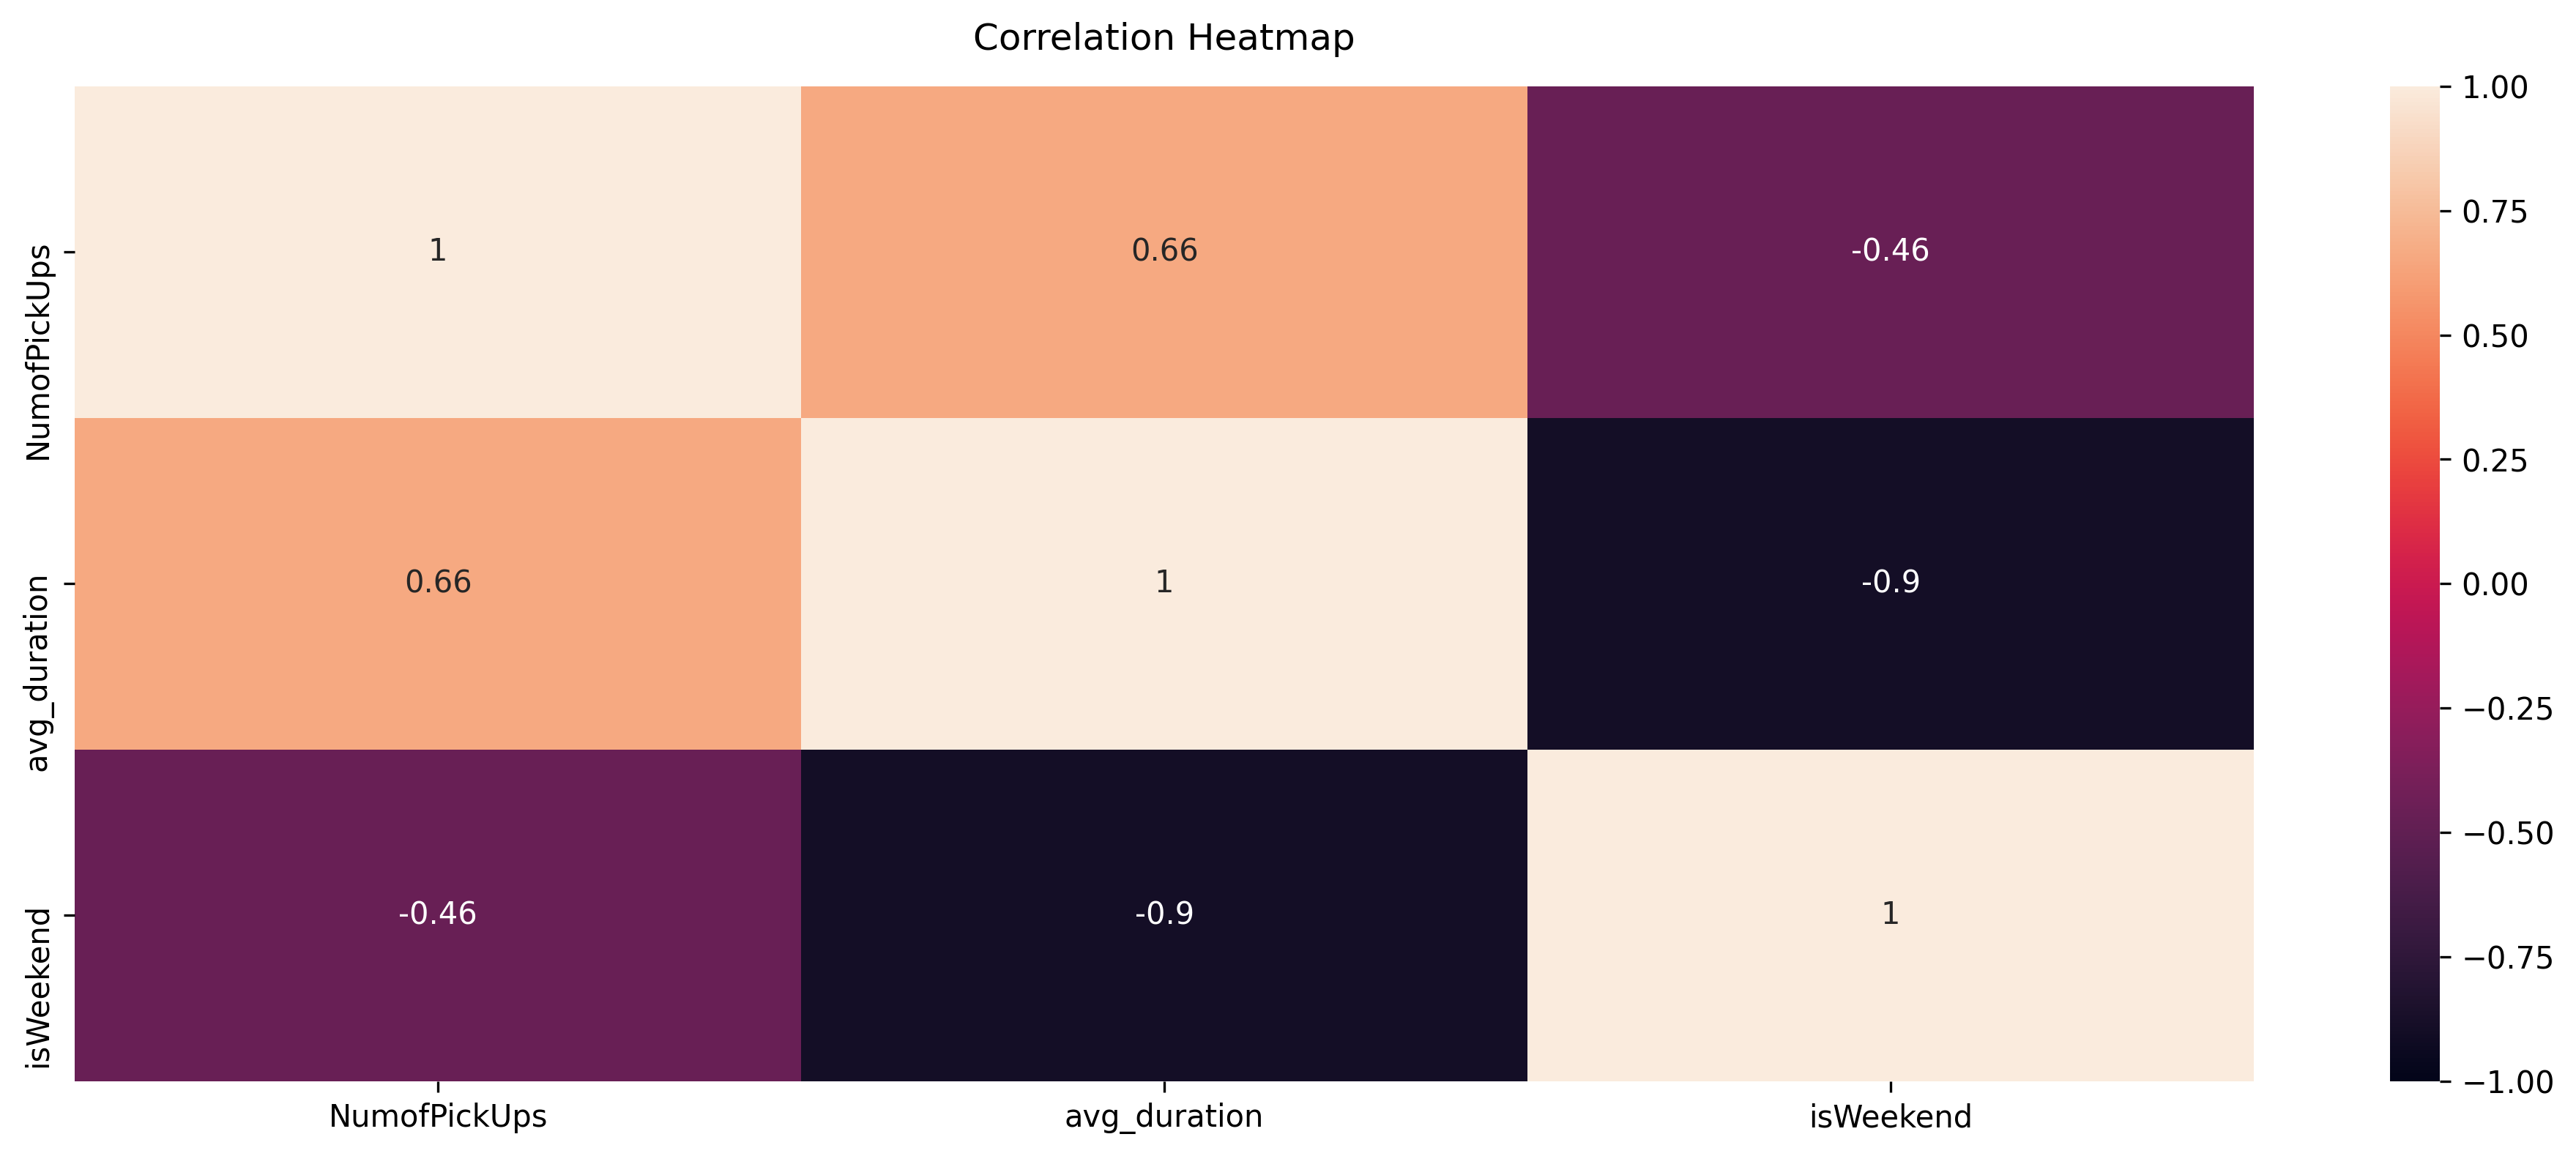

In [17]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(fhv_df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [18]:
## Get Extreme Day's Data

e_fhv_df = fhv_df.loc[fhv_df["date"].astype(str).isin(extreme_days)]
e_fhv_df.head(2)

,date,NumofPickUps,avg_duration,isWeekend,DayOfWeek
29,2019-03-02,33931,17.06,True,Sat
30,2019-03-03,32506,16.86,True,Sun


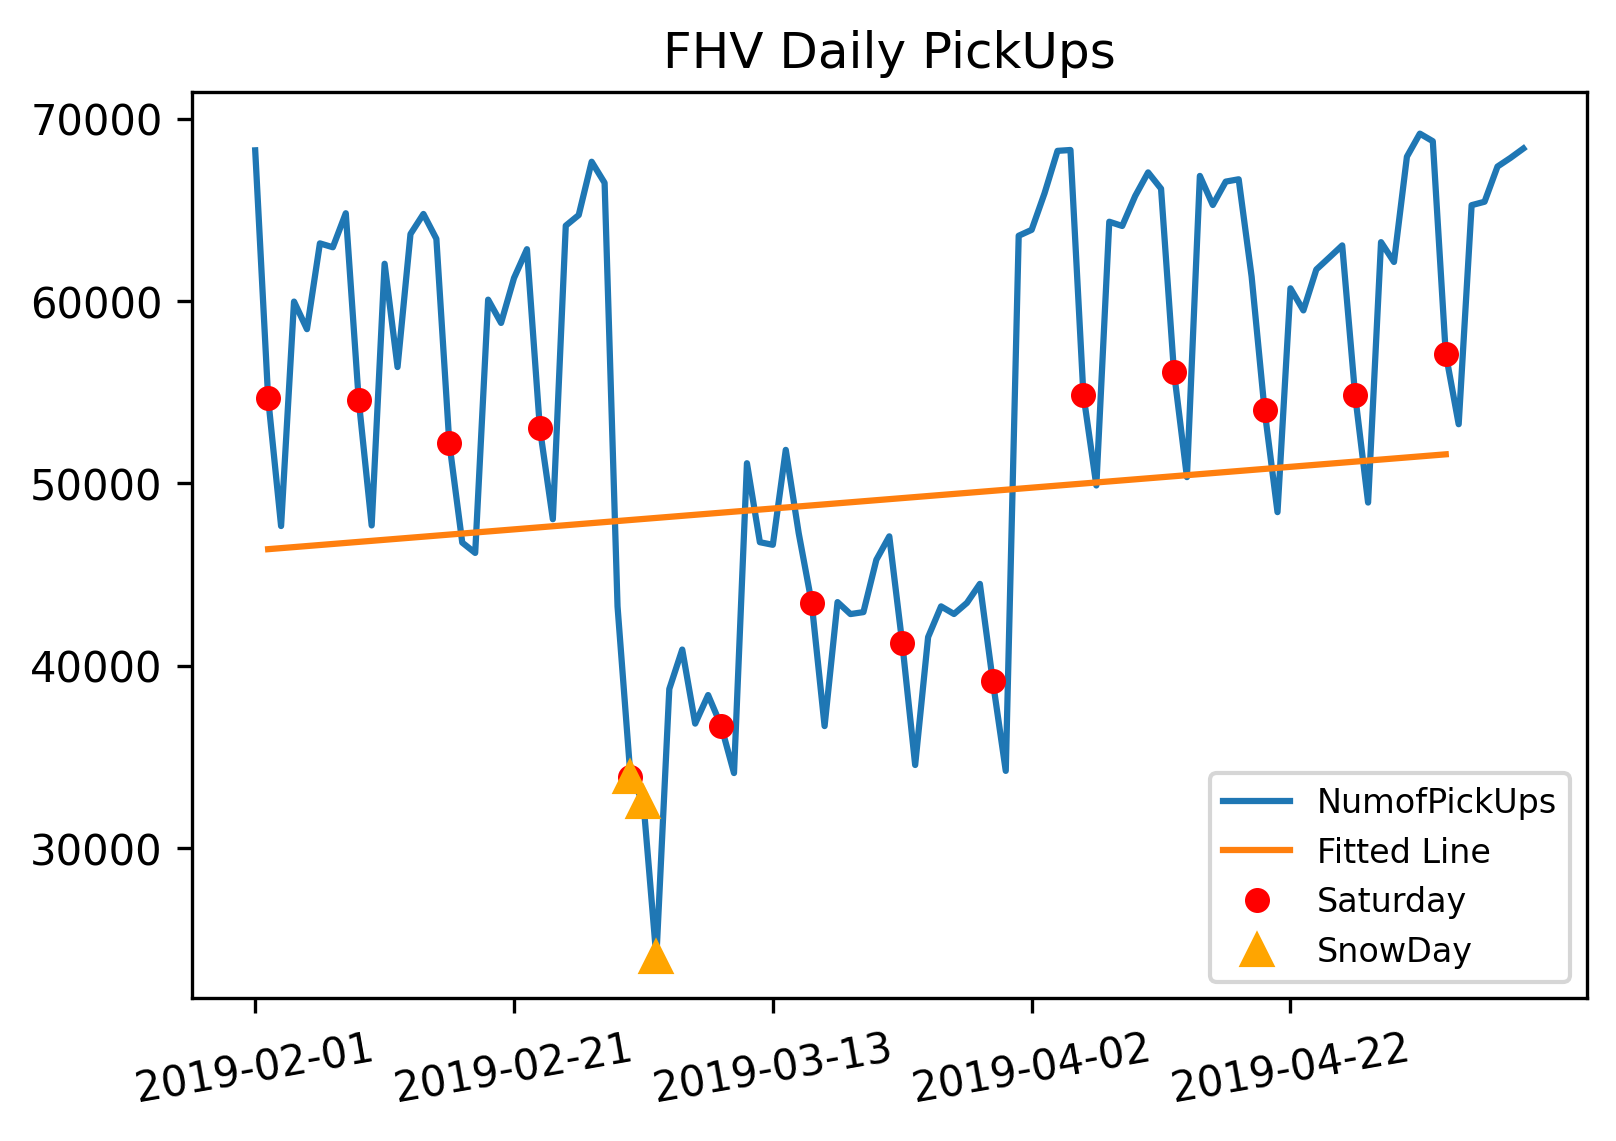

In [19]:


## Get Extreme Day's Data

e_fhv_df = fhv_df.loc[fhv_df["date"].astype(str).isin(extreme_days)]
e_fhv_df.head(2)

# Weekend data on overall

ax = fhv_df["NumofPickUps"].plot.line()

# Plot Linear Regression Line
x = fhv_df.index[fhv_df['DayOfWeek'] == "Sat"].tolist()
y = fhv_df.loc[fhv_df["DayOfWeek"]=="Sat"]["NumofPickUps"]

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(x, poly1d_fn(x), label="Fitted Line")

dow = plt.plot(fhv_df.index[fhv_df['DayOfWeek'] == "Sat"].tolist(),
             fhv_df.loc[fhv_df["DayOfWeek"]=="Sat"]["NumofPickUps"], 
             marker='o', markersize=5, color="red", label='Saturday', linestyle = 'None')


Snow = plt.plot(e_fhv_df.index.tolist(),
             e_fhv_df["NumofPickUps"], 
             marker='^', markersize=7, color="orange", label='SnowDay', linestyle = 'None')


plt.xticks(np.arange(fhv_df.shape[0])[::20], fhv_df.date[::20], rotation=10)

plt.legend(
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=8)

plt.title("FHV Daily PickUps")

plt.savefig("../plots/FHV_Time_PickUp.png")

plt.show()

In [20]:
### Day of Week Summary (GroupBy DOW)
        
WEEKDAY = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

## Exclude Holiday as it may distort the result
#NormalDay
dow_df_pre_normal = fhv_df.loc[~isHoliday(fhv_df["date"])]
dow_df_normal = fhv_df.groupby("DayOfWeek").median().reindex(WEEKDAY) 

#ExtremeWeather
dow_df_pre_extreme = e_fhv_df.loc[~isHoliday(e_fhv_df["date"])]
dow_df_extreme = e_fhv_df.groupby("DayOfWeek").median().reindex(WEEKDAY) 

#Holiday
dow_df_holiday = fhv_df.loc[isHoliday(fhv_df["date"])].groupby("DayOfWeek").median().reindex(WEEKDAY) 

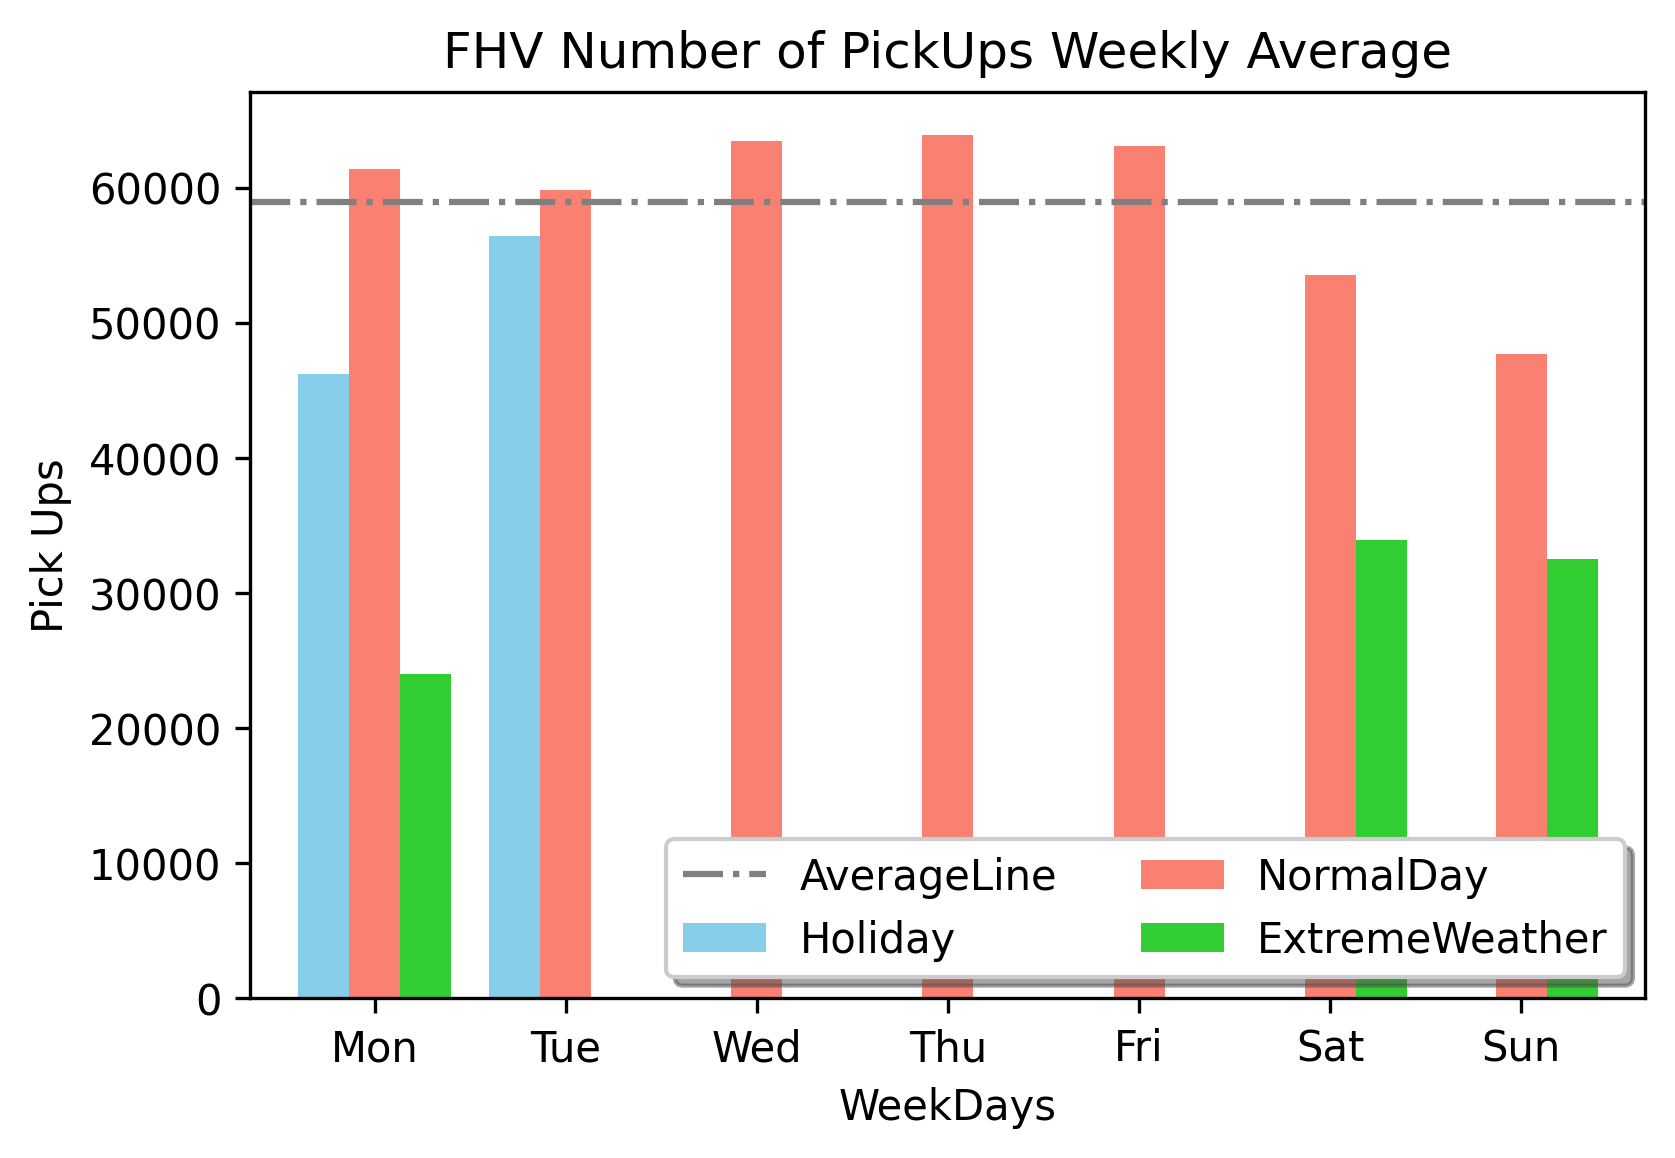

In [21]:
# Week Day Extreme VS Normal Pickups
WEEKDAY = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

x = WEEKDAY

y1 = dow_df_normal["NumofPickUps"]
y2 = dow_df_extreme["NumofPickUps"]
y3 = dow_df_holiday["NumofPickUps"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=['Holiday', "NormalDay", "ExtremeWeather", ],
              kind="bar",
              title="FHV Number of PickUps Weekly Average",
              grid=0,
              width=0.8,
                color = color
             )

line_x = np.linspace(-1, 10,7)

# AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")



fig.set_xlabel("WeekDays")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

fig.figure.savefig('../plots/FHV_Weekly.png')

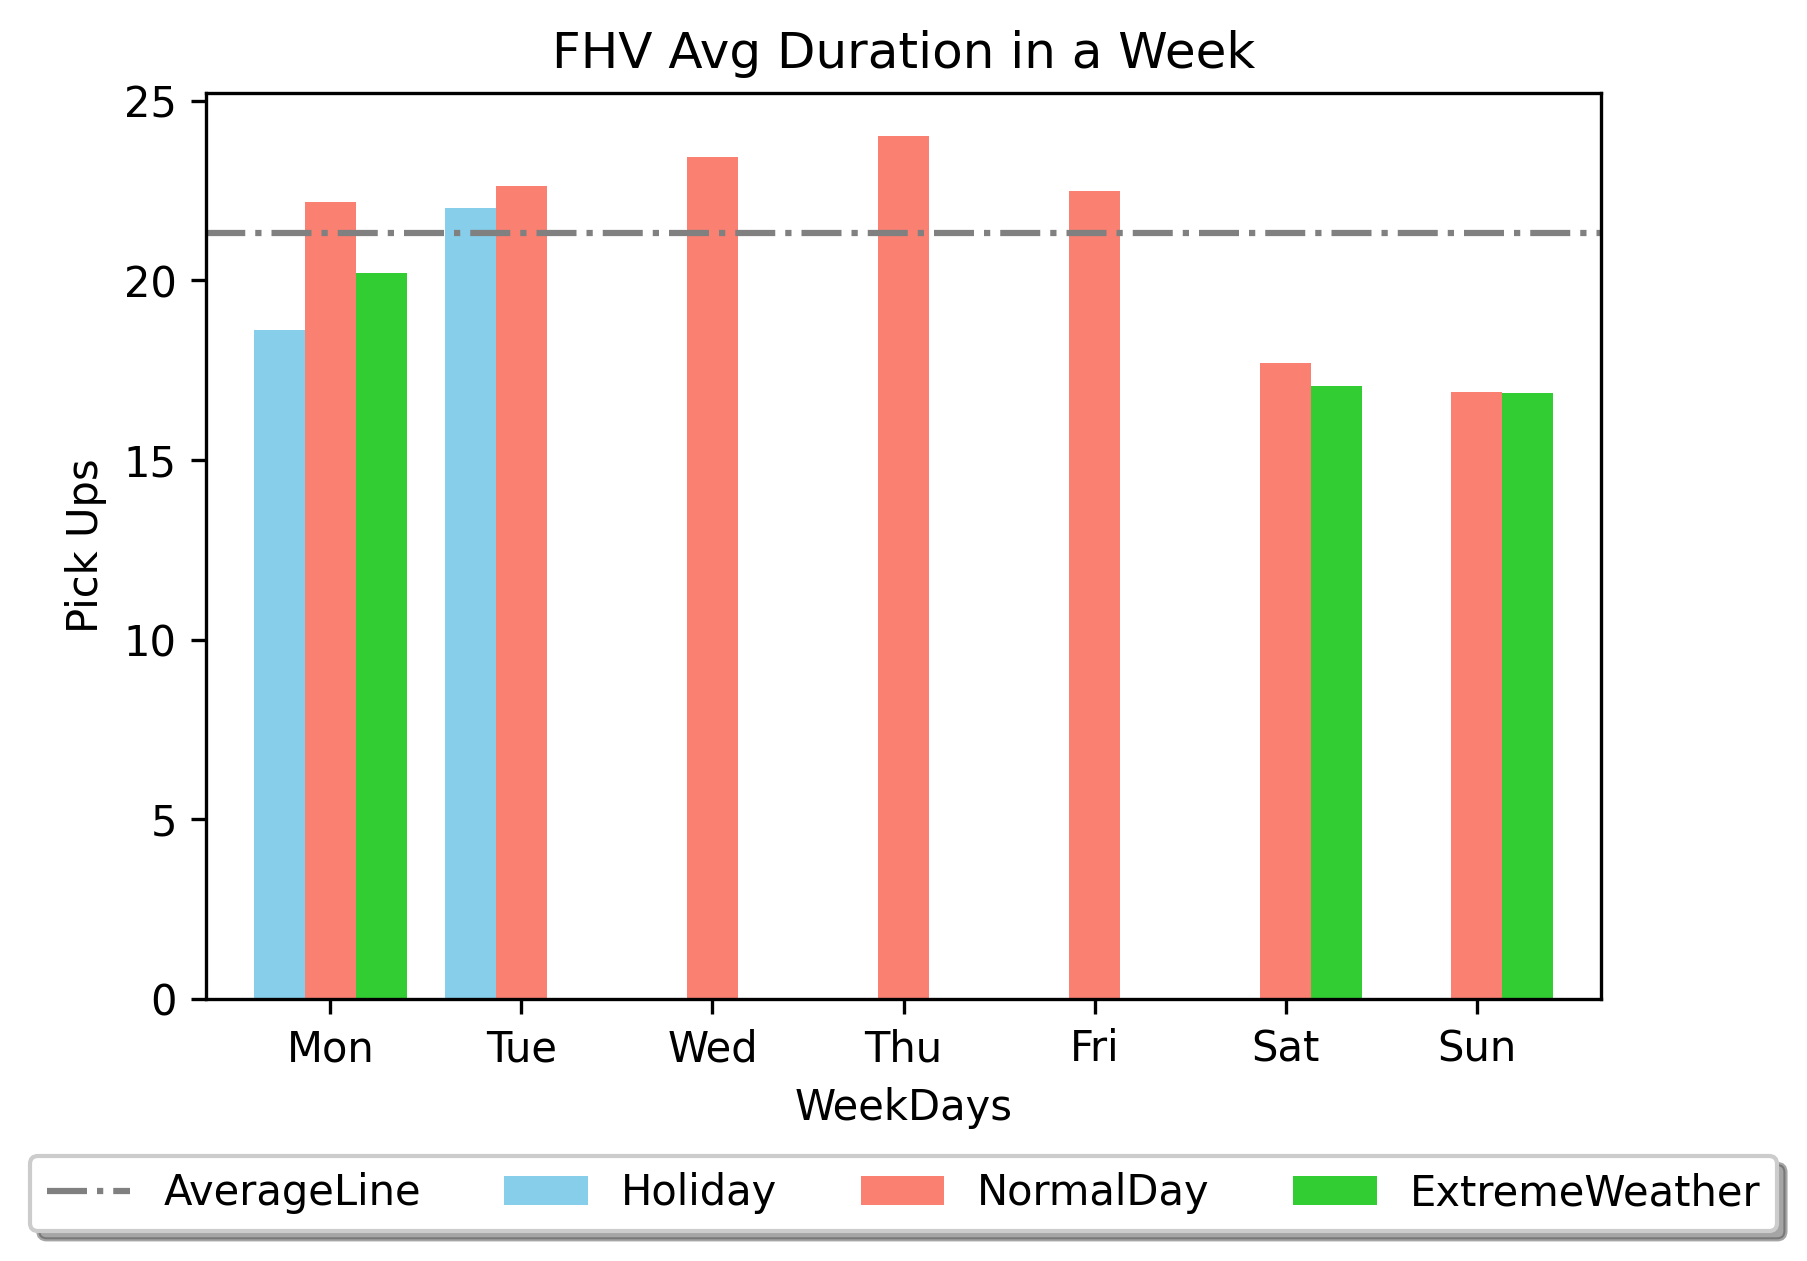

In [22]:
# Week Day Extreme VS Normal Pickups
WEEKDAY = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

x = WEEKDAY

y1 = dow_df_normal["avg_duration"]
y2 = dow_df_extreme["avg_duration"]
y3 = dow_df_holiday["avg_duration"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=['Holiday', "NormalDay", "ExtremeWeather", ],
              kind="bar",
              title="FHV Avg Duration in a Week",
              grid=0,
              width=0.8,
                color = color
             )

line_x = np.linspace(-1, 10,7)

# AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")



fig.set_xlabel("WeekDays")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

fig.figure.savefig('../plots/FHV_Duration_week.png')

Weekend Travels have 30.52% Drop compared with WeekDay Travels


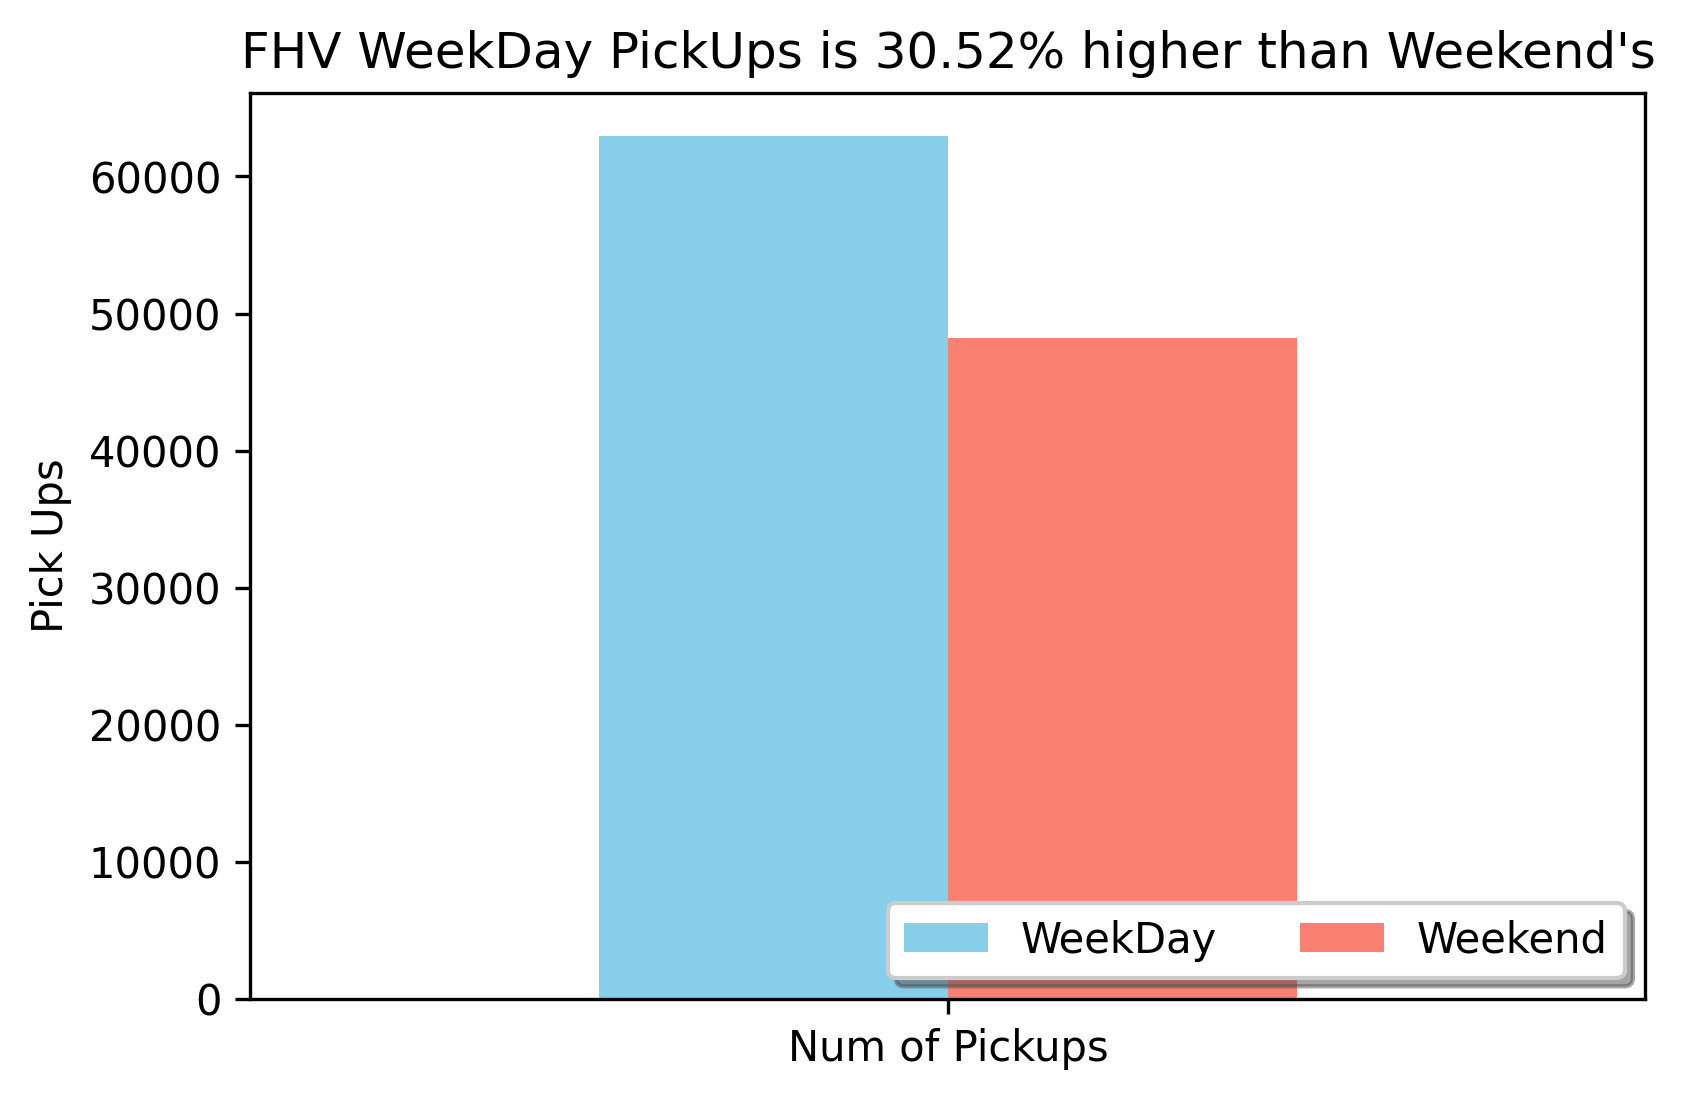

In [23]:

# WEEKDAY VS WEEKEND

# creating dataframe
df = pd.DataFrame({
    'Statistics': ['Num of Pickups'],
    'WeekDay': [
        fhv_df.loc[fhv_df['isWeekend'] == False,"NumofPickUps"].median()
                 ],
    'Weekend': [
        fhv_df.loc[fhv_df['isWeekend'] == True,"NumofPickUps"].median()
         ]
})
  
# plotting graph

fig = df.plot(
              x="Statistics",
              y=["WeekDay", "Weekend"],
              kind="bar",
              title="FHV WeekDay PickUps is 30.52% higher than Weekend's",
              grid=0,
                color = color
             )

fig.set_xlabel("")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

percent = (fhv_df.loc[fhv_df['isWeekend'] == False,"NumofPickUps"].median() / fhv_df.loc[fhv_df['isWeekend'] == True,"NumofPickUps"].median() - 1)*100
print(f"Weekend Travels have {np.round(percent,2)}% Drop compared with WeekDay Travels")

fig.figure.savefig('../plots/FHV_Weekday_Vs_Weekend_PickUps_Overall.png')



Weekend Travels have 45.2% Drop compared with WeekDay Travels


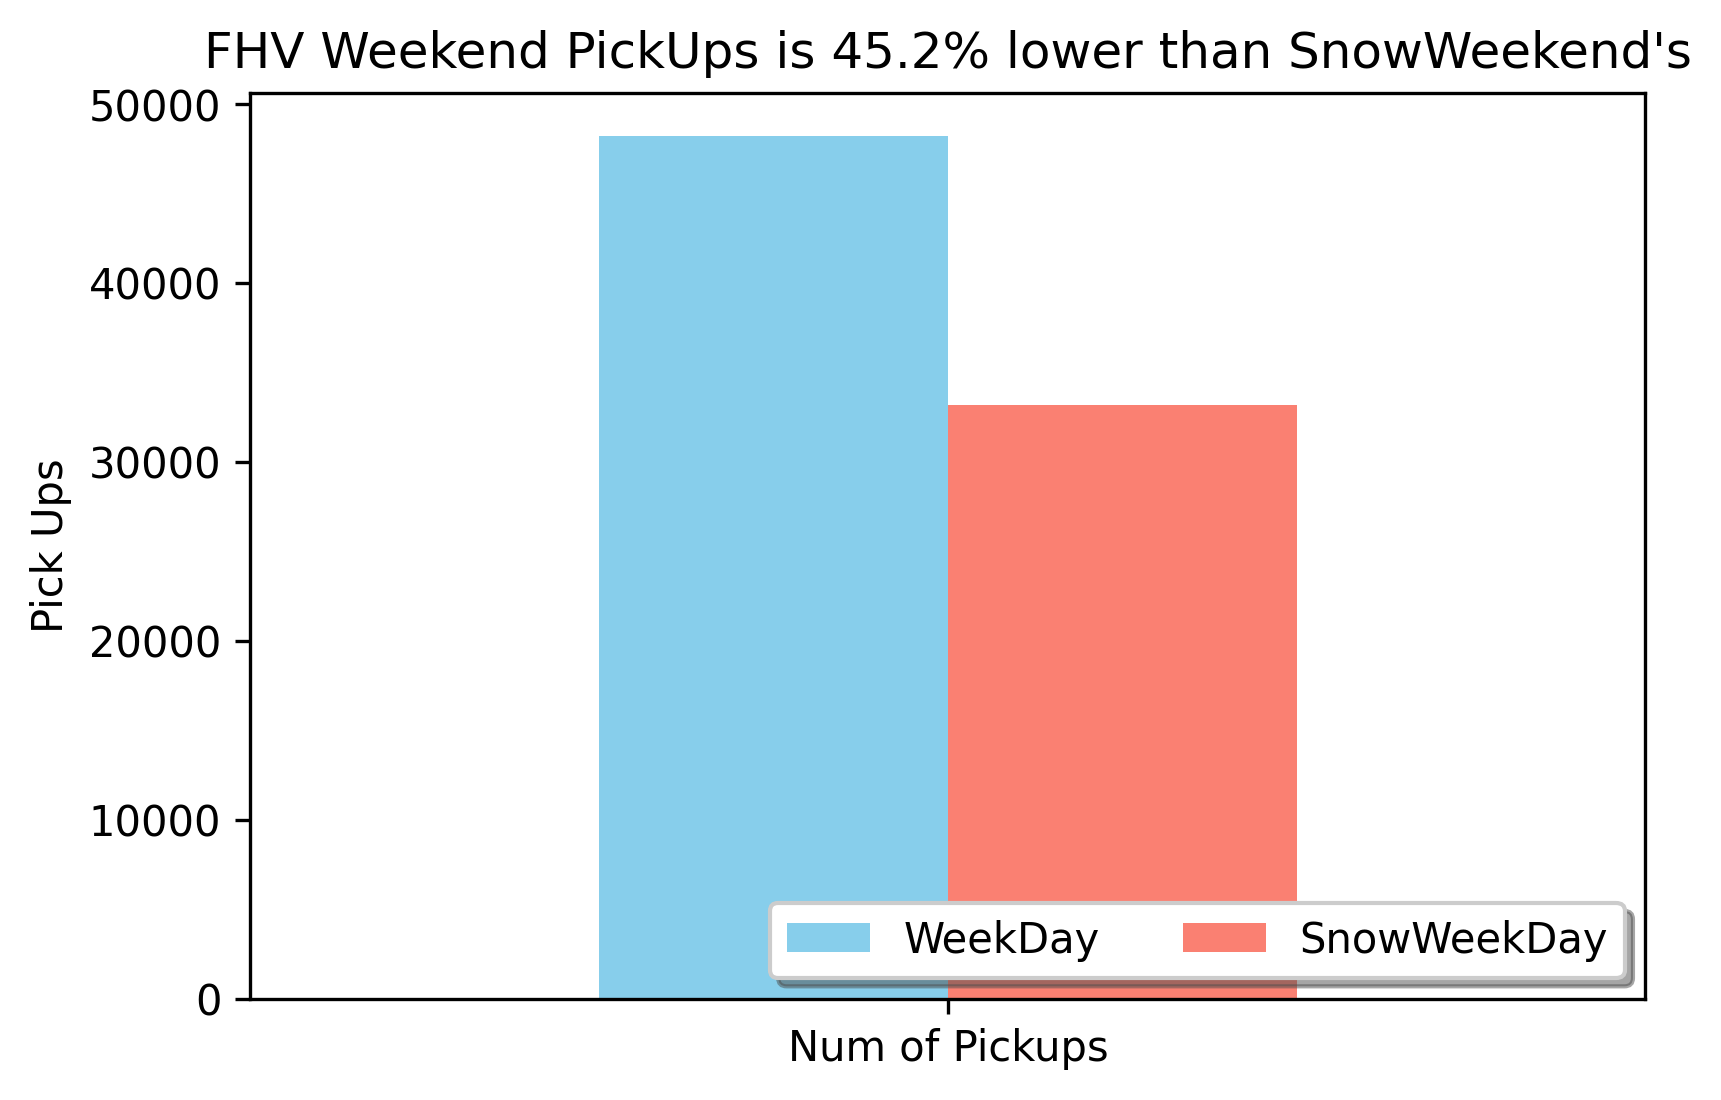

In [24]:

# WEEKDAY VS WEEKEND

# creating dataframe
df = pd.DataFrame({
    'Statistics': ['Num of Pickups'],
    'WeekDay': [
        fhv_df.loc[fhv_df['isWeekend'] == True,"NumofPickUps"].median()
                 ],
    'SnowWeekDay': [
        e_fhv_df.loc[e_fhv_df['isWeekend'] == True,"NumofPickUps"].median()
         ]
})
  
# plotting graph

fig = df.plot(
              x="Statistics",
              y=["WeekDay", "SnowWeekDay"],
              kind="bar",
              title="FHV Weekend PickUps is 45.2% lower than SnowWeekend's",
              grid=0,
                color = color
             )

fig.set_xlabel("")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

percent = (fhv_df.loc[fhv_df['isWeekend'] == True,"NumofPickUps"].median() / e_fhv_df.loc[e_fhv_df['isWeekend'] == True,"NumofPickUps"].median() - 1)*100
print(f"Weekend Travels have {np.round(percent,2)}% Drop compared with WeekDay Travels")

fig.figure.savefig('../plots/FHV_snow_impact.png')



## Weather Impact On Yellow TAXI



In [25]:
## Get Dataframe
sdf_yellow_day_data = spark.read.parquet("../preprocessed_data/yellow_daily.parquet/")
sdf_yellow_day_data = sdf_yellow_day_data.orderBy("date")
## Eyeballing and find outlier that pickups are very low after May, Mainly Because Memorial Holiday
sdf_yellow_day_data = sdf_yellow_day_data.filter(sdf_yellow_day_data["date"]<=lit("2019-05-10"))  
sdf_yellow_day_data = sdf_yellow_day_data.filter(sdf_yellow_day_data["date"]>=lit("2019-02-01"))   
y_df = sdf_yellow_day_data.toPandas()

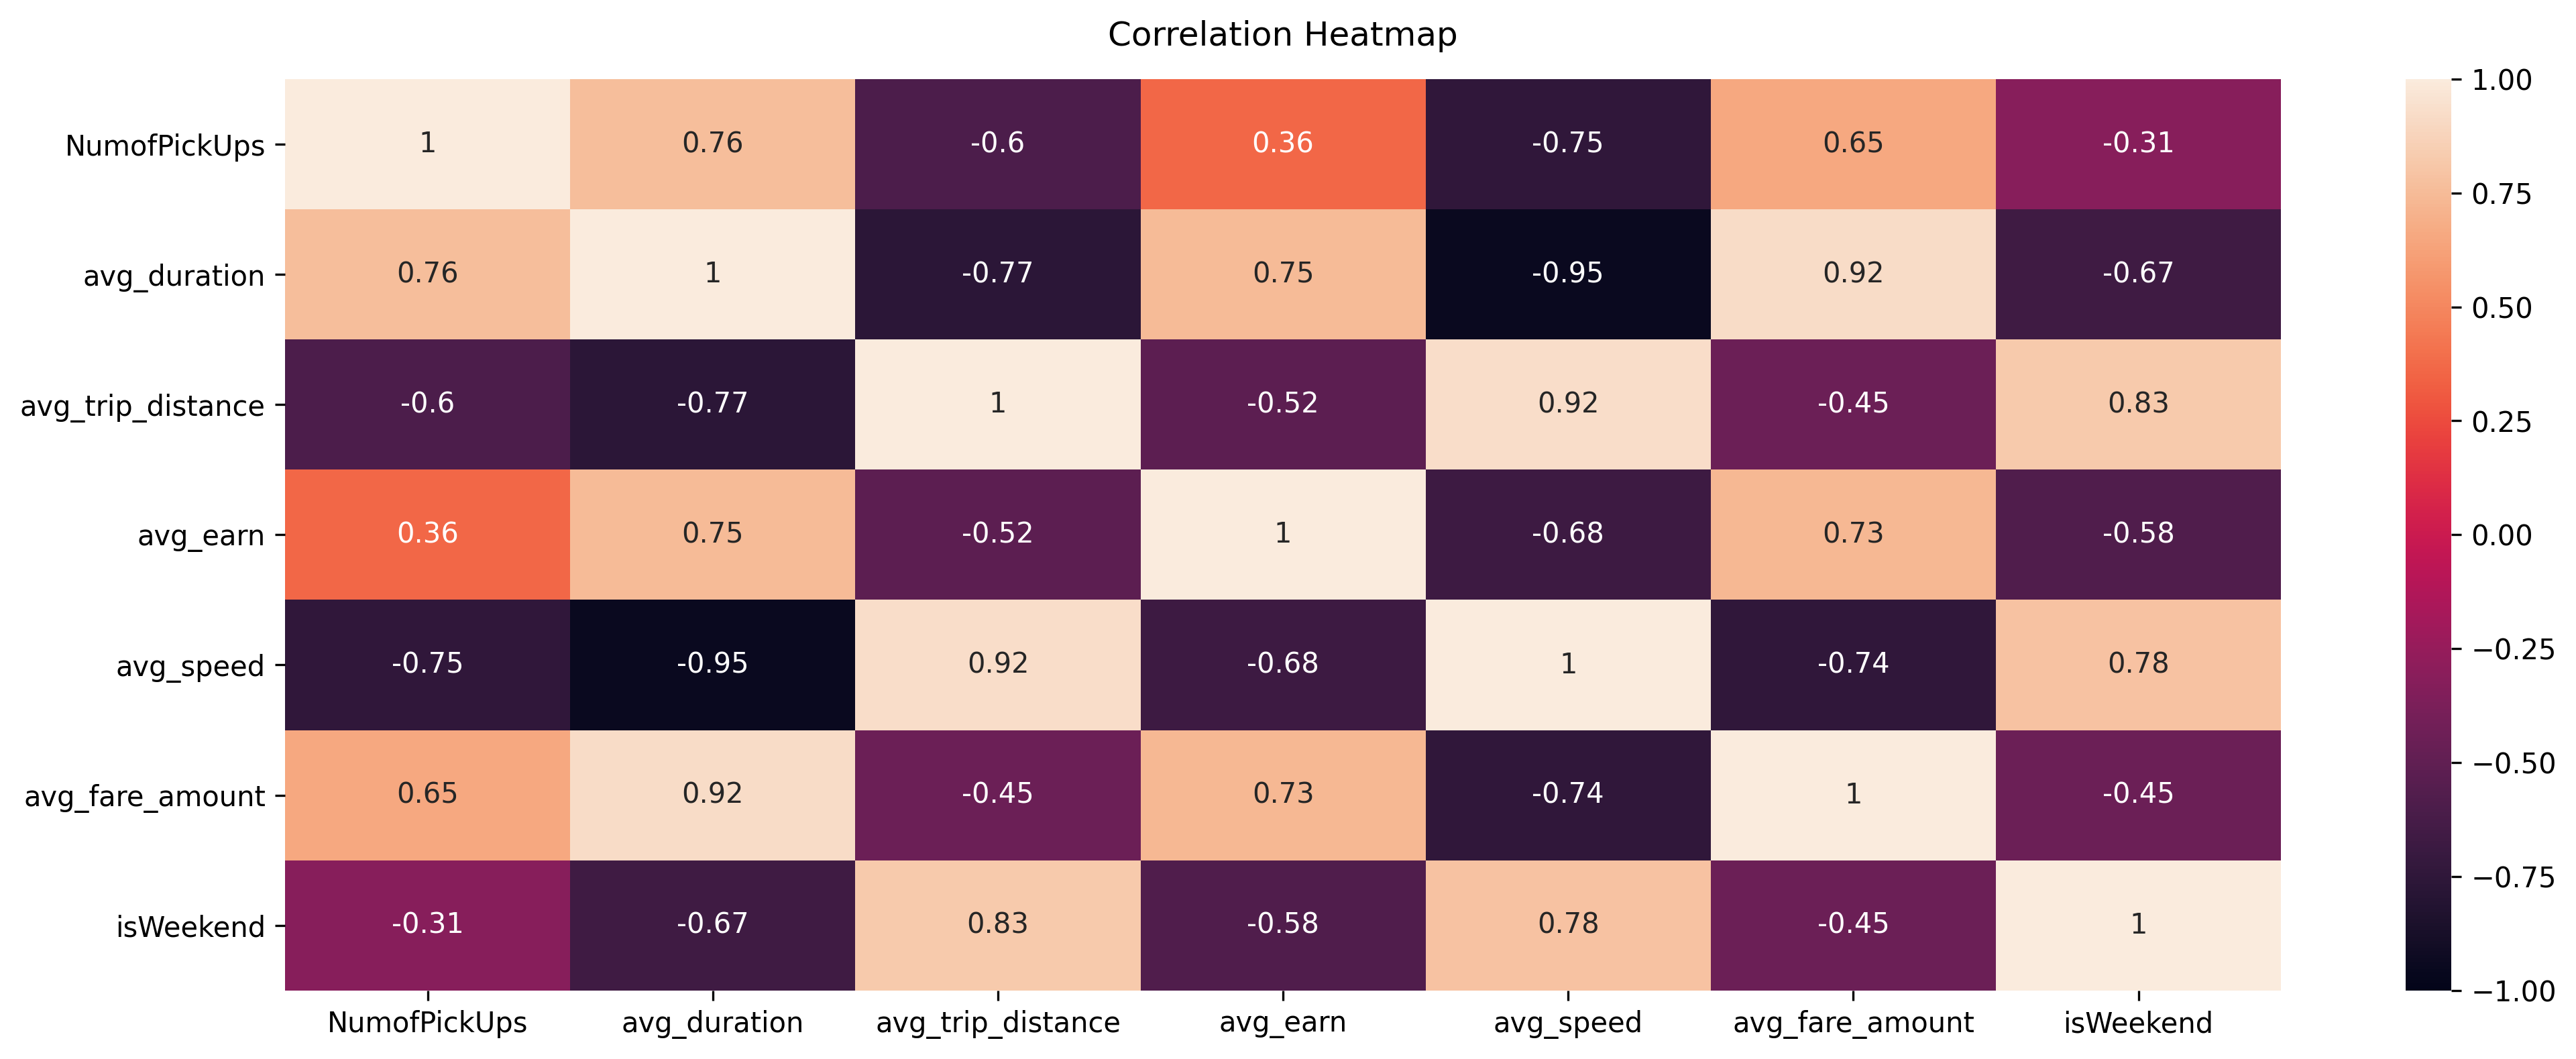

In [26]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(y_df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [27]:

## Get Extreme Day's Data

e_y_df = y_df.loc[y_df["date"].astype(str).isin(extreme_days)]
e_y_df.head(2)

,date,NumofPickUps,avg_duration,avg_trip_distance,avg_earn,avg_speed,avg_fare_amount,isWeekend,DayOfWeek
29,2019-03-02,201555,10.291,1.88903,14.352,11.57758,9.354,True,Sat
30,2019-03-03,172460,9.512,1.91364,14.028,12.60975,9.117,True,Sun


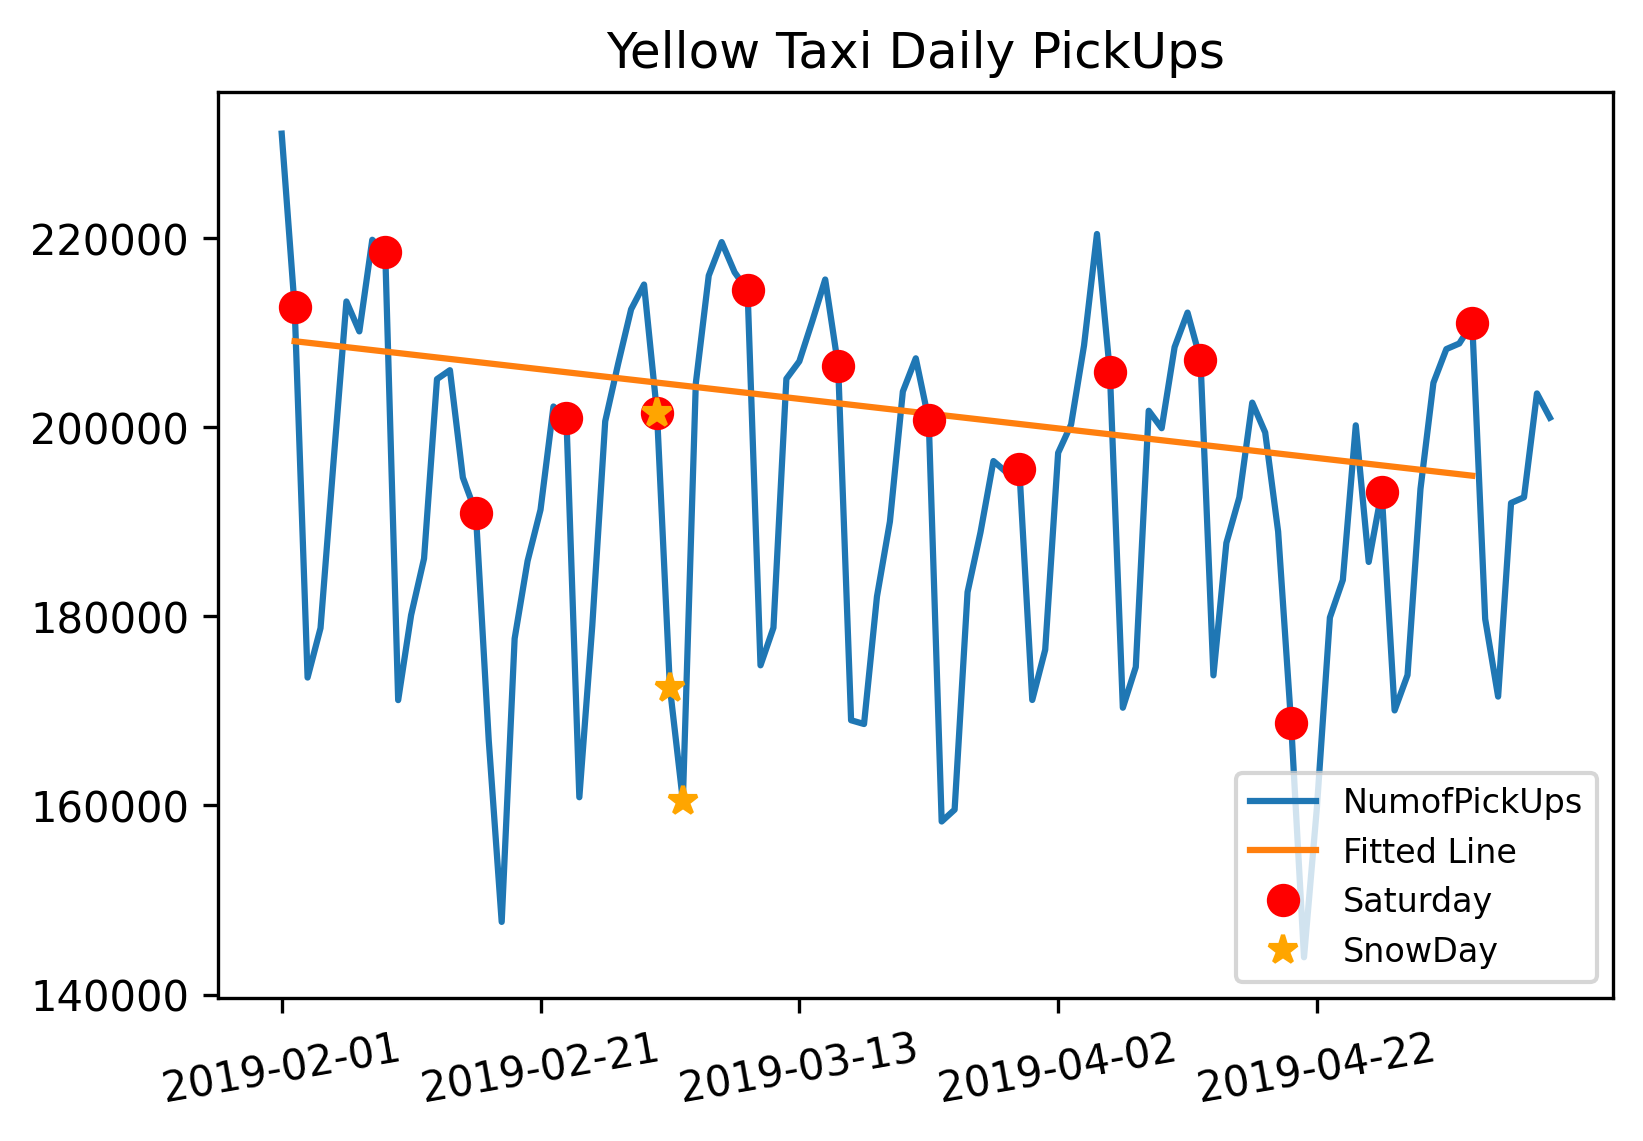

In [28]:


## Get Extreme Day's Data

e_y_df = y_df.loc[y_df["date"].astype(str).isin(extreme_days)]
e_y_df.head(2)

# Weekend data on overall

ax = y_df["NumofPickUps"].plot.line()

# Plot Linear Regression Line
x = y_df.index[fhv_df['DayOfWeek'] == "Sat"].tolist()
y = y_df.loc[fhv_df["DayOfWeek"]=="Sat"]["NumofPickUps"]

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(x, poly1d_fn(x), label="Fitted Line")

dow = plt.plot(y_df.index[y_df['DayOfWeek'] == "Sat"].tolist(),
             y_df.loc[y_df["DayOfWeek"]=="Sat"]["NumofPickUps"], 
             marker='o', markersize=7, color="red", label='Saturday', linestyle = 'None')


Snow = plt.plot(e_y_df.index.tolist(),
             e_y_df["NumofPickUps"], 
             marker='*', markersize=7, color="orange", label='SnowDay', linestyle = 'None')


plt.xticks(np.arange(fhv_df.shape[0])[::20], fhv_df.date[::20], rotation=10)

plt.legend(
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=8)

plt.title("Yellow Taxi Daily PickUps")

plt.savefig("../plots/Yellow_Time_PickUp.png")

plt.show()

Weekend Travels have 12.77% Drop compared with WeekDay Travels


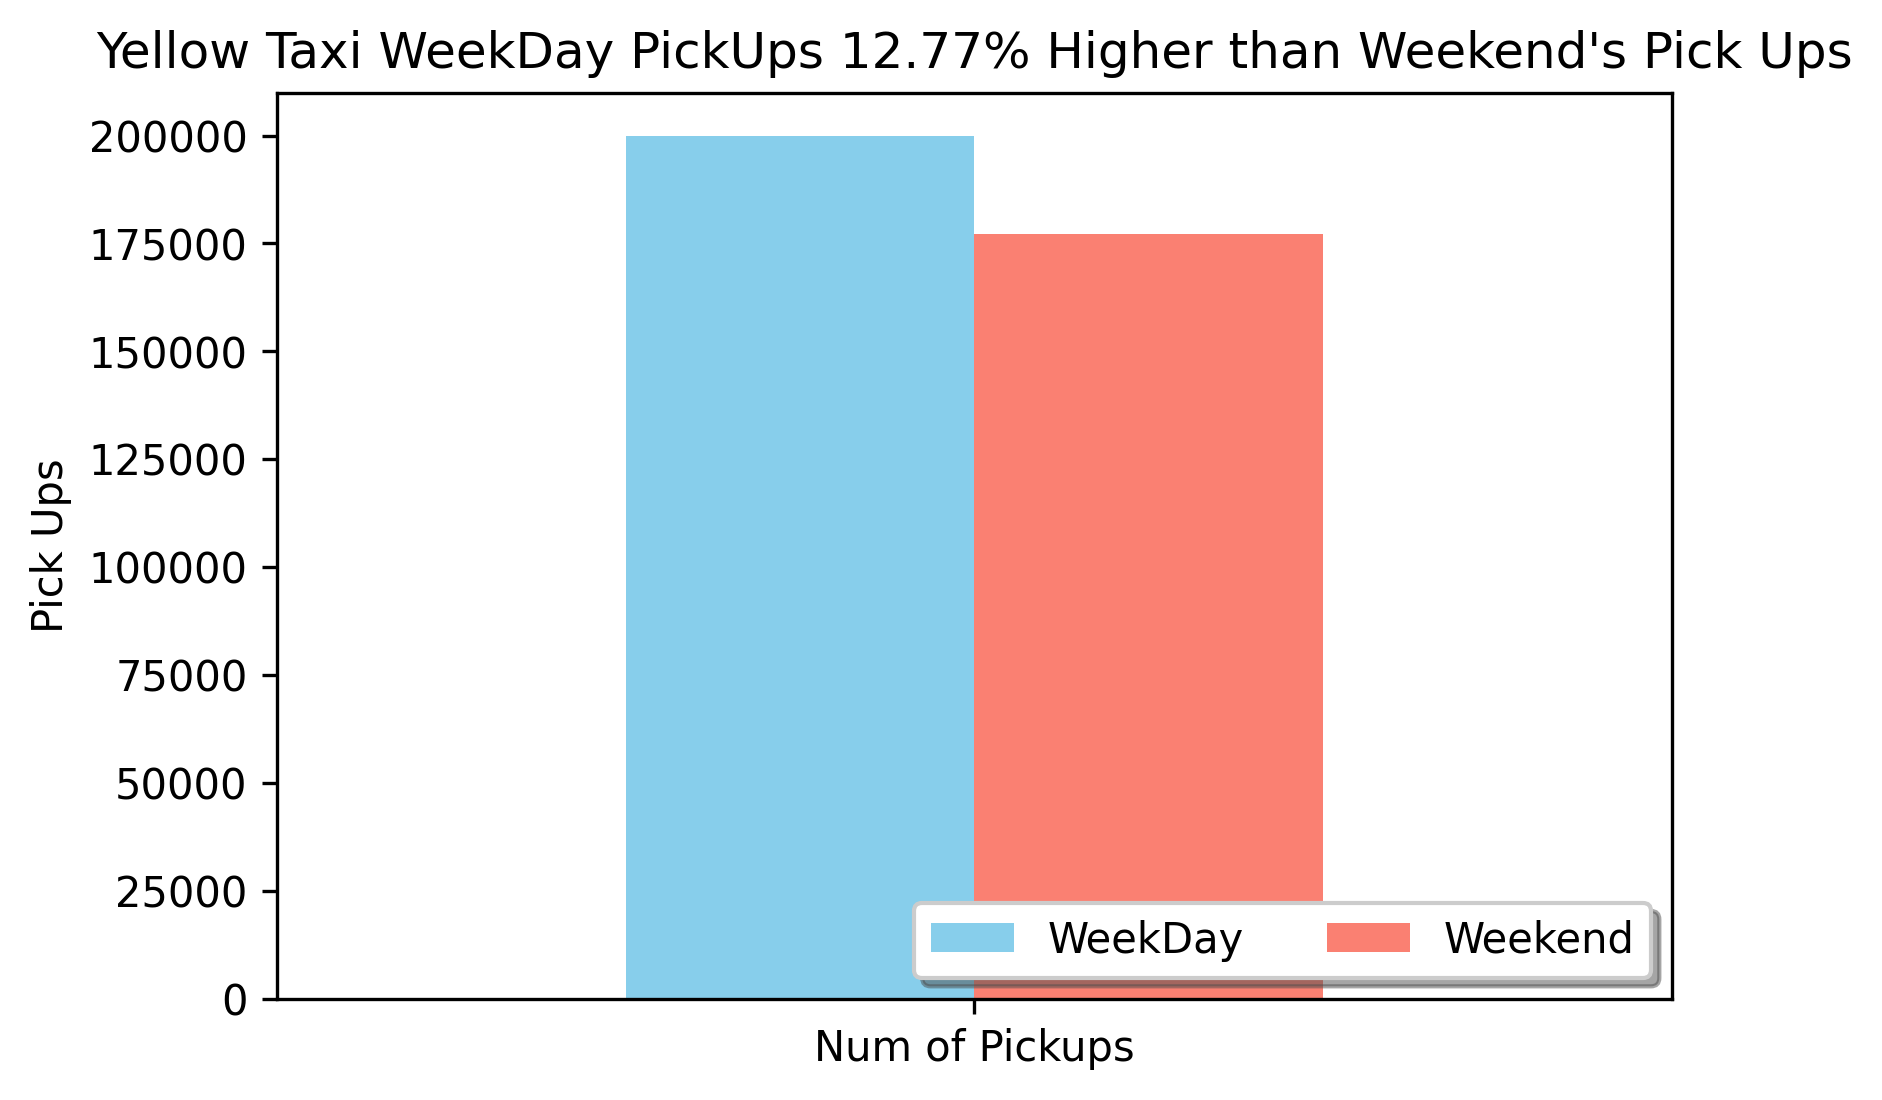

In [29]:
# WEEKDAY VS WEEKEND

# creating dataframe
df = pd.DataFrame({
    'Statistics': ['Num of Pickups'],
    'WeekDay': [
        y_df.loc[y_df['isWeekend'] == False,"NumofPickUps"].median()
                 ],
    'Weekend': [
        y_df.loc[y_df['isWeekend'] == True,"NumofPickUps"].median()
         ]
})
  
# plotting graph

fig = df.plot(
              x="Statistics",
              y=["WeekDay", "Weekend"],
              kind="bar",
              title="Yellow Taxi WeekDay PickUps 12.77% Higher than Weekend's Pick Ups",
              grid=0,
                color = color
             )

fig.set_xlabel("")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

percent = (y_df.loc[y_df['isWeekend'] == False,"NumofPickUps"].median() / y_df.loc[y_df['isWeekend'] == True,"NumofPickUps"].median() - 1)*100
print(f"Weekend Travels have {np.round(percent,2)}% Drop compared with WeekDay Travels")

fig.figure.savefig('../plots/Y_Weekday_Vs_Weekend_PickUps_Overall.png')

In [30]:
y_df

,date,NumofPickUps,avg_duration,avg_trip_distance,avg_earn,avg_speed,avg_fare_amount,isWeekend,DayOfWeek
0,2019-02-01,231065,11.085,1.73666,12.278,10.04714,9.496,False,Fri
1,2019-02-02,212681,10.329,1.83799,13.801,11.40007,9.336,True,Sat
2,2019-02-03,173534,9.454,1.95224,14.118,12.93129,9.177,True,Sun
3,2019-02-04,178765,10.355,1.81624,14.575,11.20141,9.324,False,Mon
4,2019-02-05,196263,10.853,1.80001,14.839,10.64140,9.498,False,Tue
...,...,...,...,...,...,...,...,...,...
94,2019-05-06,171520,10.775,1.81554,14.833,10.94314,9.531,False,Mon
95,2019-05-07,191999,11.250,1.78609,15.040,10.32898,9.666,False,Tue
96,2019-05-08,192598,11.572,1.79828,15.242,10.23370,9.842,False,Wed
97,2019-05-09,203586,11.712,1.78402,15.290,10.01195,9.871,False,Thu


Extreme Weather Causes 24.54% Drop On WEEKDAY Travels


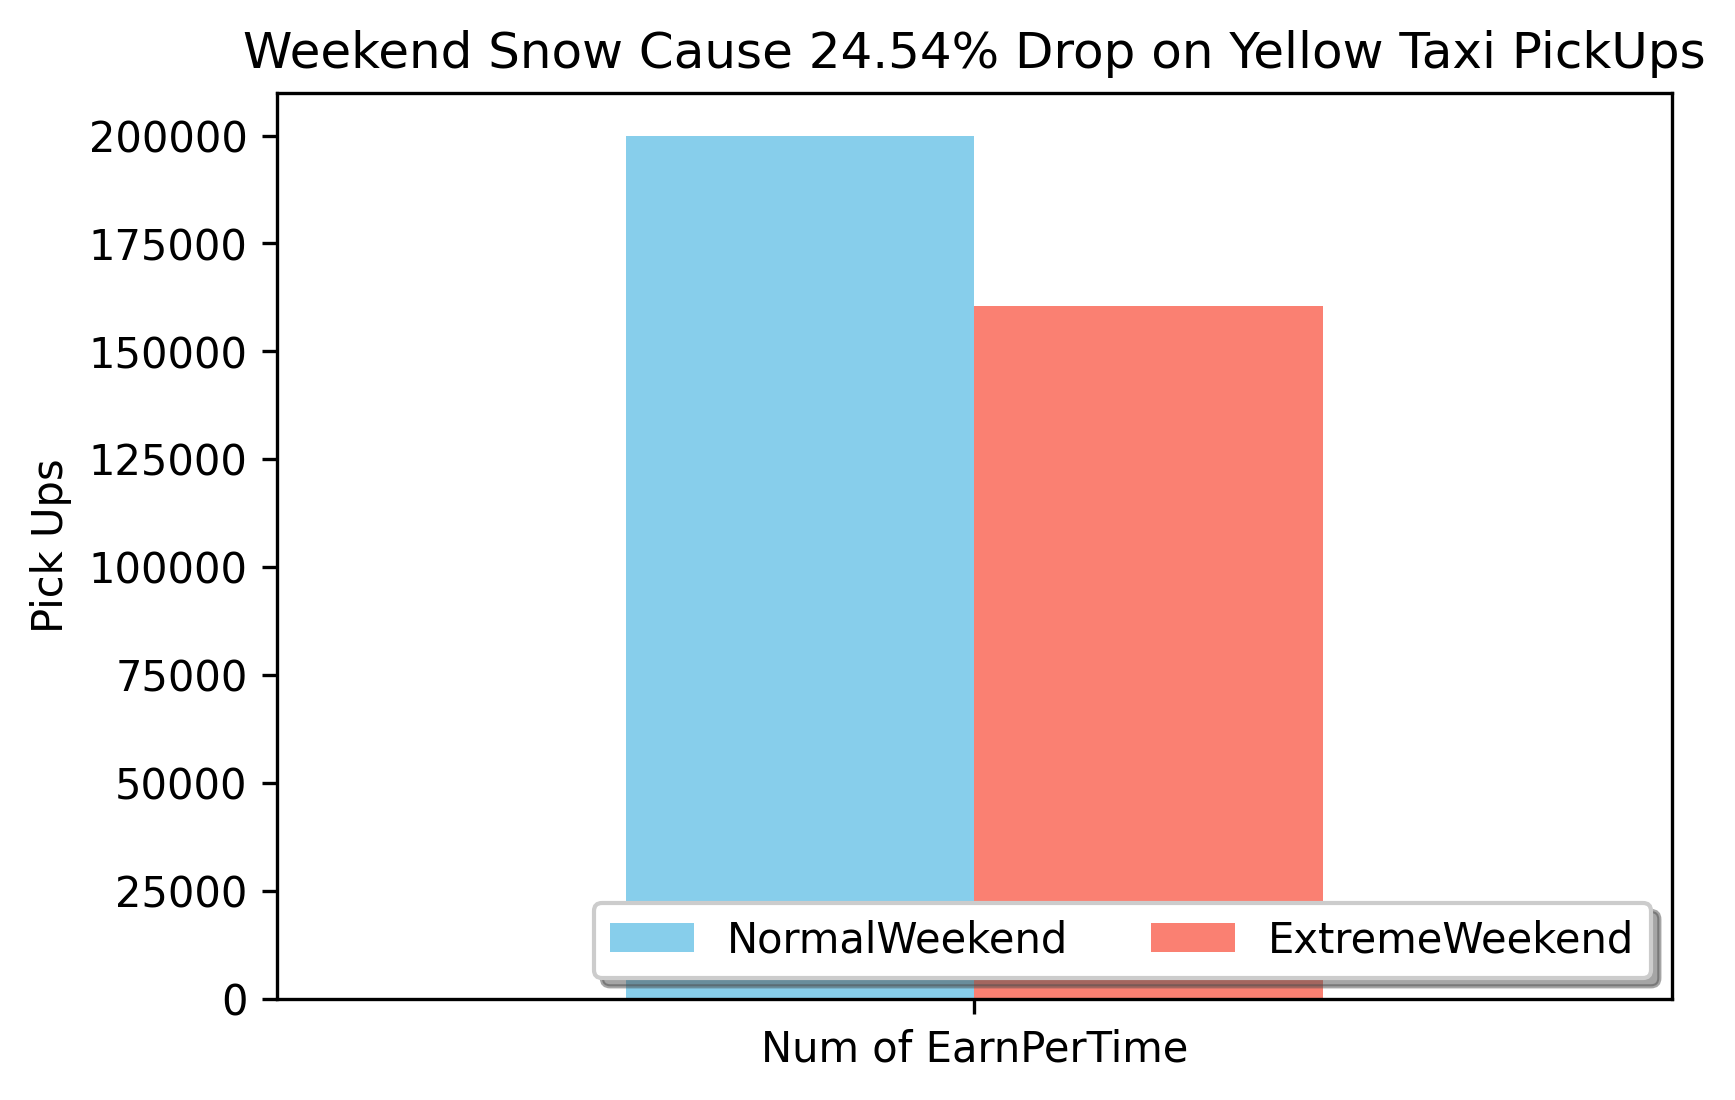

In [31]:
# WEEKDAY Extreme Weather Impact
# NumofPickUps avg_duration	avg_trip_distance	avg_earn	avg_speed	avg_fare_amount
y1 = y_df.loc[y_df['isWeekend'] == False,"NumofPickUps"].median()
y2 = e_y_df.loc[e_y_df['isWeekend'] == False,"NumofPickUps"].median()

# creating dataframe
df = pd.DataFrame({
    'Statistics': ['Num of EarnPerTime'],
    'NormalWeekend': [
        y1
                 ],
    'ExtremeWeekend': [
        y2
         ]
})
  
# plotting graph

fig = df.plot(
              x="Statistics",
              y=["NormalWeekend", "ExtremeWeekend"],
              kind="bar",
              title="Weekend Snow Cause 24.54% Drop on Yellow Taxi PickUps",
              grid=0, color = color
             )

fig.set_xlabel("")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

percent = (y1/y2 - 1)*100
print(f"Extreme Weather Causes {np.round(percent,2)}% Drop On WEEKDAY Travels")

fig.figure.savefig('../plots/Y_Weekday_Vs_Weekend.png')

In [32]:
### Day of Week Summary (GroupBy DOW)
        
WEEKDAY = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

## Exclude Holiday as it may distort the result
#NormalDay
dow_df_pre_normal = y_df.loc[~isHoliday(y_df["date"])]
dow_df_normal = y_df.groupby("DayOfWeek").median().reindex(WEEKDAY) 

#ExtremeWeather
dow_df_pre_extreme = e_y_df.loc[~isHoliday(e_y_df["date"])]
dow_df_extreme = e_y_df.groupby("DayOfWeek").median().reindex(WEEKDAY) 

#Holiday
dow_df_holiday = y_df.loc[isHoliday(y_df["date"])].groupby("DayOfWeek").median().reindex(WEEKDAY) 

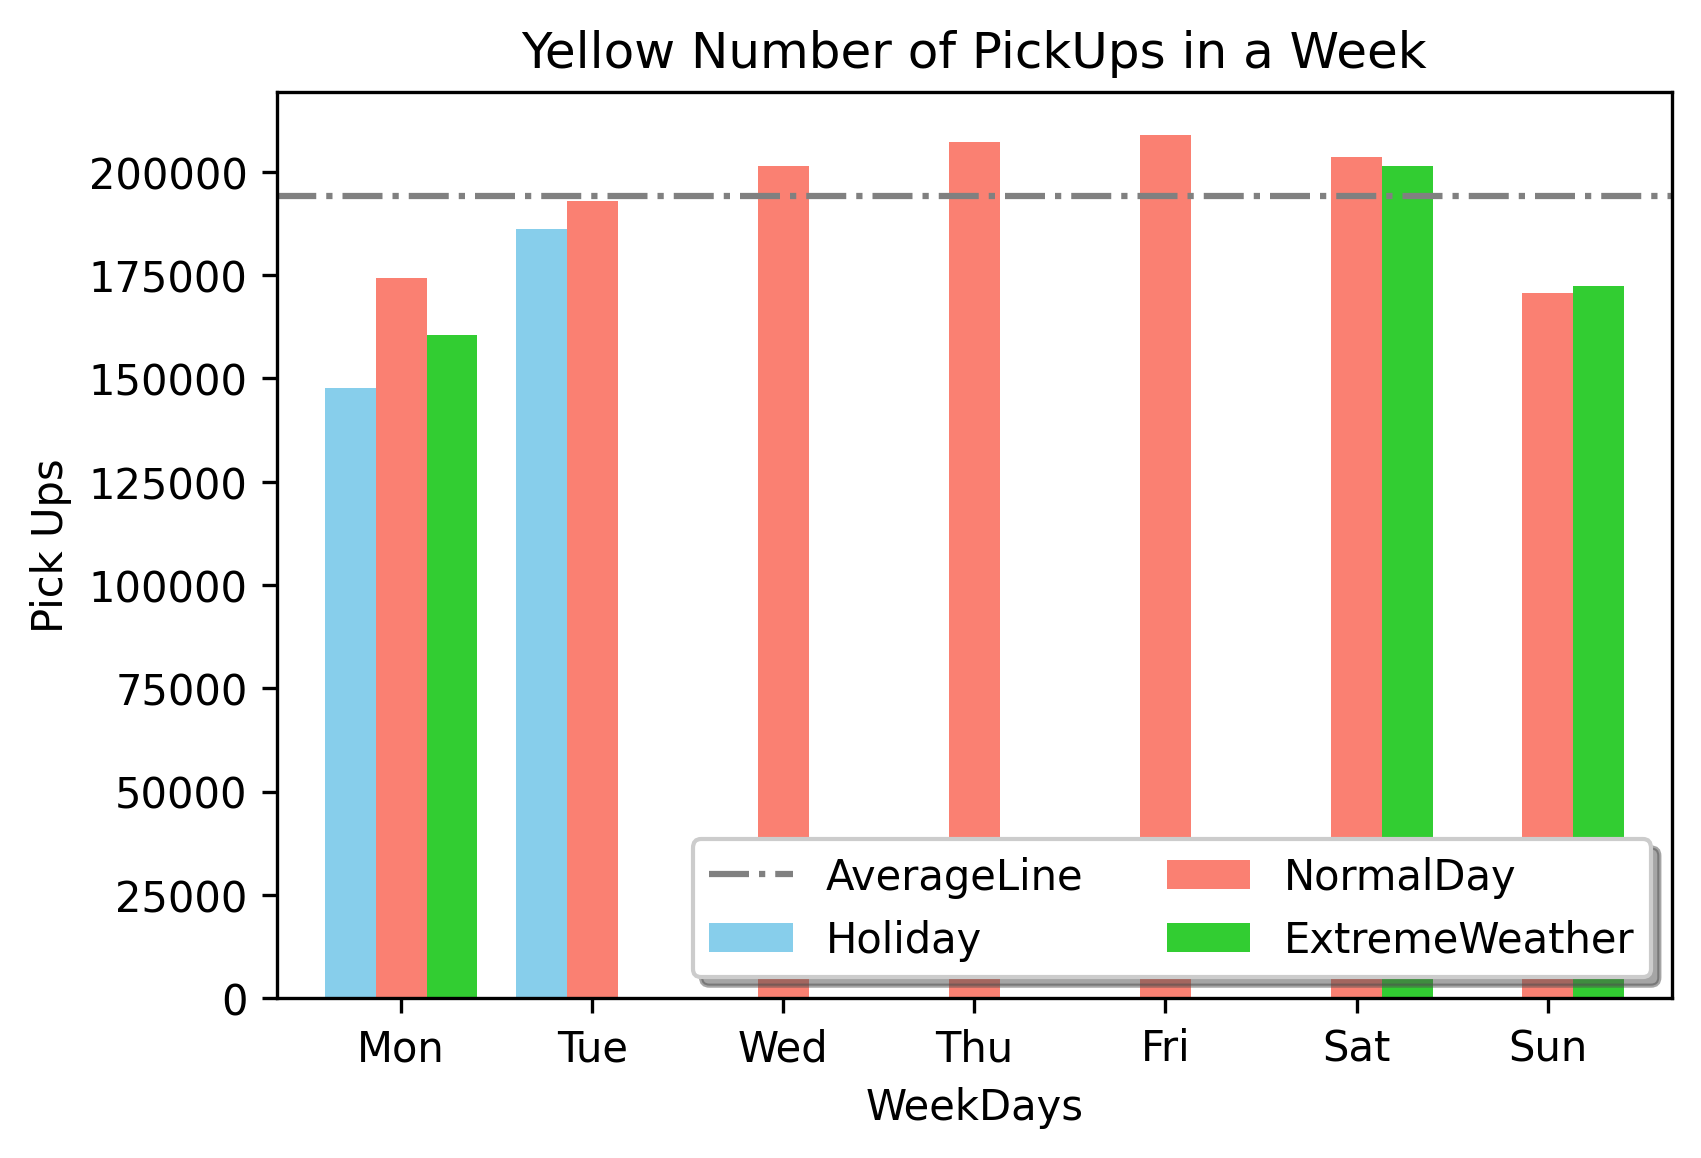

In [33]:
# Week Day Extreme VS Normal Pickups
x = WEEKDAY

y1 = dow_df_normal["NumofPickUps"]
y2 = dow_df_extreme["NumofPickUps"]
y3 = dow_df_holiday["NumofPickUps"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=['Holiday', "NormalDay", "ExtremeWeather", ],
              kind="bar",
              title="Yellow Number of PickUps in a Week",
              grid=0,
              width=0.8,
                color = color
             )

line_x = np.linspace(-1, 10,7)

# AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")



fig.set_xlabel("WeekDays")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

fig.figure.savefig('../plots/Yellow_Weekly.png')

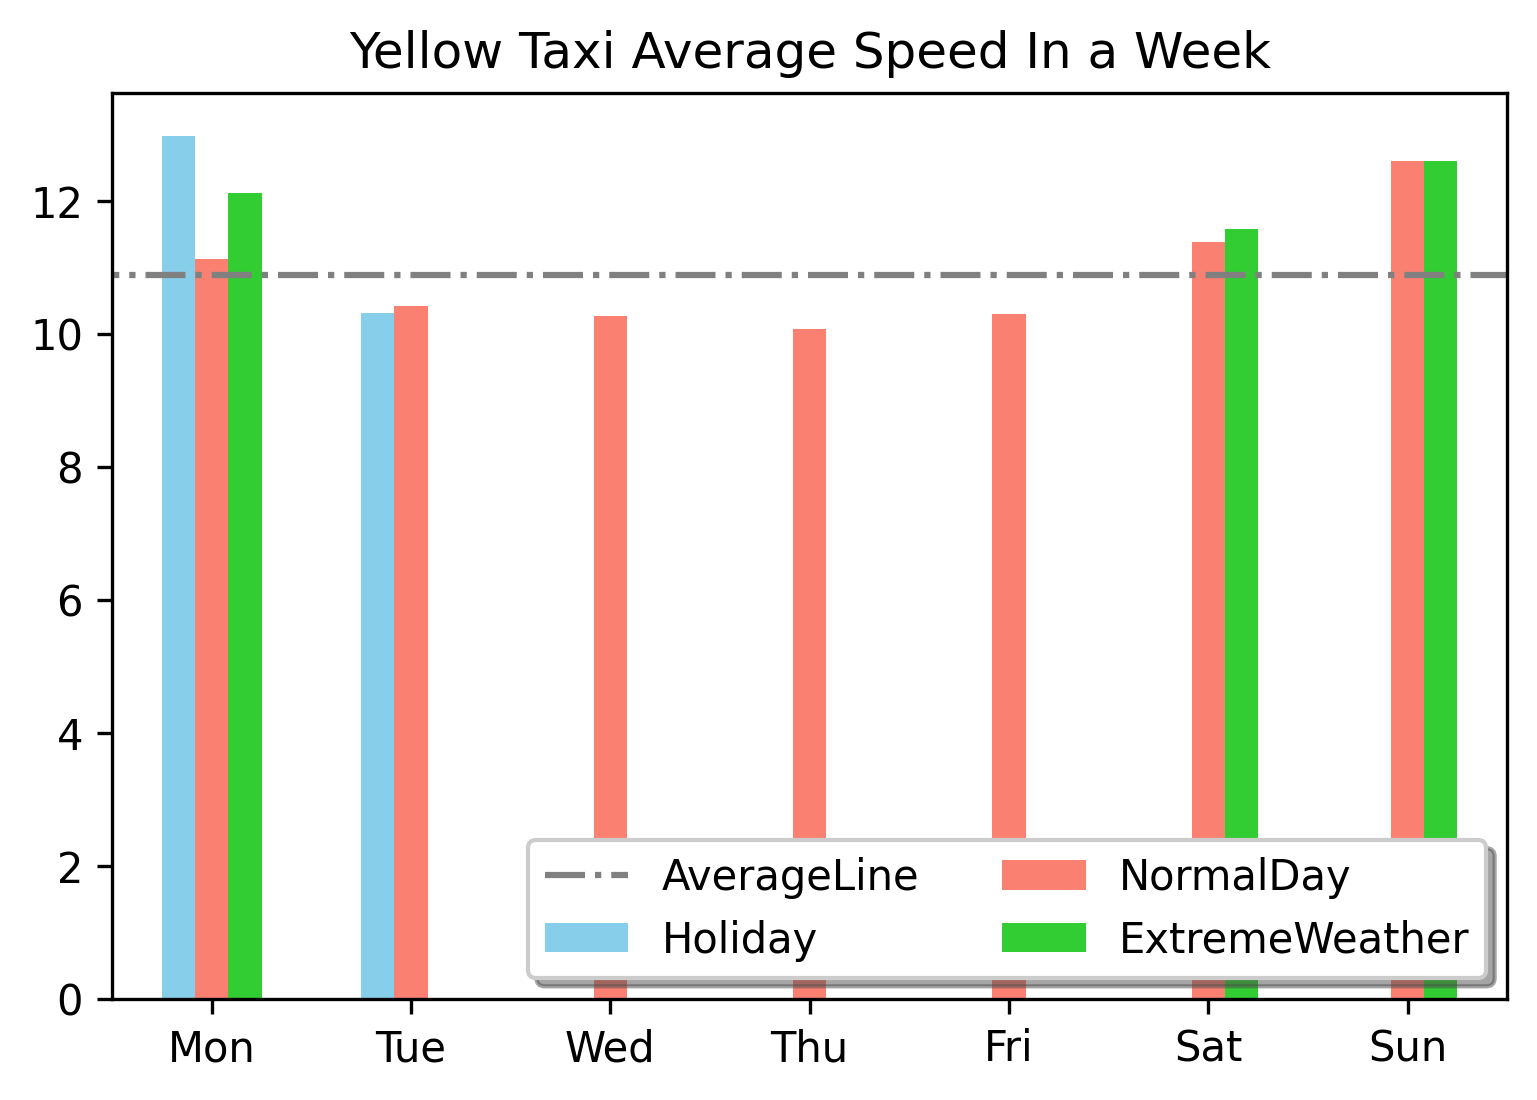

In [34]:
# Week Day Extreme VS Normal Pickups
x = WEEKDAY

y1 = dow_df_normal["avg_speed"]
y2 = dow_df_extreme["avg_speed"]
y3 = dow_df_holiday["avg_speed"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=["Holiday", "NormalDay", "ExtremeWeather"],
              kind="bar",
              title="Yellow Taxi Average Speed In a Week",
              grid=0,color=color
             )

#AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")

fig.set_xlabel("")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

fig.figure.savefig('../plots/yellow_Speed_Week.png')

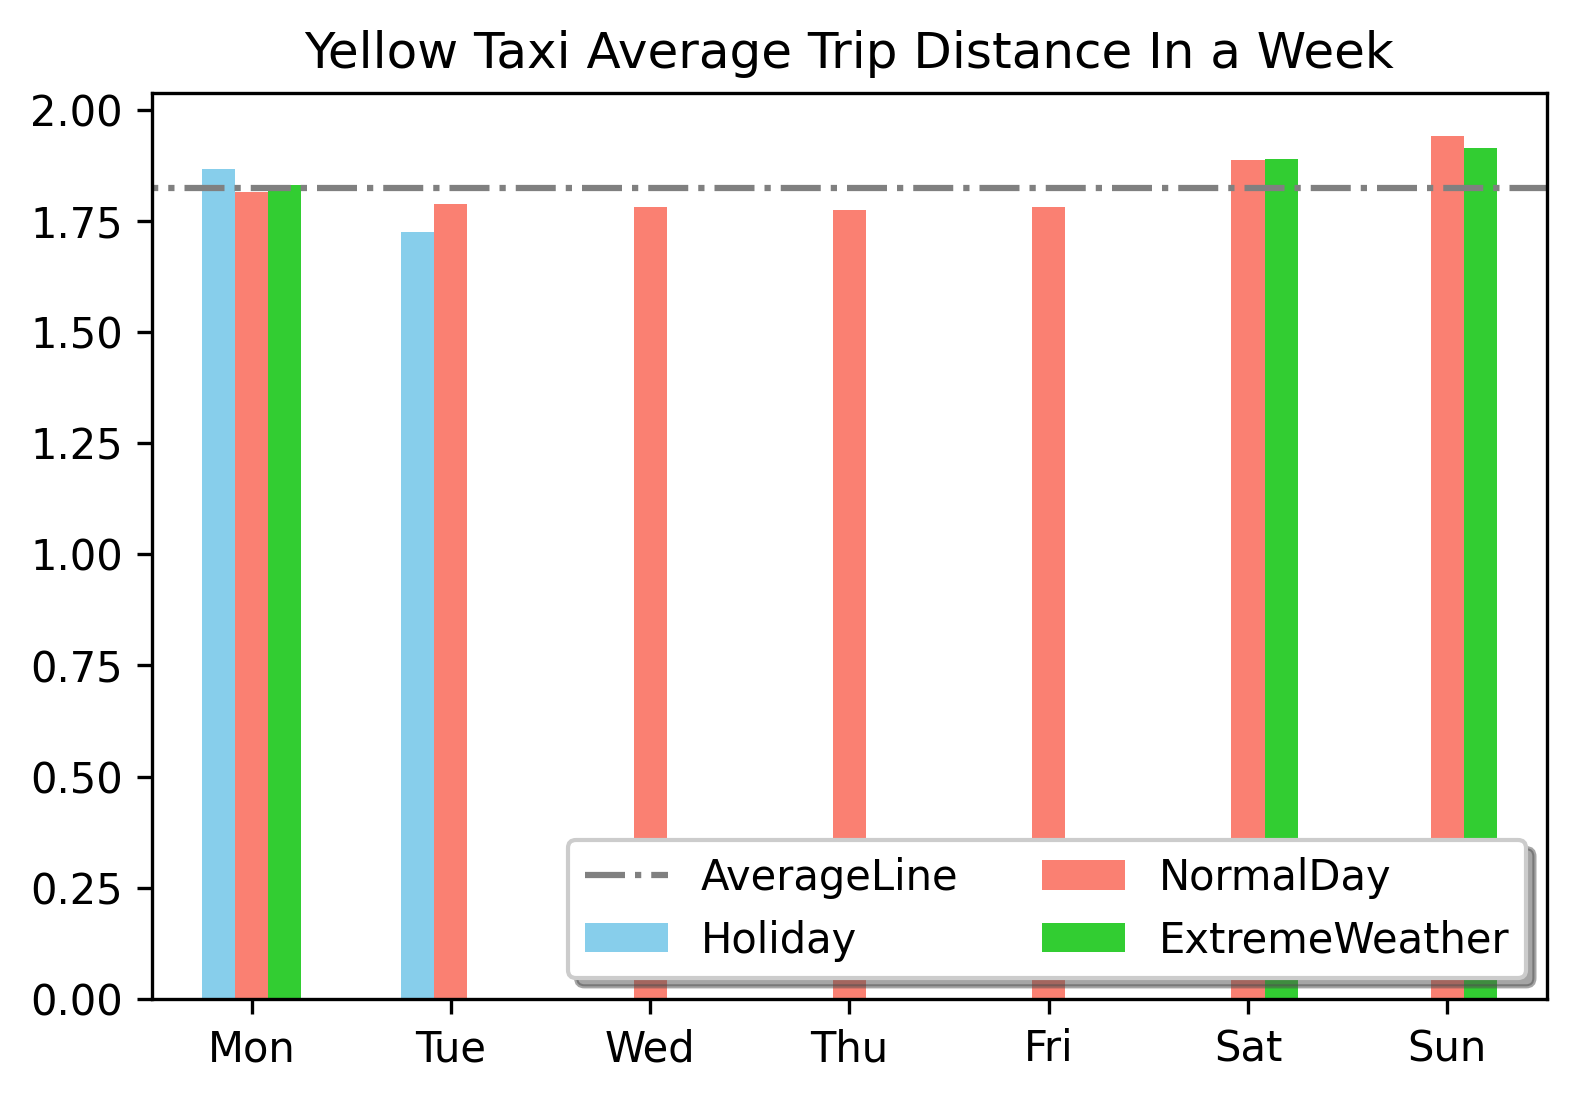

In [35]:
# Week Day Extreme VS Normal Pickups
x = WEEKDAY

y1 = dow_df_normal["avg_trip_distance"]
y2 = dow_df_extreme["avg_trip_distance"]
y3 = dow_df_holiday["avg_trip_distance"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=["Holiday", "NormalDay", "ExtremeWeather"],
              kind="bar",
              title="Yellow Taxi Average Trip Distance In a Week",
              grid=0,color=color
             )
#AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")

fig.set_xlabel("")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

fig.figure.savefig('../plots/yellow_distance_week.png')

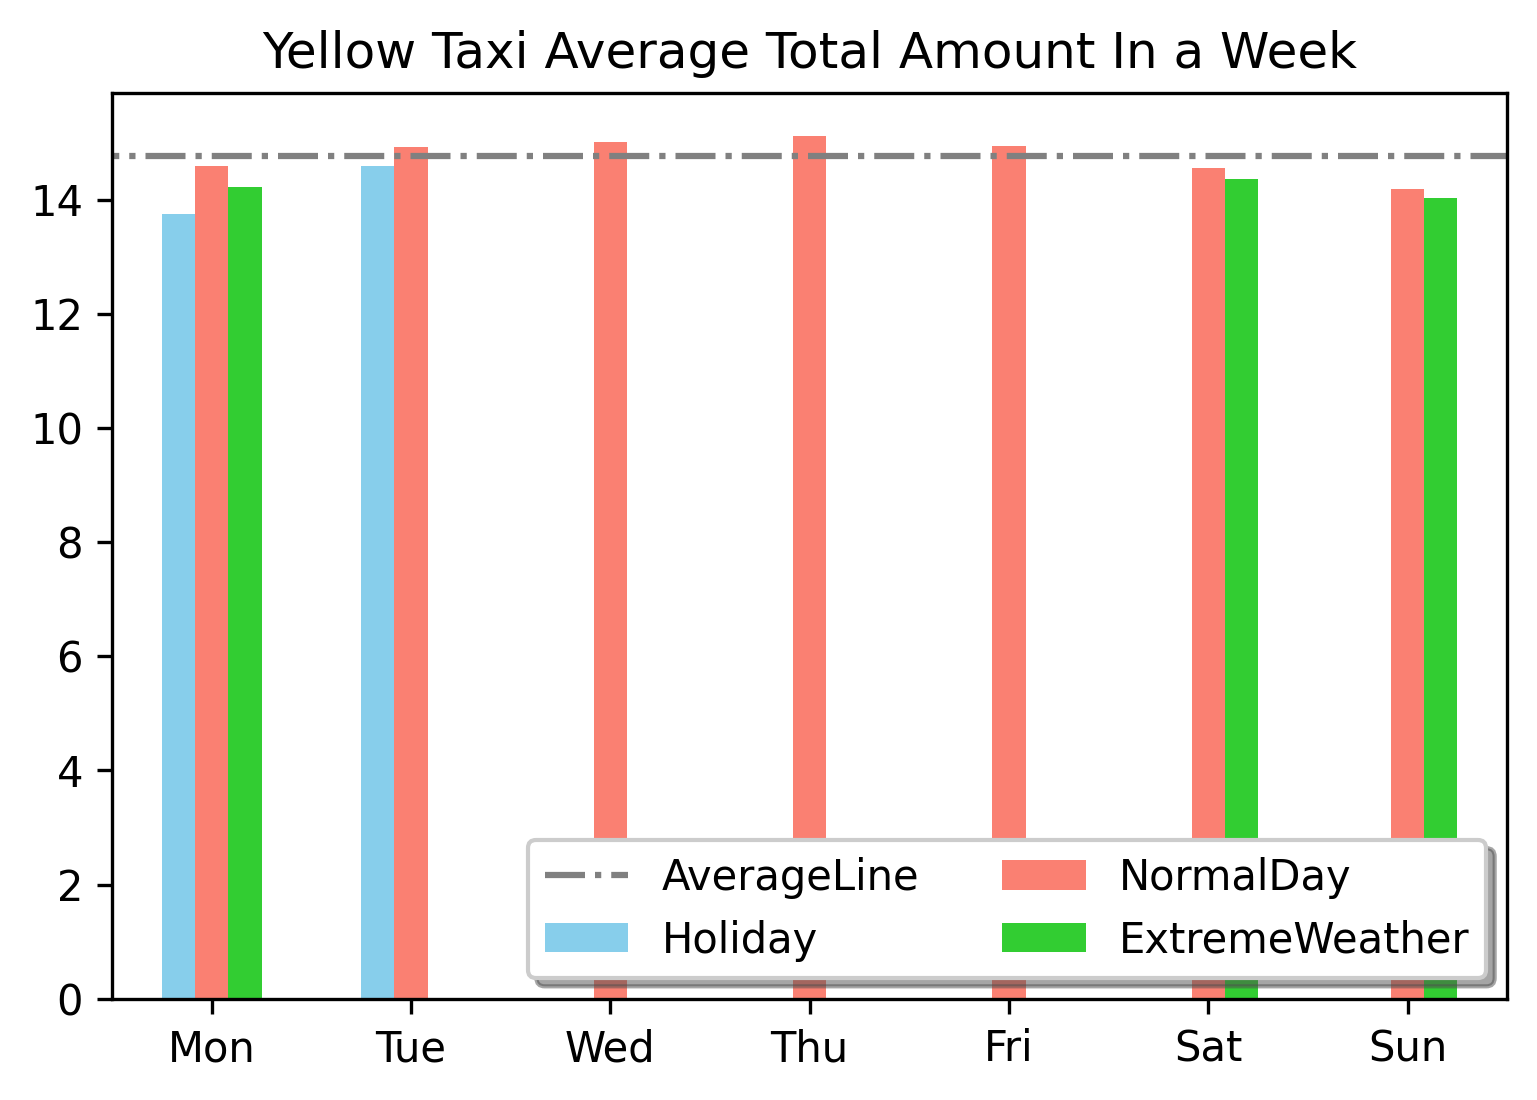

In [36]:
# Week Day Extreme VS Normal Pickups
x = WEEKDAY

y1 = dow_df_normal["avg_earn"]
y2 = dow_df_extreme["avg_earn"]
y3 = dow_df_holiday["avg_earn"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=["Holiday", "NormalDay", "ExtremeWeather"],
              kind="bar",
              title="Yellow Taxi Average Total Amount In a Week",
              grid=0,color=color
             )

#AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")


fig.set_xlabel("")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

fig.figure.savefig('../plots/Yellow_Total_Amount_Weekly.png')

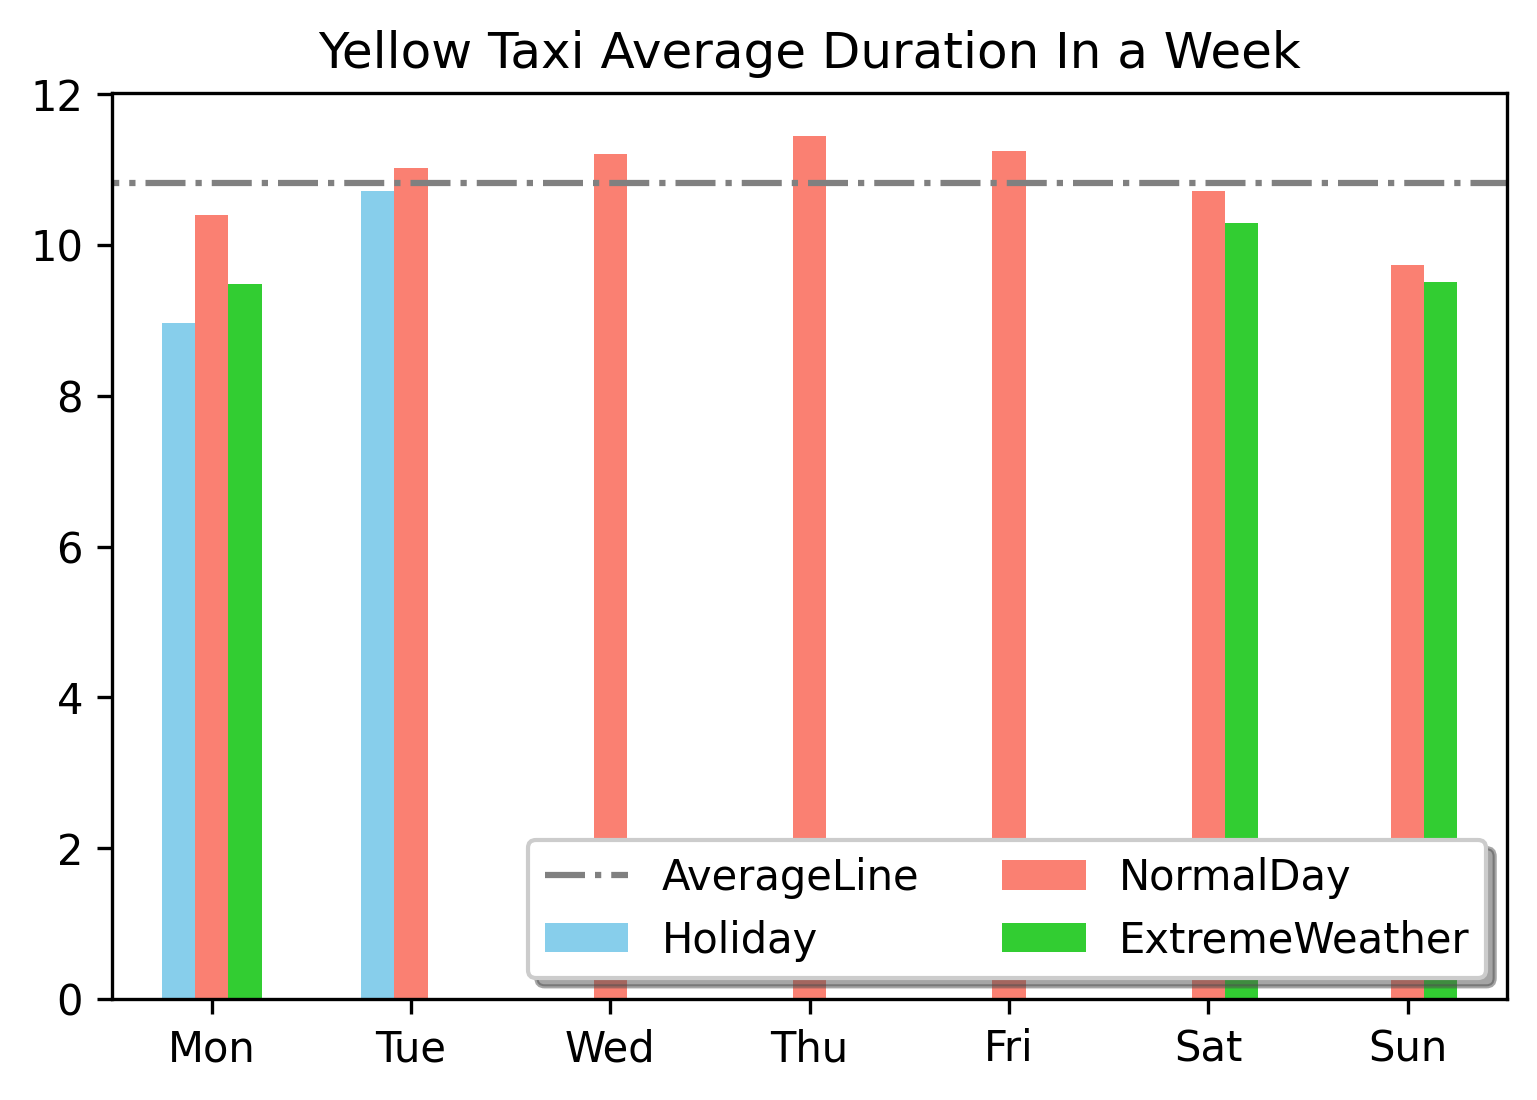

In [37]:
# Week Day Extreme VS Normal Pickups
x = WEEKDAY

y1 = dow_df_normal["avg_duration"]
y2 = dow_df_extreme["avg_duration"]
y3 = dow_df_holiday["avg_duration"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=["Holiday", "NormalDay", "ExtremeWeather"],
              kind="bar",
              title="Yellow Taxi Average Duration In a Week",
              grid=0,color=color
             )

#AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")


fig.set_xlabel("")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

fig.figure.savefig('../plots/yellow_duration_week.png')

## Green Taxi And Extreme Weather

In [38]:
## Get Dataframe
sdf_yellow_day_data = spark.read.parquet("../preprocessed_data/green_daily.parquet/")
sdf_yellow_day_data = sdf_yellow_day_data.orderBy("date")
## Eyeballing and find outlier that pickups are very low after May, Mainly Because Memorial Holiday
sdf_yellow_day_data = sdf_yellow_day_data.filter(sdf_yellow_day_data["date"]<=lit("2019-05-10"))  
sdf_yellow_day_data = sdf_yellow_day_data.filter(sdf_yellow_day_data["date"]>=lit("2019-02-01"))   
y_df = sdf_yellow_day_data.toPandas()

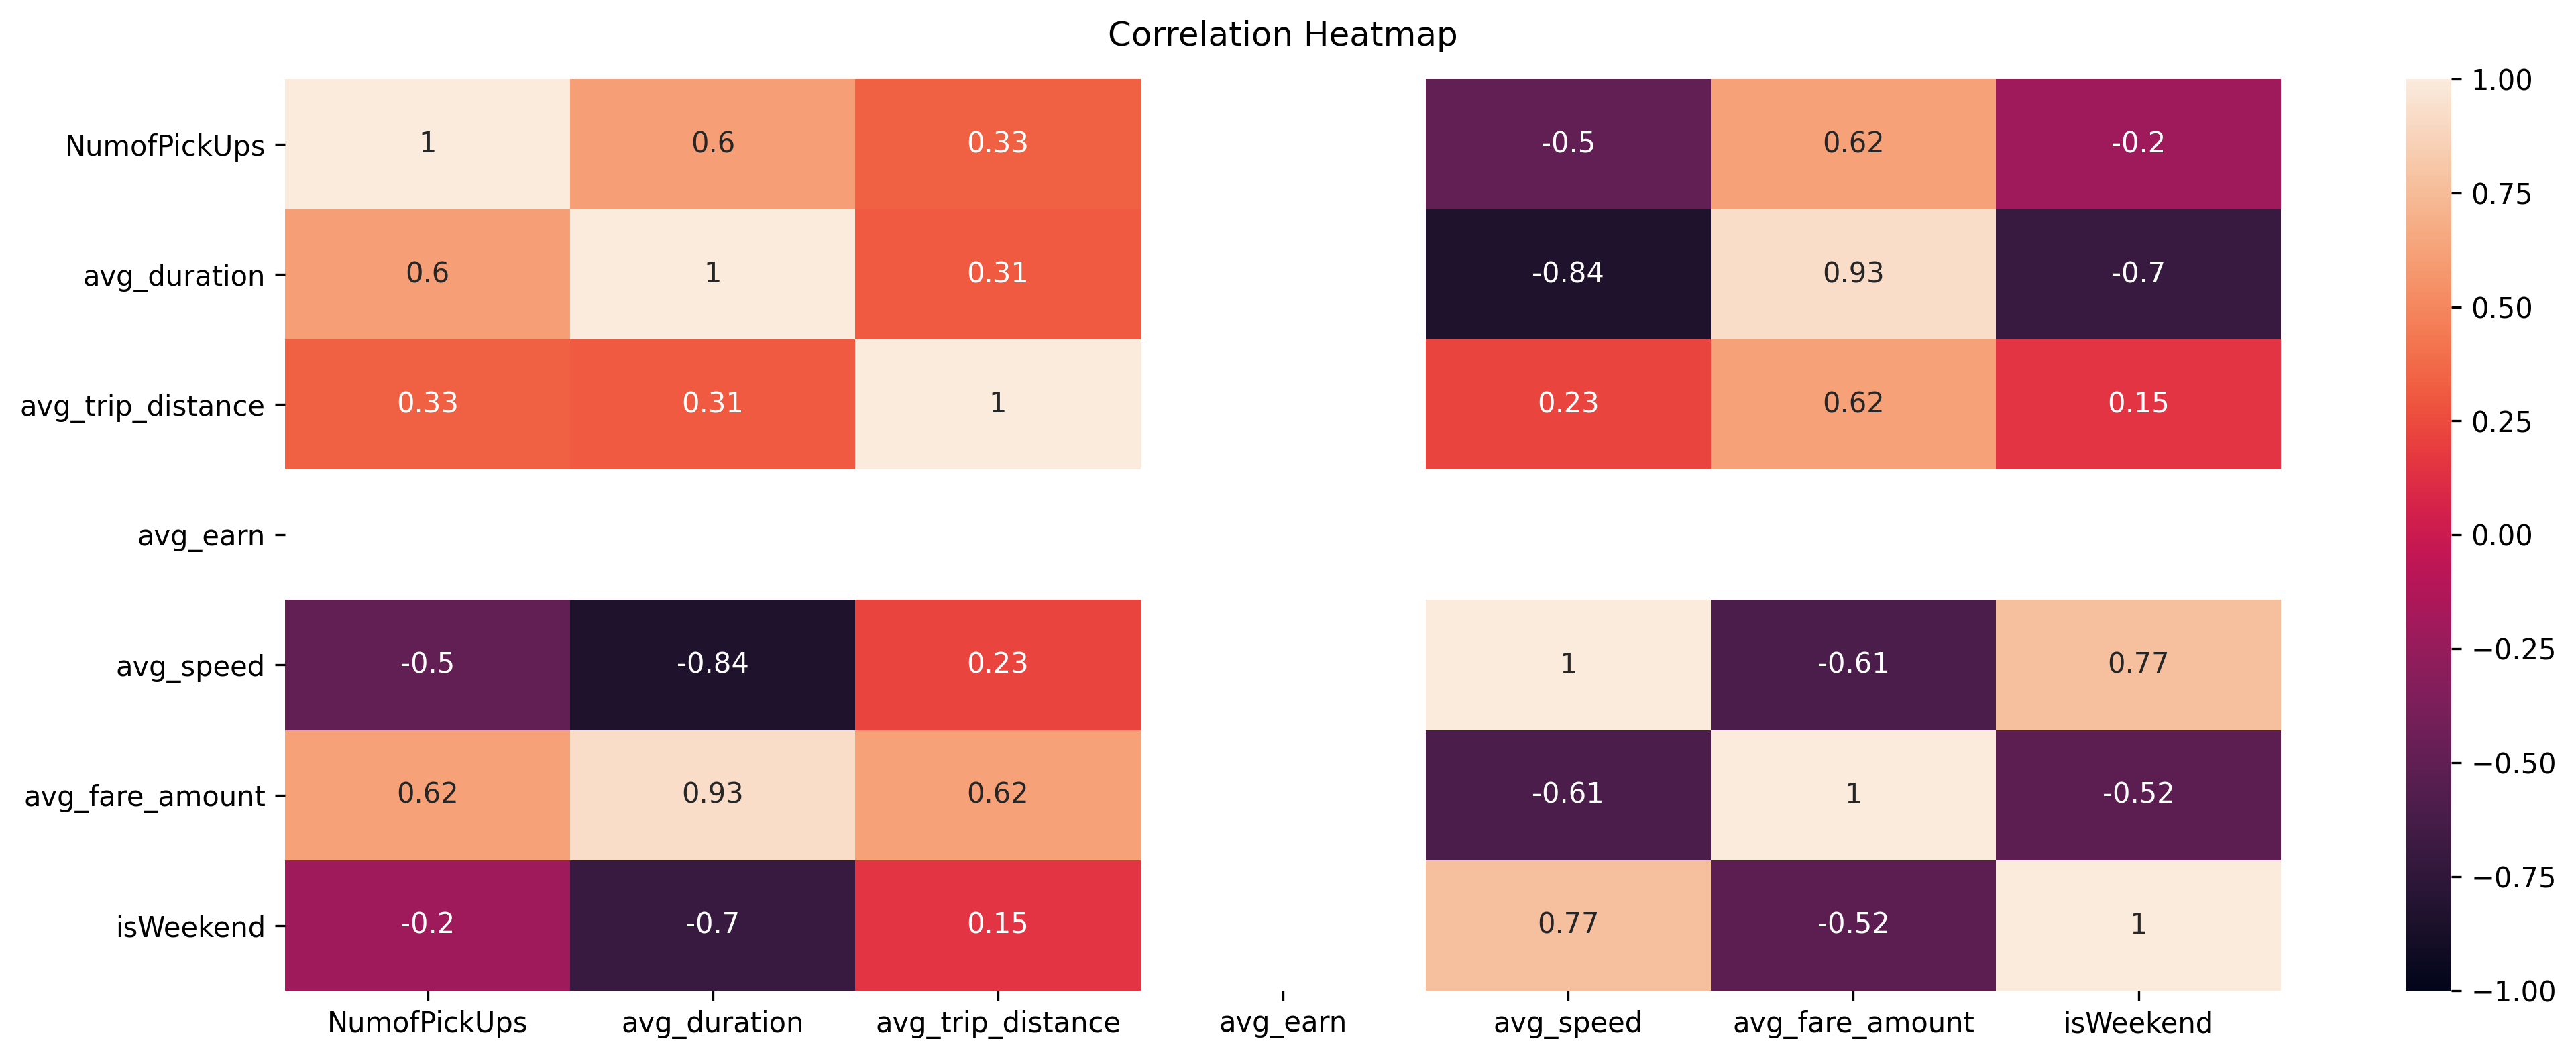

In [39]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(y_df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [40]:
y

1     212681
8     218495
15    190983
22    200990
29    201555
36    214477
43    206494
50    200742
57    195600
64    205810
71    207141
78    168767
85    193180
92    211031
Name: NumofPickUps, dtype: int64

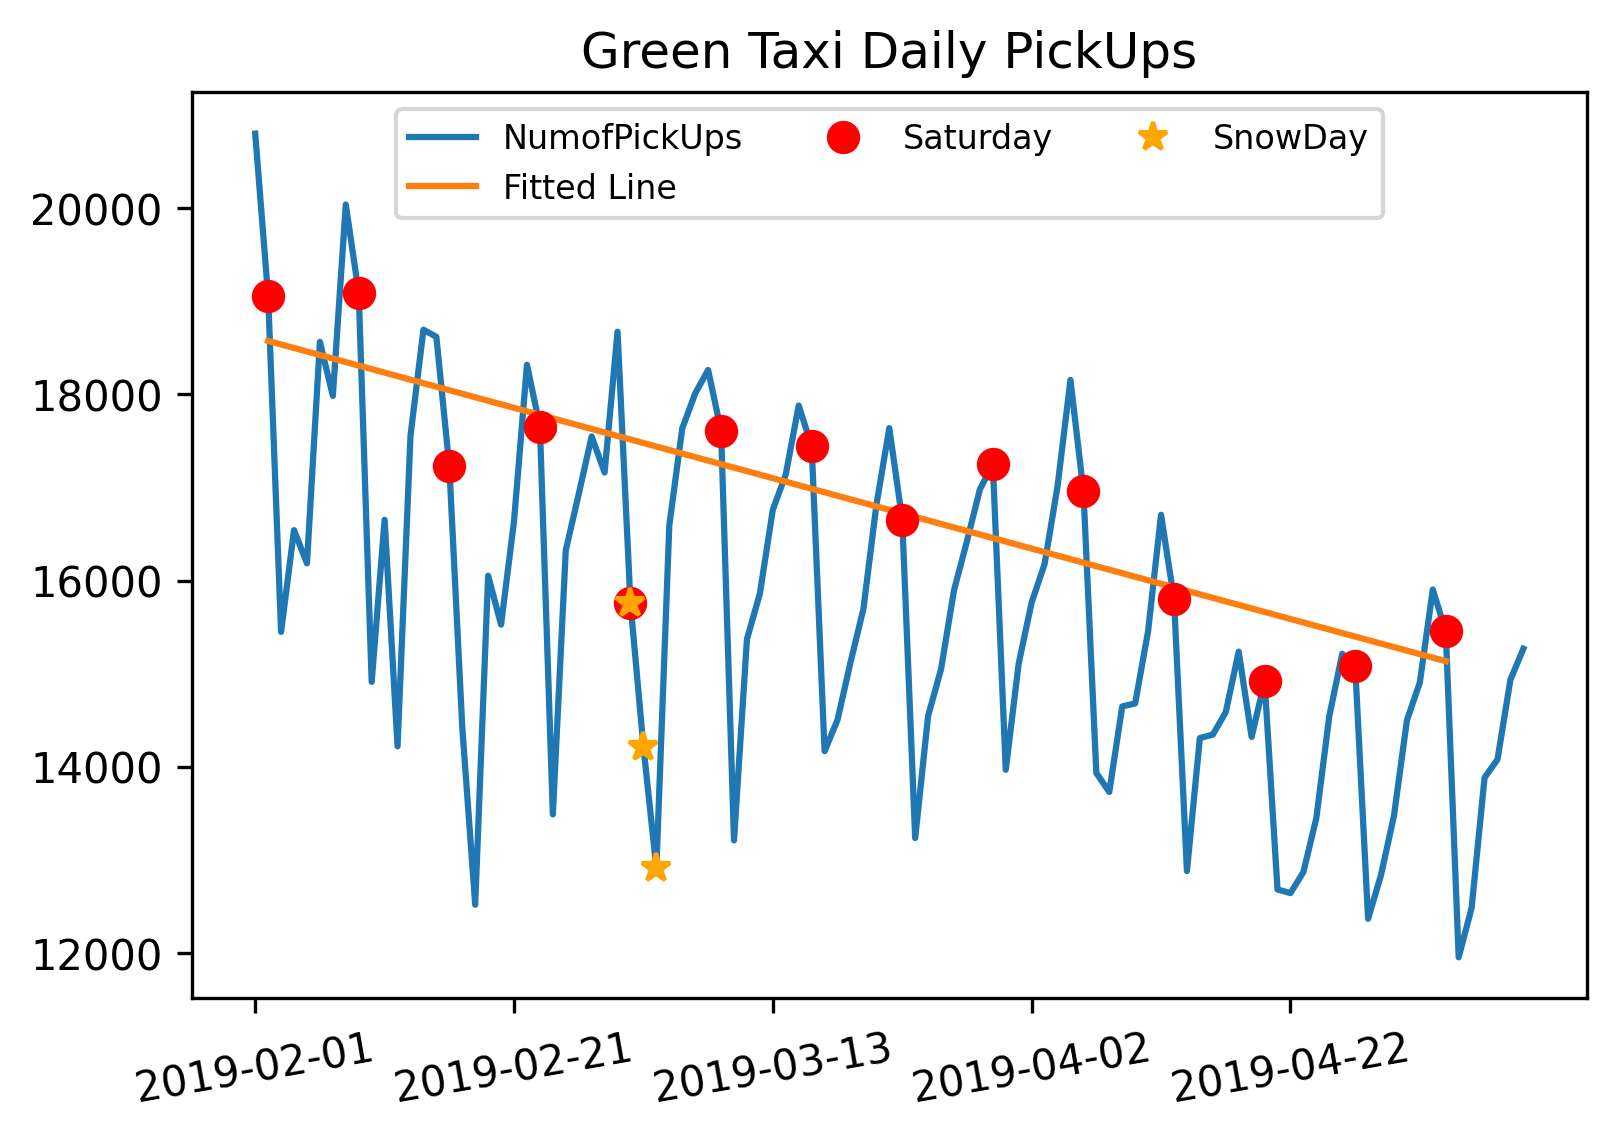

In [41]:


## Get Extreme Day's Data

e_y_df = y_df.loc[y_df["date"].astype(str).isin(extreme_days)]
e_y_df.head(2)

# Weekend data on overall

ax = y_df["NumofPickUps"].plot.line()



# Plot Linear Regression Line
x = y_df.index[y_df['DayOfWeek'] == "Sat"].tolist()
y = y_df.loc[y_df["DayOfWeek"]=="Sat"]["NumofPickUps"]

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
plt.plot( x, poly1d_fn(x), label="Fitted Line")


dow = plt.plot(y_df.index[fhv_df['DayOfWeek'] == "Sat"].tolist(),
             y_df.loc[fhv_df["DayOfWeek"]=="Sat"]["NumofPickUps"], 
             marker='o', markersize=7, color="red", label='Saturday', linestyle = 'None')

Snow = plt.plot(e_y_df.index.tolist(),
             e_y_df["NumofPickUps"], 
             marker='*', markersize=7, color="orange", label='SnowDay', linestyle = 'None')


plt.xticks(np.arange(fhv_df.shape[0])[::20], fhv_df.date[::20], rotation=10)

plt.legend(
           scatterpoints=1,
           loc='upper center',
           ncol=3,
           fontsize=8)

plt.title("Green Taxi Daily PickUps")

plt.savefig("../plots/Green_Time_PickUp.png")

plt.show()

Weekend Travels have 6.56% Drop compared with WeekDay Travels


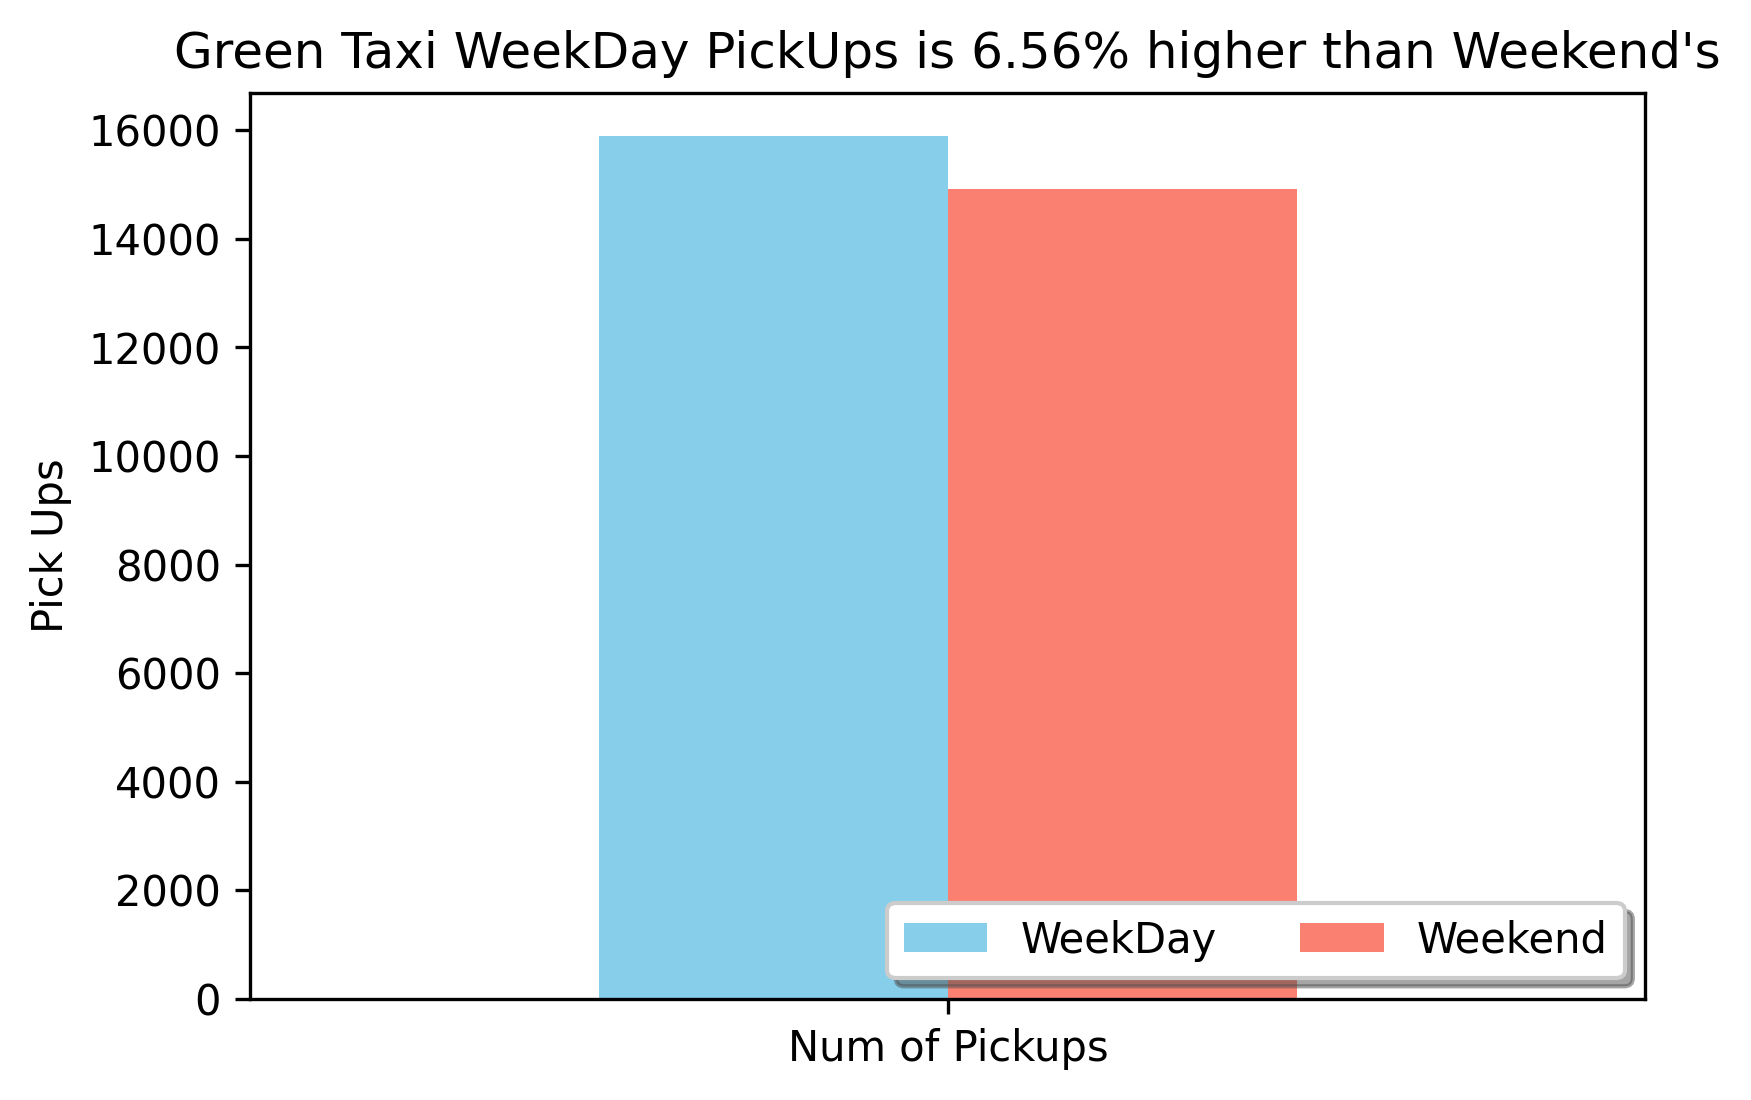

In [42]:

# WEEKDAY VS WEEKEND

# creating dataframe
df = pd.DataFrame({
    'Statistics': ['Num of Pickups'],
    'WeekDay': [
        y_df.loc[y_df['isWeekend'] == False,"NumofPickUps"].median()
                 ],
    'Weekend': [
        y_df.loc[y_df['isWeekend'] == True,"NumofPickUps"].median()
         ]
})
  
# plotting graph

fig = df.plot(
              x="Statistics",
              y=["WeekDay", "Weekend"],
              kind="bar",
              title="Green Taxi WeekDay PickUps is 6.56% higher than Weekend's",
              grid=0,
                color = color
             )

fig.set_xlabel("")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

percent = (y_df.loc[y_df['isWeekend'] == False,"NumofPickUps"].median() / y_df.loc[y_df['isWeekend'] == True,"NumofPickUps"].median() - 1)*100
print(f"Weekend Travels have {np.round(percent,2)}% Drop compared with WeekDay Travels")

fig.figure.savefig('../plots/G_Weekday_Vs_Weekend_PickUps_Overall.png')



Extreme Weather Causes 23.11% Drop On WEEKDAY Travels


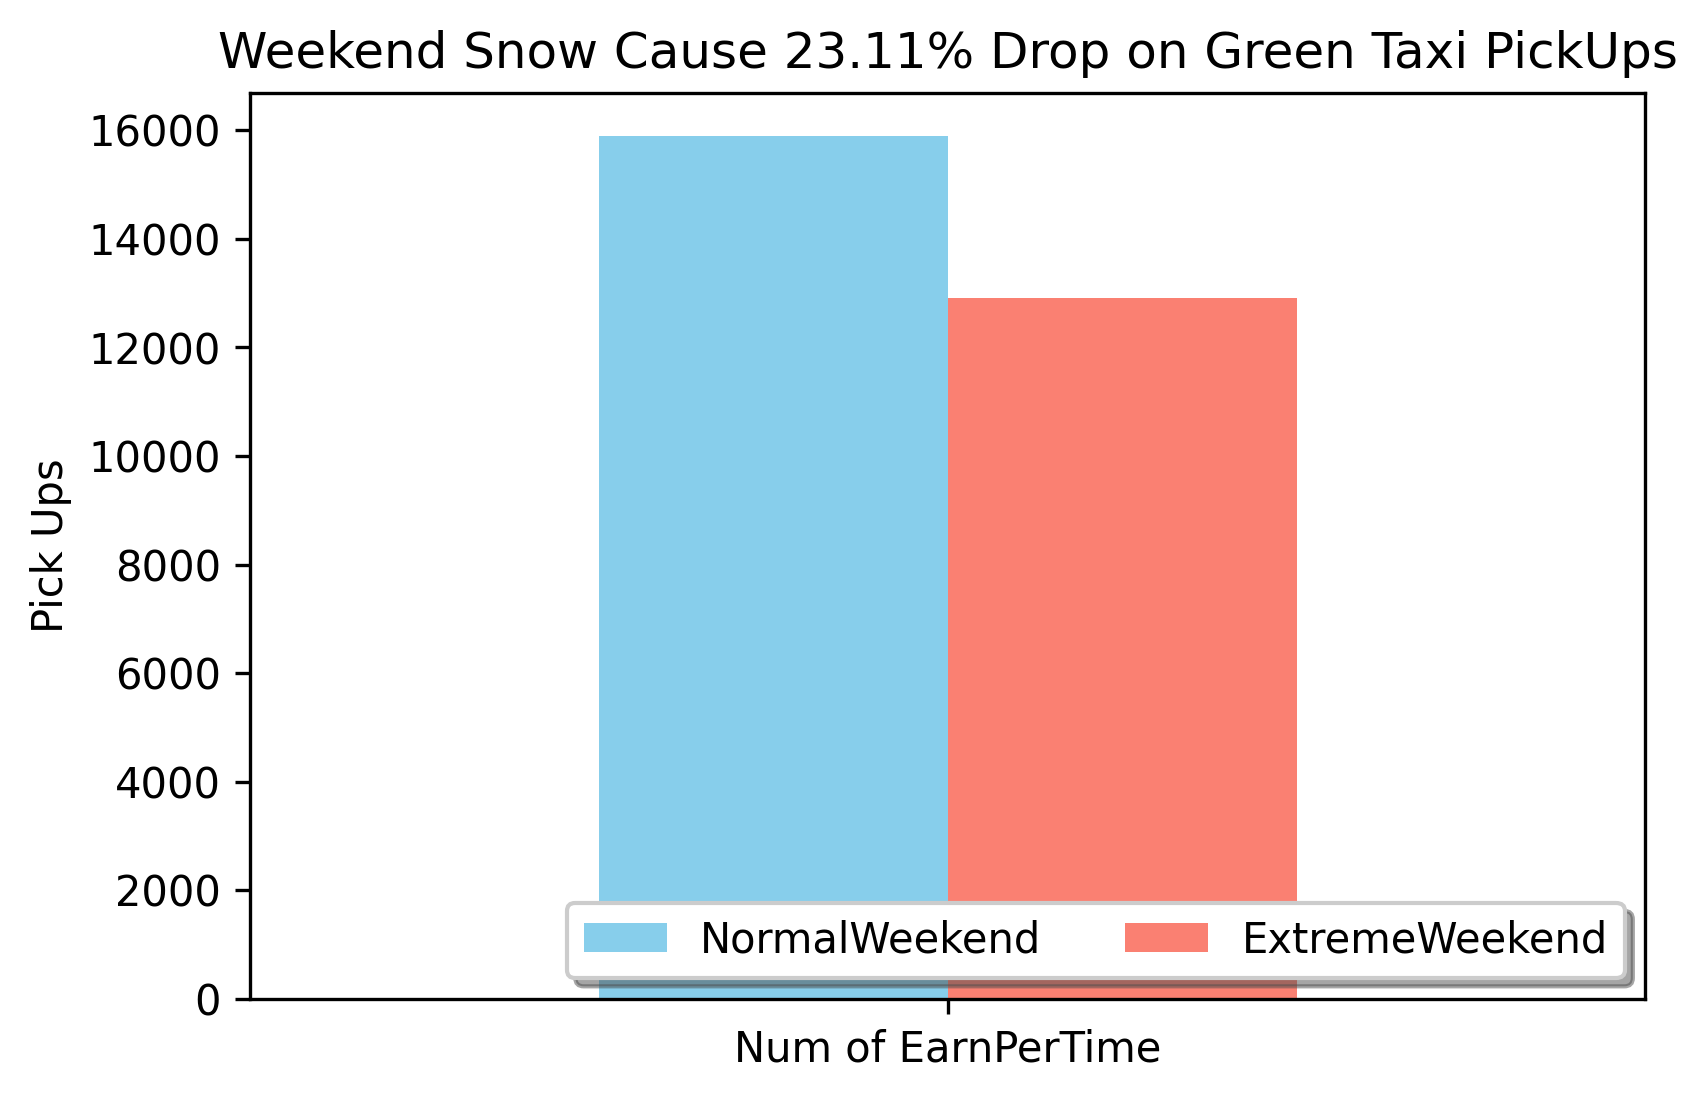

In [43]:

# WEEKDAY Extreme Weather Impact
# NumofPickUps avg_duration	avg_trip_distance	avg_earn	avg_speed	avg_fare_amount
y1 = y_df.loc[y_df['isWeekend'] == False,"NumofPickUps"].median()
y2 = e_y_df.loc[e_y_df['isWeekend'] == False,"NumofPickUps"].median()

# creating dataframe
df = pd.DataFrame({
    'Statistics': ['Num of EarnPerTime'],
    'NormalWeekend': [
        y1
                 ],
    'ExtremeWeekend': [
        y2
         ]
})
  
# plotting graph

fig = df.plot(
              x="Statistics",
              y=["NormalWeekend", "ExtremeWeekend"],
              kind="bar",
              title="Weekend Snow Cause 23.11% Drop on Green Taxi PickUps",
              grid=0, color = color
             )

fig.set_xlabel("")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

percent = (y1/y2 - 1)*100
print(f"Extreme Weather Causes {np.round(percent,2)}% Drop On WEEKDAY Travels")

fig.figure.savefig('../plots/G_Weekday_Vs_Weekend.png')

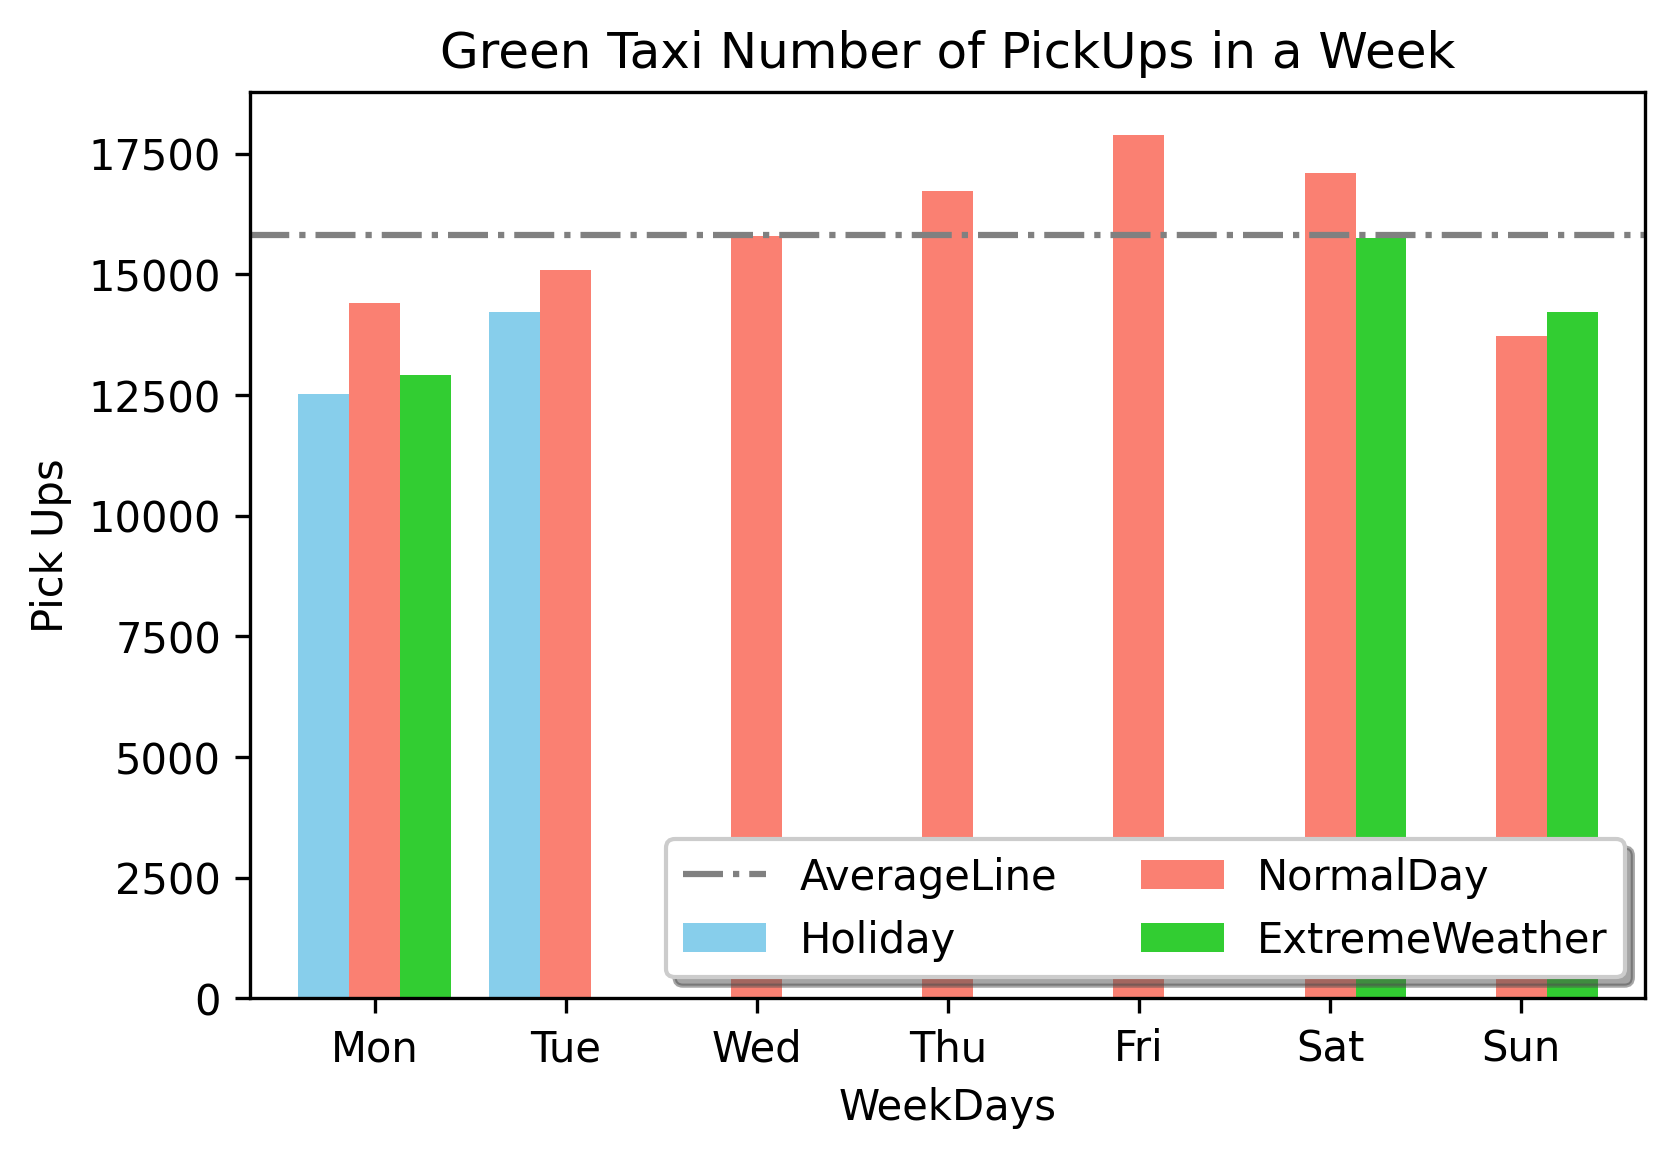

In [44]:
### Day of Week Summary (GroupBy DOW)
        
WEEKDAY = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

## Exclude Holiday as it may distort the result
#NormalDay
dow_df_pre_normal = y_df.loc[~isHoliday(y_df["date"])]
dow_df_normal = y_df.groupby("DayOfWeek").median().reindex(WEEKDAY) 

#ExtremeWeather
dow_df_pre_extreme = e_y_df.loc[~isHoliday(e_y_df["date"])]
dow_df_extreme = e_y_df.groupby("DayOfWeek").median().reindex(WEEKDAY) 

#Holiday
dow_df_holiday = y_df.loc[isHoliday(y_df["date"])].groupby("DayOfWeek").median().reindex(WEEKDAY) 

# Week Day Extreme VS Normal Pickups
x = WEEKDAY

y1 = dow_df_normal["NumofPickUps"]
y2 = dow_df_extreme["NumofPickUps"]
y3 = dow_df_holiday["NumofPickUps"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=['Holiday', "NormalDay", "ExtremeWeather", ],
              kind="bar",
              title="Green Taxi Number of PickUps in a Week",
              grid=0,
              width=0.8,
                color = color
             )

line_x = np.linspace(-1, 10,7)

# AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")



fig.set_xlabel("WeekDays")
fig.set_ylabel("Pick Ups")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

fig.figure.savefig('../plots/Green_Weekly.png')



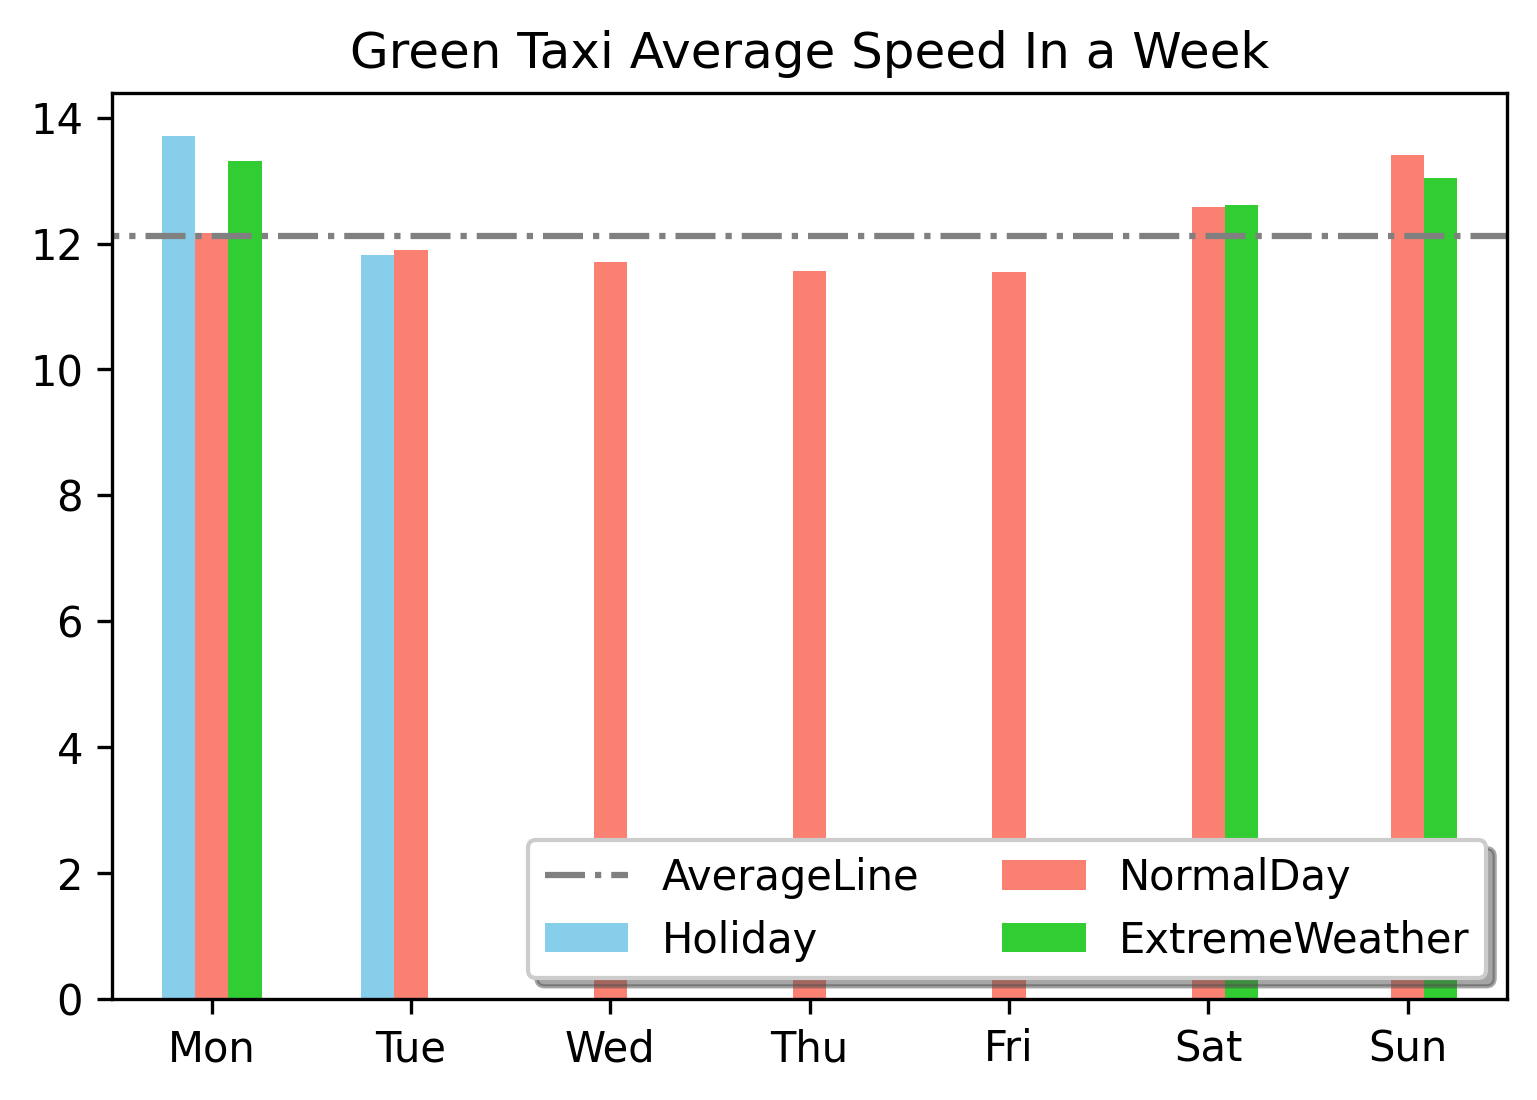

In [45]:

# Week Day Extreme VS Normal Pickups
x = WEEKDAY

y1 = dow_df_normal["avg_speed"]
y2 = dow_df_extreme["avg_speed"]
y3 = dow_df_holiday["avg_speed"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=["Holiday", "NormalDay", "ExtremeWeather"],
              kind="bar",
              title="Green Taxi Average Speed In a Week",
              grid=0,color=color
             )

#AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")

fig.set_xlabel("")
plt.xticks(rotation=0)
fig.legend(loc='lower right', shadow=True, ncol=2)

fig.figure.savefig('../plots/Green_avgSpeed_week.png')

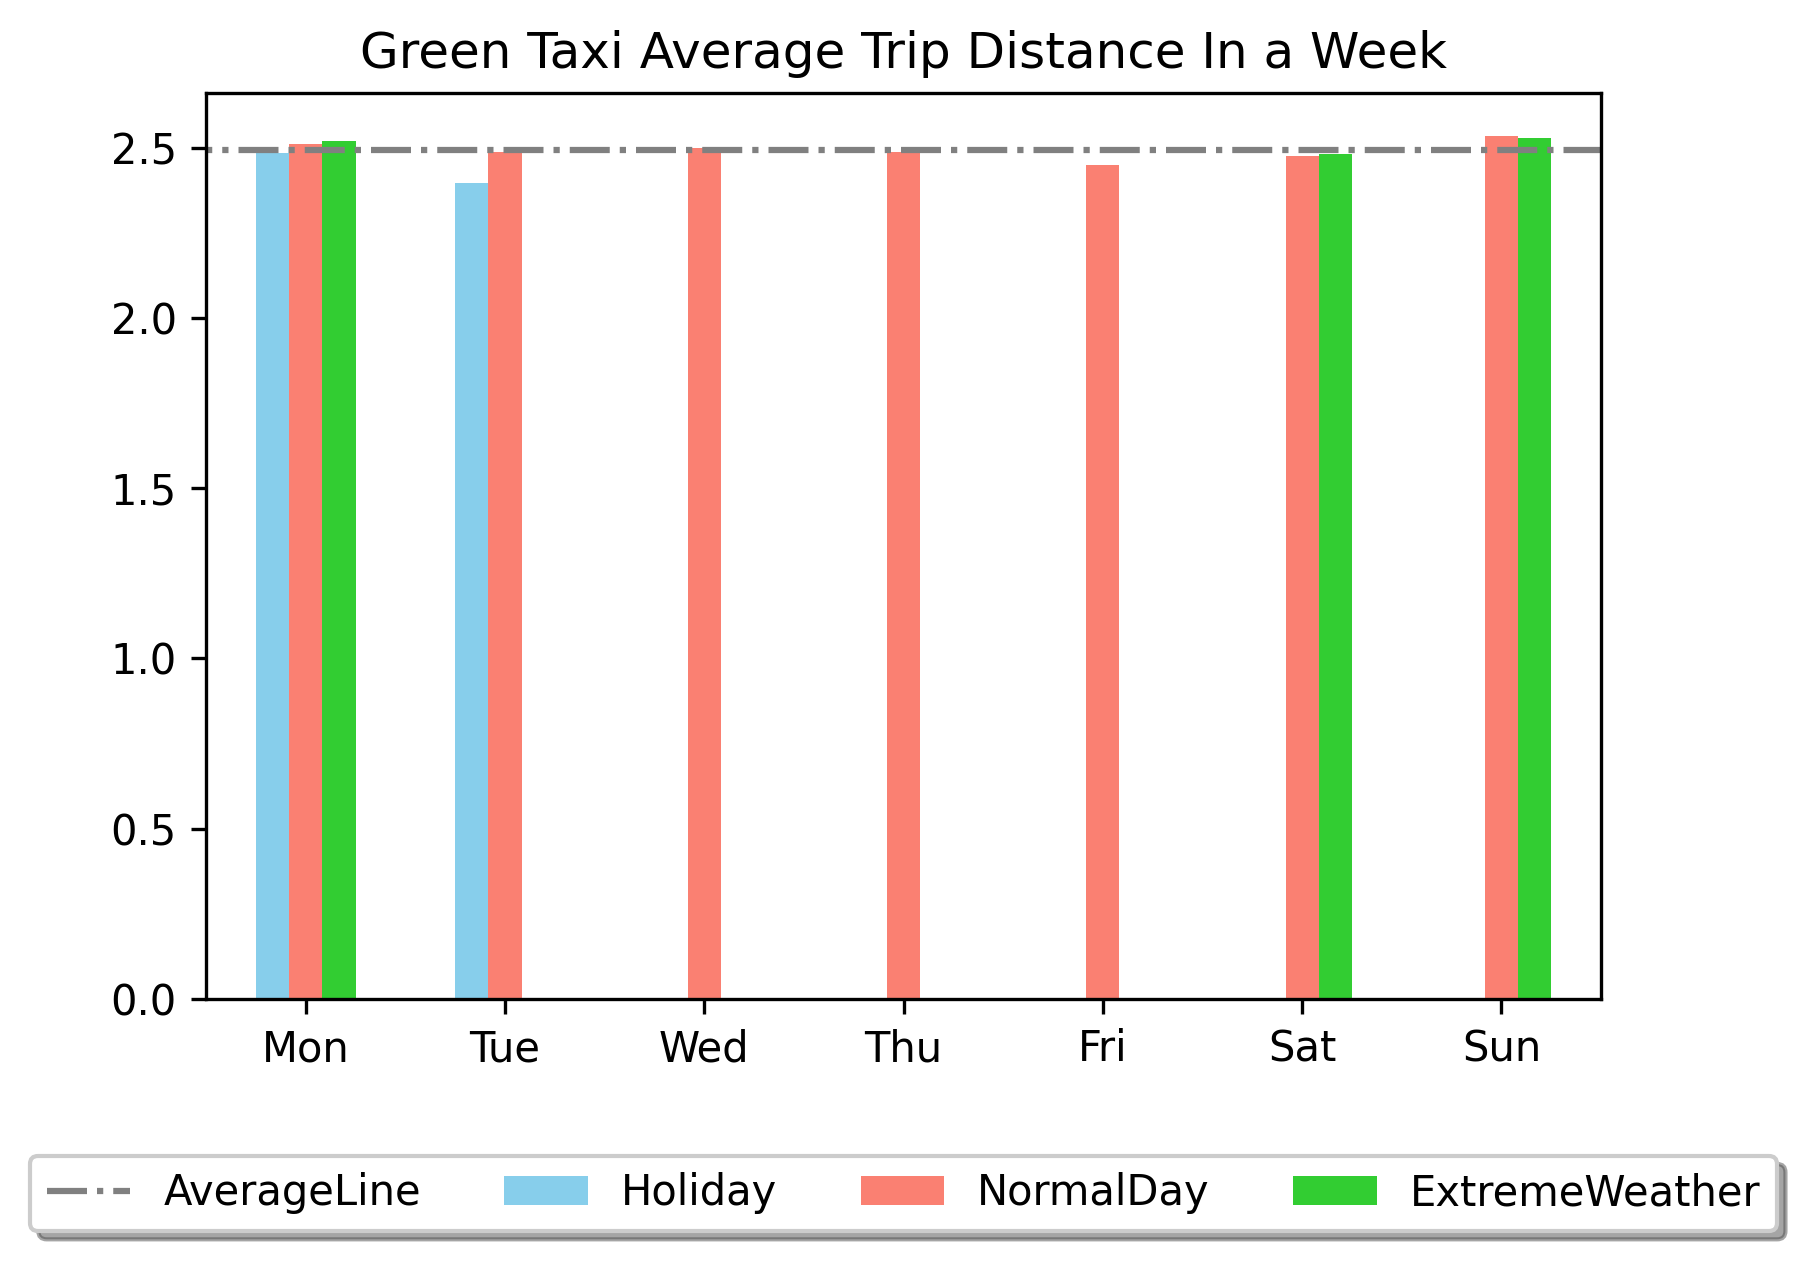

In [46]:
# Week Day Extreme VS Normal Pickups
x = WEEKDAY

y1 = dow_df_normal["avg_trip_distance"]
y2 = dow_df_extreme["avg_trip_distance"]
y3 = dow_df_holiday["avg_trip_distance"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=["Holiday", "NormalDay", "ExtremeWeather"],
              kind="bar",
              title="Green Taxi Average Trip Distance In a Week",
              grid=0,color=color
             )
#AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")

fig.set_xlabel("")
plt.xticks(rotation=0)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

fig.figure.savefig('../plots/Green_distance_weekly.png')



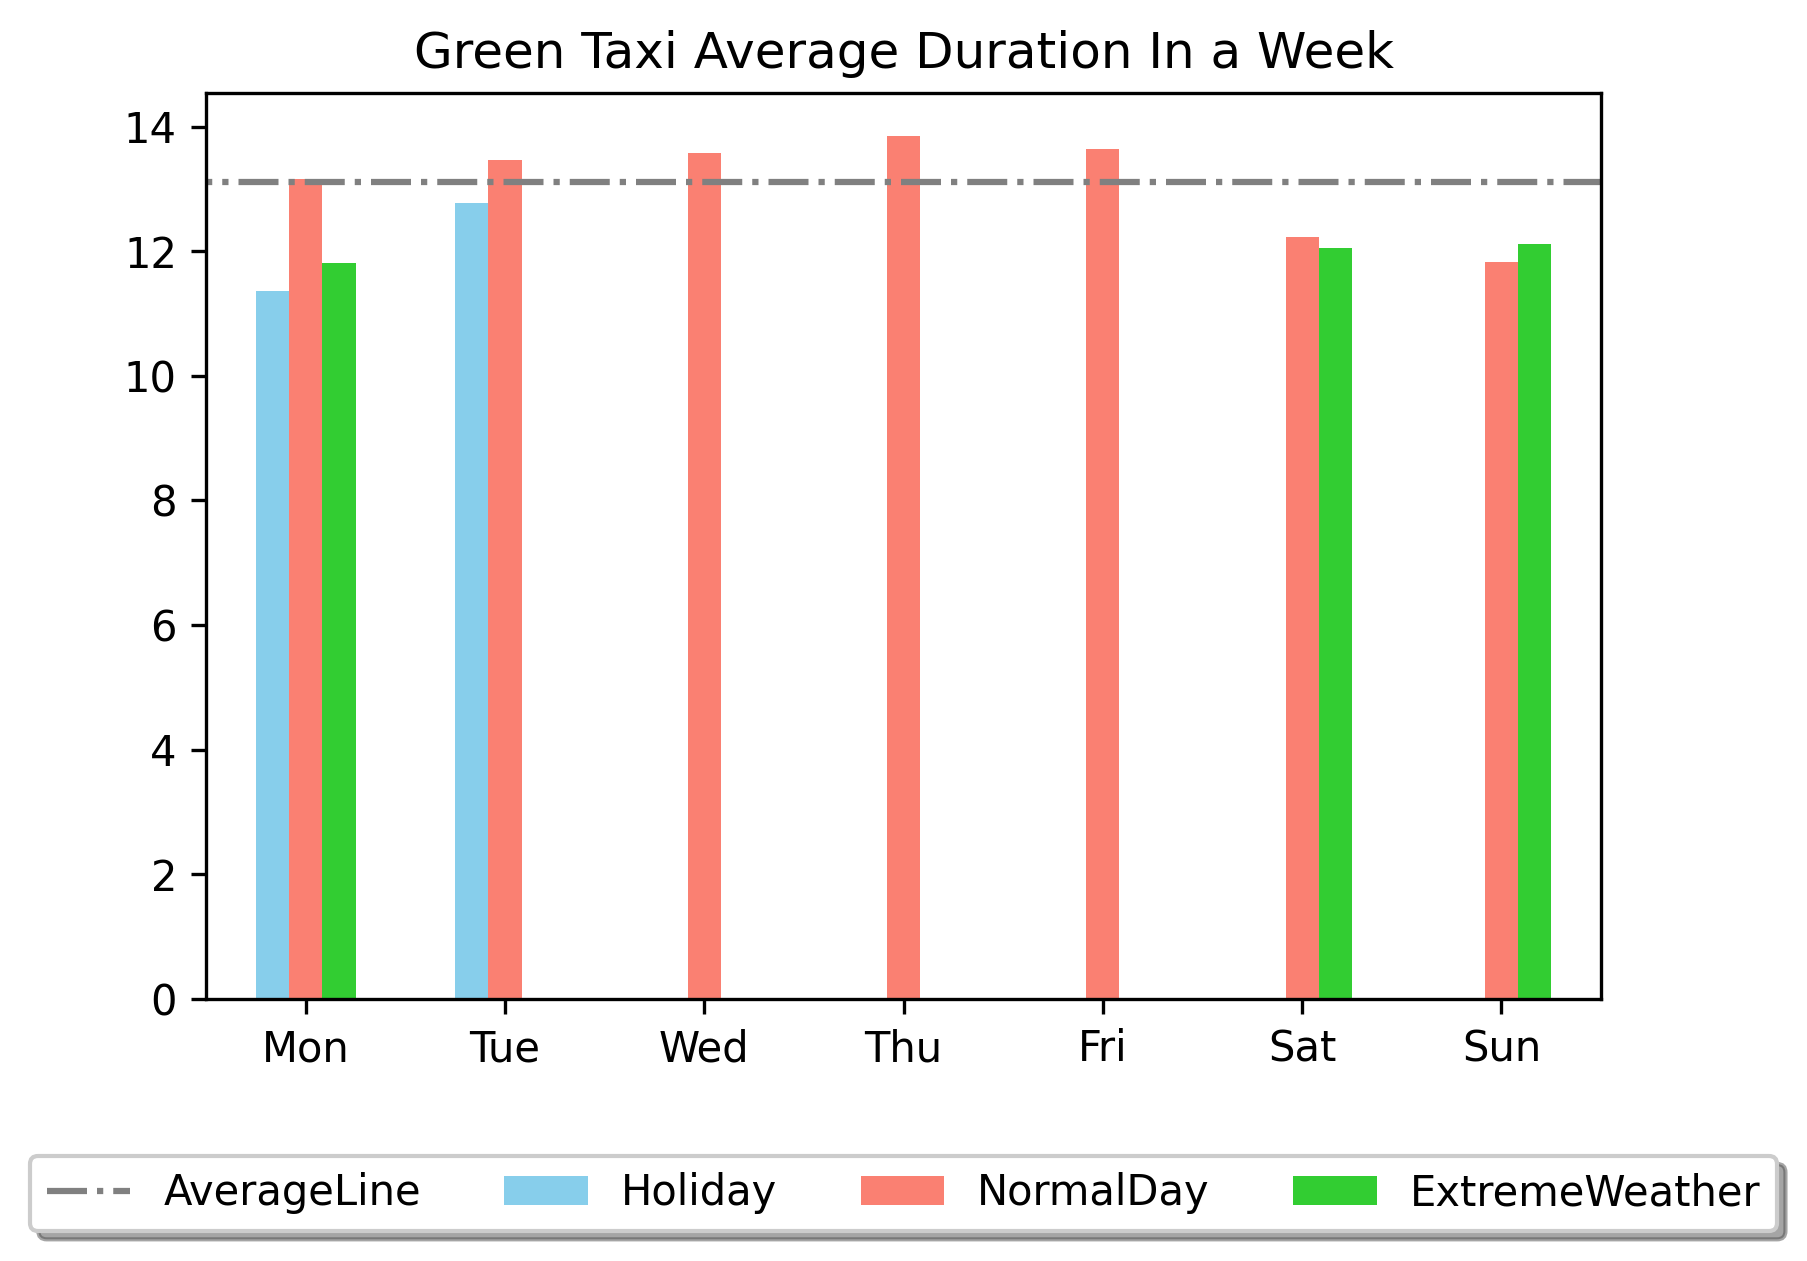

In [47]:

# Week Day Extreme VS Normal Pickups
x = WEEKDAY

y1 = dow_df_normal["avg_duration"]
y2 = dow_df_extreme["avg_duration"]
y3 = dow_df_holiday["avg_duration"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=["Holiday", "NormalDay", "ExtremeWeather"],
              kind="bar",
              title="Green Taxi Average Duration In a Week",
              grid=0,color=color
             )

#AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")


fig.set_xlabel("")
plt.xticks(rotation=0)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

fig.figure.savefig('../plots/Green_Weekly_Duration.png')

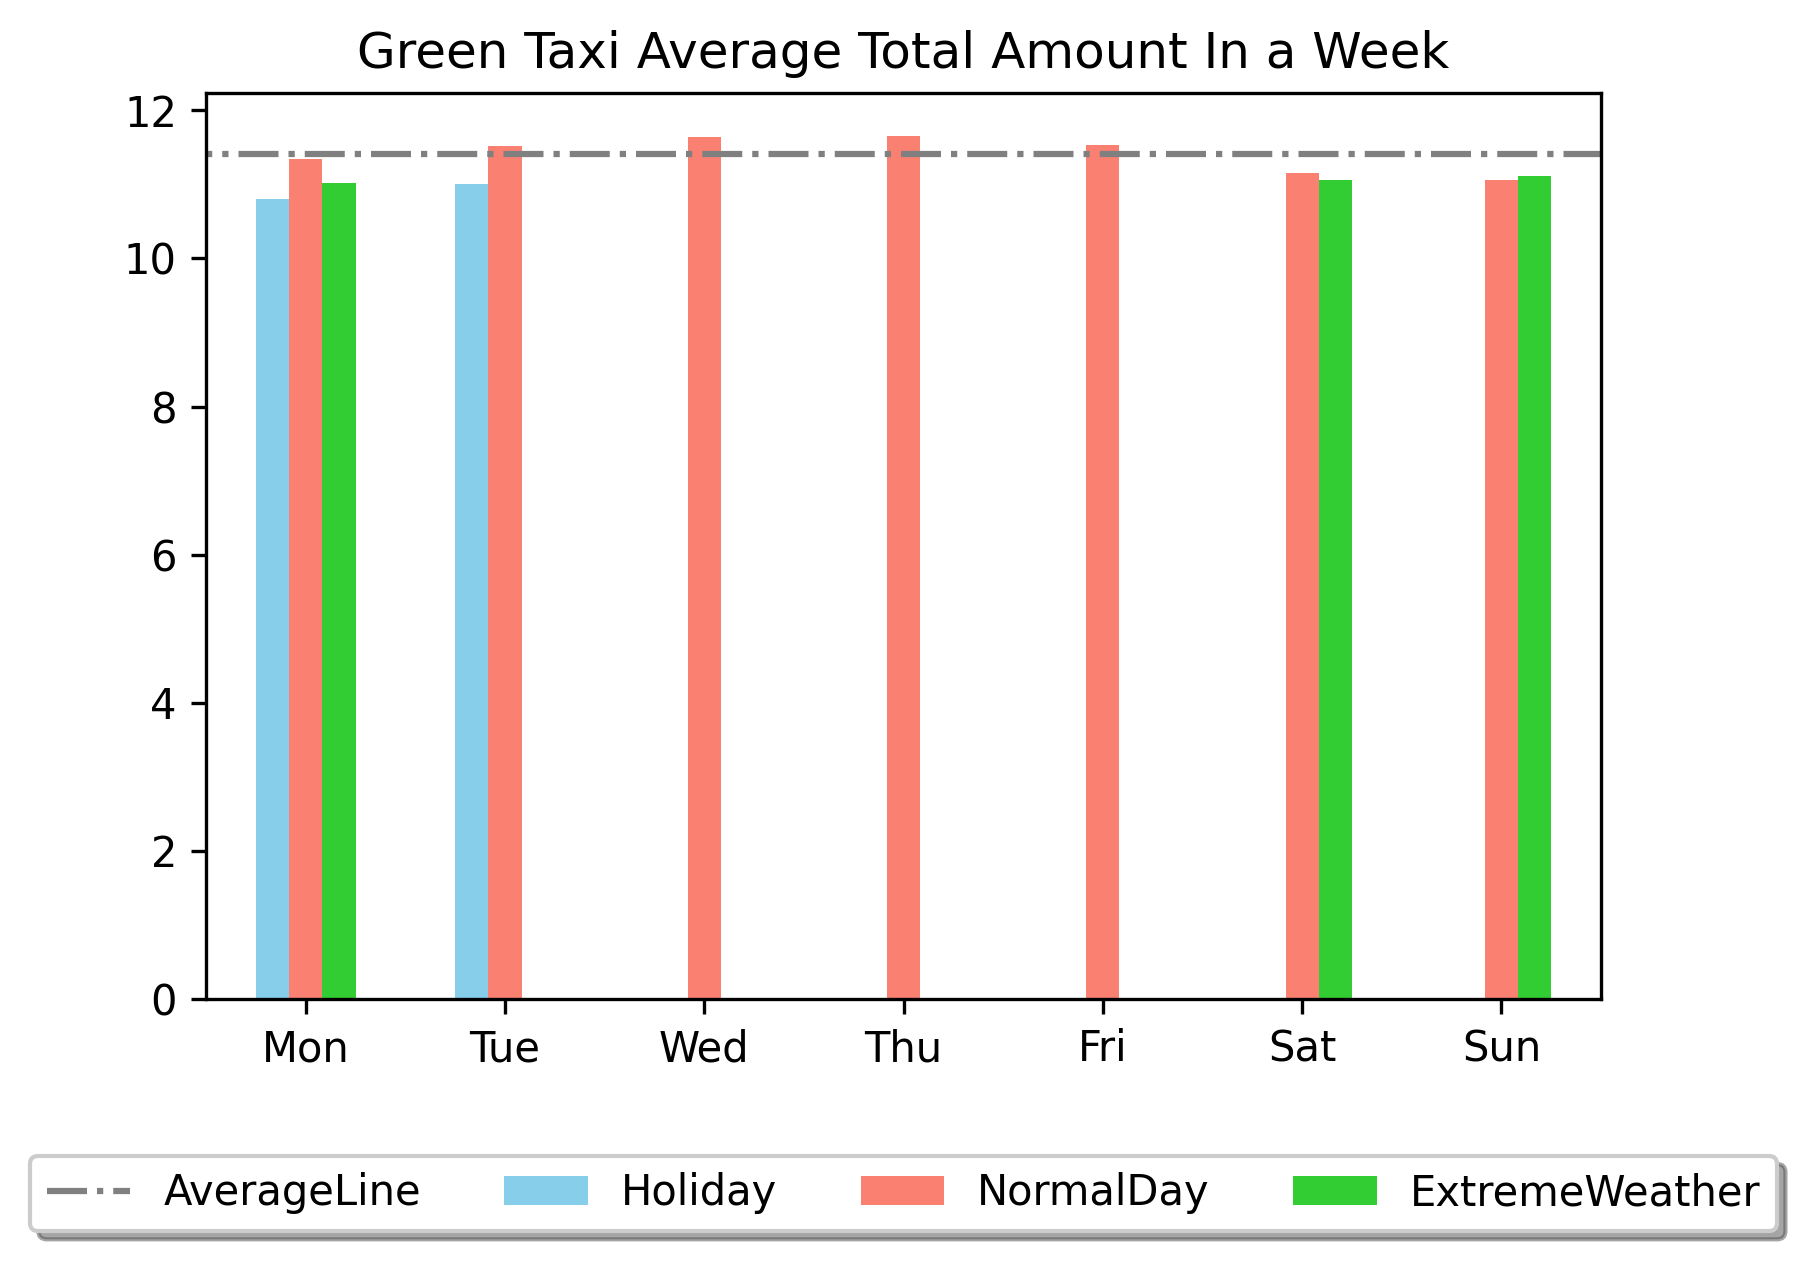

In [48]:



# Week Day Extreme VS Normal Pickups
x = WEEKDAY

y1 = dow_df_normal["avg_fare_amount"]
y2 = dow_df_extreme["avg_fare_amount"]
y3 = dow_df_holiday["avg_fare_amount"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
    'ExtremeWeather': y2,
    'Holiday': y3,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=["Holiday", "NormalDay", "ExtremeWeather"],
              kind="bar",
              title="Green Taxi Average Total Amount In a Week",
              grid=0,color=color
             )

#AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")


fig.set_xlabel("")
plt.xticks(rotation=0)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

fig.figure.savefig('../plots/Green_Total_amount.png')



## Traffic WeekDay Data

In [49]:
WEEKDAY = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [50]:
## Get Dataframe
traffic_daily = pd.read_parquet("../preprocessed_data/traffic_daily.parquet")
dow_df_normal_traffic = traffic_daily.groupby("DayOfWeek").sum()
# Reset Index and Sort By Week Day
dow_df_normal_traffic = dow_df_normal_traffic.reindex(WEEKDAY).reset_index()
dow_df_normal_traffic.head(7)

,DayOfWeek,Volume
0,Mon,1102035
1,Tue,1121330
2,Wed,990605
3,Thu,1011483
4,Fri,995806
5,Sat,1754909
6,Sun,1488611


In [51]:
dow_df_normal_traffic

,DayOfWeek,Volume
0,Mon,1102035
1,Tue,1121330
2,Wed,990605
3,Thu,1011483
4,Fri,995806
5,Sat,1754909
6,Sun,1488611


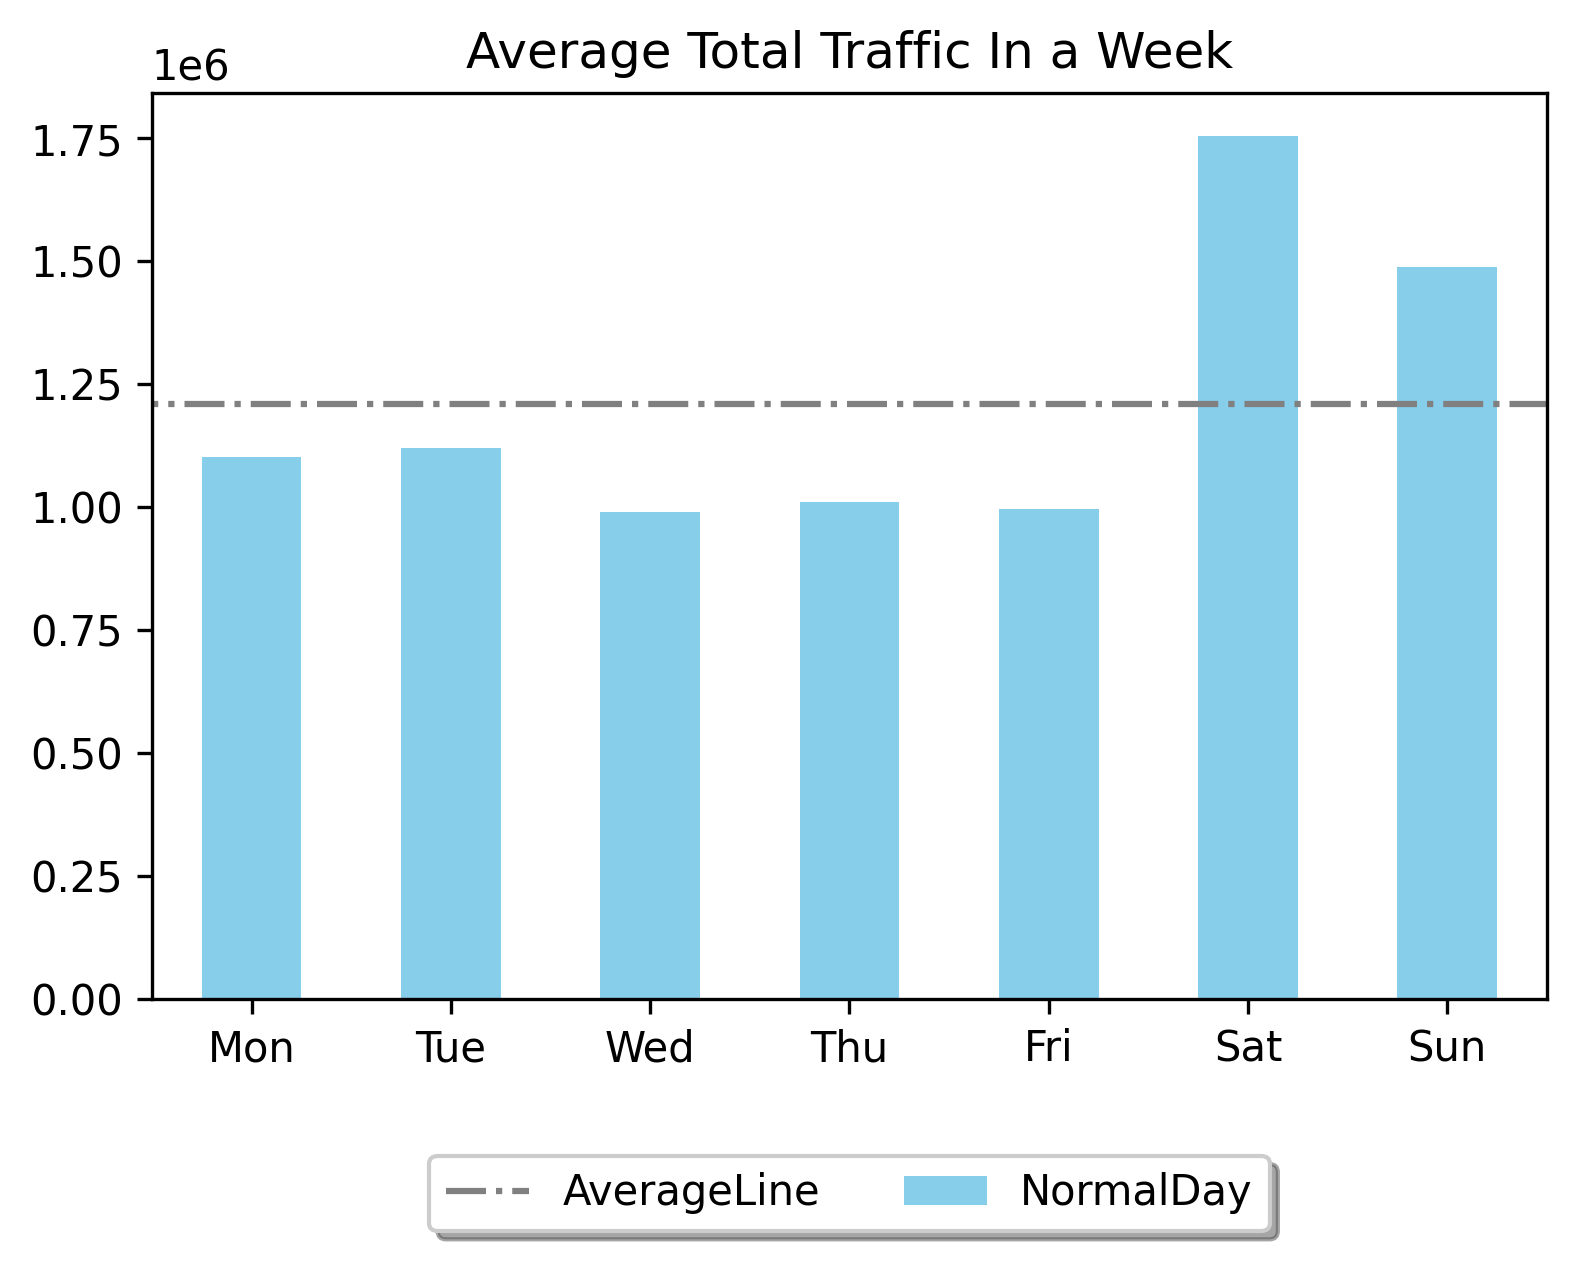

In [52]:



# Week Day Extreme VS Normal Pickups


x = WEEKDAY
y1 = dow_df_normal_traffic["Volume"]
#y2 = dow_df_extreme["avg_fare_amount"]
#y3 = dow_df_holiday["avg_fare_amount"]

# creating dataframe
df = pd.DataFrame({
    'Statistics': x,
    'NormalDay': y1,
})

# plotting graph

fig = df.plot(
              x="Statistics",
              y=["NormalDay"],
              kind="bar",
              title="Average Total Traffic In a Week",
              grid=0,color=color
             )

line_x = np.linspace(-1, 10,7)
#AVG line
fig.plot(line_x, [y1.mean()]*7, color = "grey", ls = "-.", label="AverageLine")


fig.set_xlabel("")
plt.xticks(rotation=0)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

fig.figure.savefig('../plots/Traffic_Average.png')

